# Imports

In [87]:
import os
import warnings
import logging
import pickle
import sys
import time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as st
import sklearn
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.utils import resample
from sklearn.metrics import make_scorer, f1_score, precision_score, recall_score
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

import config

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
logger = logging.getLogger()
warnings.filterwarnings("ignore")

## Data loading

In [27]:
matrix_subject_phases = os.path.join('..', 'features', 'matrix-2019-0226_15-16-44Features-157015.xlsx')
matrix_agent_phases = os.path.join('..', 'features', 'matrix-2019-0226_17-18-28Features-agent-157015.xlsx')
matrix_subject_nophase = os.path.join('..', 'features', 'matrix-2019-0227_20-11-53Features-nophase.xlsx')
matrix_agent_nophase = os.path.join('..', 'features', 'matrix-2019-0227_22-43-15Features-agent-nophase.xlsx') 

def prepare_df(df):
    df = df.drop(['Presence Score', 'Co-presence Score'], axis=1)
    df = df.rename(index=str,
                   columns={"Presence Class": "PresenceClass", "Co-presence Class": "CopresenceClass"})
    return df

def prepare_agent_df(df):
    df = prepare_df(df)
    df = df.drop(['PresenceClass', 'CopresenceClass', 'Duration', 'Expert'], axis=1)
    agent_cols_rename = {}
    for col in df.columns:
        if col not in ['Candidate', 'Environment']:
            agent_cols_rename[col] = col + '_agent'
    df = df.rename(index=str, columns=agent_cols_rename)
    return df
    
def dfval(df, candidate, environment, column):
    return df.query("Candidate == '%s' & Environment == '%s'" % (candidate, environment))[column].values

print("Loading data - phases split ...")

subject_p_df = pd.read_excel(matrix_subject_phases)
subject_p_df = prepare_df(subject_p_df)
print("   Subject(phases): %d samples" % len(subject_p_df))
agent_p_df = pd.read_excel(matrix_agent_phases)
agent_p_df = prepare_agent_df(agent_p_df)
print("   Agent(phases): %d samples" % len(agent_p_df))
# add Duration feature from subject to agent - requires to first merge both datasets
agent_p_df = pd.merge(agent_p_df, subject_p_df[['Candidate', 'Environment', 'Duration', 'PresenceClass', 'CopresenceClass']], on=['Candidate', 'Environment'], 
                      how='inner', suffixes=(False, False))
print("   Agent(phases-merged): %d samples" % len(agent_p_df))

# no phase

subject_np_df = pd.read_excel(matrix_subject_nophase)
subject_np_df = prepare_df(subject_np_df)
print("   Subject(no phase): %d samples" % len(subject_np_df))
agent_np_df = pd.read_excel(matrix_agent_nophase)
agent_np_df = prepare_agent_df(agent_np_df)
print("   Agent(no phase): %d samples" % len(agent_p_df))
# add Duration feature from subject to agent - requires to first merge both datasets
agent_np_df = pd.merge(agent_np_df, subject_np_df[['Candidate', 'Environment', 'Duration', 'PresenceClass', 'CopresenceClass']], on=['Candidate', 'Environment'], 
                      how='inner', suffixes=(False, False))
print("   Agent(no phase-merged): %d samples" % len(agent_np_df))

subject_p_df.index = [subject_p_df['Candidate'], subject_p_df['Environment']]
agent_p_df.index = [agent_p_df['Candidate'], agent_p_df['Environment']]
subject_np_df.index = [subject_np_df['Candidate'], subject_np_df['Environment']]
agent_np_df.index = [agent_np_df['Candidate'], agent_np_df['Environment']]

intersect = set(subject_p_df.index) & set(agent_p_df.index) & set(subject_np_df.index) & set(agent_np_df.index)
print("  samples intersection %d" % len(intersect))

rejected_from_subject_p_df = set(subject_p_df.index) - intersect
rejected_from_subject_np_df = set(subject_np_df.index) - intersect
rejected_from_agent_p_df = set(agent_p_df.index) - intersect
rejected_from_agent_np_df = set(agent_np_df.index) - intersect

# restrict each dataset to the common samples
subject_p_df = subject_p_df.loc[list(intersect)].reset_index(drop=True)
subject_np_df = subject_np_df.loc[list(intersect)].reset_index(drop=True)
agent_p_df = agent_p_df.loc[list(intersect)].reset_index(drop=True)
agent_np_df = agent_np_df.loc[list(intersect)].reset_index(drop=True)

all_p_df = pd.merge(subject_p_df, agent_p_df.drop(['Duration', 'PresenceClass', 'CopresenceClass'], axis=1), on=['Candidate', 'Environment'], 
                    how='inner', suffixes=(False, False))
#all_p_df = all_p_df.drop(['PresenceClass_agent', 'CopresenceClass_agent', 'Duration_agent', 'Expert_agent'], axis=1)
print("   Merge(phases): %d samples " % len(all_p_df))

all_np_df = pd.merge(subject_np_df, agent_np_df.drop(['Duration', 'PresenceClass', 'CopresenceClass'], axis=1), on=['Candidate', 'Environment'], 
                     how='inner', suffixes=(False, False))
#all_np_df = all_np_df.drop(['PresenceClass_agent', 'CopresenceClass_agent', 'Duration_agent', 'Expert_agent'], axis=1)
print("   Merge(no phase): %d samples " % len(all_np_df))

print("")
print("Additional info:")
print("   samples rejected from subject / phases   %d" % len(rejected_from_subject_p_df))
for item in sorted(list(rejected_from_subject_p_df)) : print("     %s / %s" % (item[0], item[1]))
print("   samples rejected from subject / no phase %d" % len(rejected_from_subject_np_df))
for item in sorted(list(rejected_from_subject_np_df)) : print("     %s / %s" % (item[0], item[1]))
print("   samples rejected from agent / phases     %d" % len(rejected_from_agent_p_df))
for item in sorted(list(rejected_from_agent_p_df)) : print("     %s / %s" % (item[0], item[1]))
print("   samples rejected from agent / no phase   %d" % len(rejected_from_agent_np_df))
for item in sorted(list(rejected_from_agent_np_df)) : print("     %s / %s" % (item[0], item[1]))


Loading data - phases split ...
   Subject(phases): 83 samples
   Agent(phases): 95 samples
   Agent(phases-merged): 81 samples
   Subject(no phase): 86 samples
   Agent(no phase): 81 samples
   Agent(no phase-merged): 81 samples
  samples intersection 78
   Merge(phases): 78 samples 
   Merge(no phase): 78 samples 

Additional info:
   samples rejected from subject / phases   5
     N11E / PC
     N12F / Cave
     N21C / Casque
     N22D / Casque
     N23E / PC
   samples rejected from subject / no phase 8
     E6F / Casque
     N11E / PC
     N12F / Cave
     N1A / Cave
     N21C / Casque
     N22D / Casque
     N23E / PC
     N7A / Cave
   samples rejected from agent / phases     3
     N11E / PC
     N22D / Casque
     N23E / PC
   samples rejected from agent / no phase   3
     N1A / Cave
     N21C / Casque
     N7A / Cave


## Features definition

In [5]:
# features including phases

features_df_index = [
             ['Doctor', 'Agent', 'Doctor+Agent'], 
             ['No Phase', '157015', 'Verbal', 'Non-Verbal', 'Multimodal', 'Multimodal+Duration']
            ]
features_df_columns = ['precision', 'f1', 'recall', 'params']
features_df_multiindex = pd.MultiIndex.from_product(features_df_index, 
                                                  names=['Subject', 'Feature Set'])

features_df = pd.DataFrame(index=features_df_multiindex)
features_df

Empty DataFrame
Columns: []
Index: [(Doctor, No Phase), (Doctor, 157015), (Doctor, Verbal), (Doctor, Non-Verbal), (Doctor, Multimodal), (Doctor, Multimodal+Duration), (Agent, No Phase), (Agent, 157015), (Agent, Verbal), (Agent, Non-Verbal), (Agent, Multimodal), (Agent, Multimodal+Duration), (Doctor+Agent, No Phase), (Doctor+Agent, 157015), (Doctor+Agent, Verbal), (Doctor+Agent, Non-Verbal), (Doctor+Agent, Multimodal), (Doctor+Agent, Multimodal+Duration)]

In [12]:
def get_features_set(subject_name, set_name):
    row = features_df.loc[(subject_name, set_name)]
    return features_df.columns[row == True]

# Load features sets definition
features_df = pd.read_excel(os.path.join(config.OUT_PATH, 'features_sets.xlsx'))
features_df.index = features_df_multiindex
features_df = features_df.drop(['Subject', 'Feature Set'], axis=1)
features_df

Expert  Head_Entropy_Start  \
Subject      Feature Set                                       
Doctor       No Phase               True               False   
             157015                 True                True   
             Verbal                False               False   
             Non-Verbal            False               False   
             Multimodal            False               False   
             Multimodal+Duration   False               False   
Agent        No Phase              False               False   
             157015                False               False   
             Verbal                False               False   
             Non-Verbal            False               False   
             Multimodal            False               False   
             Multimodal+Duration   False               False   
Doctor+Agent No Phase               True               False   
             157015                 True                True   
             Verbal                False               False   
             Non-Verbal            False               False   
             Multimodal            False               False   
             Multimodal+Duration   False               False   

                                  Head_Entropy_Mid  Head_Entropy_End  \
Subject      Feature Set                                               
Doctor       No Phase                         True             False   
             157015                           True              True   
             Verbal                          False             False   
             Non-Verbal                       True             False   
             Multimodal                       True             False   
             Multimodal+Duration              True             False   
Agent        No Phase                        False             False   
             157015                          False             False   
             Verbal                          False             False   
             Non-Verbal                      False             False   
             Multimodal                      False             False   
             Multimodal+Duration             False             False   
Doctor+Agent No Phase                         True             False   
             157015                           True              True   
             Verbal                          False             False   
             Non-Verbal                       True             False   
             Multimodal                       True             False   
             Multimodal+Duration              True             False   

                                  Avg_HandEntropy_Begin  Avg_HandEntropy_Mid  \
Subject      Feature Set                                                       
Doctor       No Phase                             False                 True   
             157015                                True                 True   
             Verbal                               False                False   
             Non-Verbal                           False                 True   
             Multimodal                           False                 True   
             Multimodal+Duration                  False                 True   
Agent        No Phase                             False                False   
             157015                               False                False   
             Verbal                               False                False   
             Non-Verbal                           False                False   
             Multimodal                           False                False   
             Multimodal+Duration                  False                False   
Doctor+Agent No Phase                             False                 True   
             157015                                True                 True   
             Verbal             

In [8]:
### Optional - (re)initialize features sets if necessary

# todo "Avg_IPUlen_Begin", "Avg_IPUlen_Middle", "Avg_IPUlen_End" removed because of wrong values
#__features = ["Expert", "Head_Entropy_Start", "Head_Entropy_Mid", "Head_Entropy_End", "Avg_HandEntropy_Begin",
#             "Avg_HandEntropy_Mid", "Avg_HandEntropy_End", "Avg_SentenceLength_Begin", "Avg_SentenceLength_Mid",
#             "Avg_SentenceLength_End",  "Ratio1_Begin", "Ratio1_Mid", "Ratio1_End", "Ratio2_Begin", "Ratio2_Mid", 
#                    "Ratio2_End", "Duration"]
subject_features = ['Expert', "Head_Entropy_Start", "Head_Entropy_Mid", "Head_Entropy_End", "Avg_HandEntropy_Begin",
             "Avg_HandEntropy_Mid", "Avg_HandEntropy_End", "Avg_SentenceLength_Begin", "Avg_SentenceLength_Mid",
             "Avg_SentenceLength_End",  "Ratio1_Begin", "Ratio1_Mid", "Ratio1_End", "Ratio2_Begin", "Ratio2_Mid", 
                    "Ratio2_End", "Duration"]
agent_features = [feat+'_agent' for feat in subject_features if feat not in ['Expert', 'Duration']] + ['Duration']
# not using "Expert" feature for agent features
#agent_features = subject_features - {"Expert"}
all_features = subject_features + agent_features[:-1]

features_df = pd.DataFrame(index=features_df_multiindex, columns=all_features)


# features - no phase

subject_features_nophase = [feat for feat in subject_features if not (feat.endswith('_Begin') 
                            or feat.endswith('_End') or feat.endswith('_Start'))]
#["Expert", "Head_Entropy_Mid", "Avg_HandEntropy_Mid", "Avg_SentenceLength_Mid", "Ratio1_Mid", 
#                            "Ratio2_Mid", "Duration"]
agent_features_nophase = [feat for feat in agent_features if not (feat.endswith('_Begin_agent') 
                            or feat.endswith('_End_agent') or feat.endswith('_Start_agent'))]
print(agent_features)
print(agent_features_nophase)
all_features_nophase = subject_features_nophase + agent_features_nophase[:-1]


# for modalities verbal, non-verbal etc, we do not consider phases
# verbal features

subject_features_verbal = ["Avg_SentenceLength_Mid", "Ratio1_Mid", "Ratio2_Mid"]
agent_features_verbal = [feat+'_agent' for feat in subject_features_verbal]
all_features_verbal = subject_features_verbal + agent_features_verbal

# non-verbal features

subject_features_nonverbal = ["Head_Entropy_Mid", "Avg_HandEntropy_Mid"]
agent_features_nonverbal = [feat+'_agent' for feat in subject_features_nonverbal]
all_features_nonverbal = subject_features_nonverbal + agent_features_nonverbal

# multimodal features

subject_features_multimodal = subject_features_verbal + subject_features_nonverbal
agent_features_multimodal = [feat+'_agent' for feat in subject_features_multimodal]
all_features_multimodal = subject_features_multimodal + agent_features_multimodal

# multimodal + duration features

subject_features_multimodal_duration = subject_features_multimodal + ['Duration']
agent_features_multimodal_duration = agent_features_multimodal + ['Duration']
all_features_multimodal_duration = subject_features_multimodal_duration + agent_features_multimodal

for feat in features_df.columns:
    features_df.loc[('Doctor', 'No Phase'), feat] = True if feat in subject_features_nophase else False
    features_df.loc[('Doctor', '157015'), feat] = True if feat in subject_features else False
    features_df.loc[('Doctor', 'Verbal'), feat] = True if feat in subject_features_verbal else False
    features_df.loc[('Doctor', 'Non-Verbal'), feat] = True if feat in subject_features_nonverbal else False
    features_df.loc[('Doctor', 'Multimodal'), feat] = True if feat in subject_features_multimodal else False
    features_df.loc[('Doctor', 'Multimodal+Duration'), feat] = True if feat in subject_features_multimodal_duration else False
    features_df.loc[('Agent', 'No Phase'), feat] = True if feat in agent_features_nophase else False
    features_df.loc[('Agent', '157015'), feat] = True if feat in agent_features else False
    features_df.loc[('Agent', 'Verbal'), feat] = True if feat in agent_features_verbal else False
    features_df.loc[('Agent', 'Non-Verbal'), feat] = True if feat in agent_features_nonverbal else False
    features_df.loc[('Agent', 'Multimodal'), feat] = True if feat in agent_features_multimodal else False
    features_df.loc[('Agent', 'Multimodal+Duration'), feat] = True if feat in agent_features_multimodal_duration else False
    features_df.loc[('Doctor+Agent', 'No Phase'), feat] = True if feat in all_features_nophase else False
    features_df.loc[('Doctor+Agent', '157015'), feat] = True if feat in all_features else False
    features_df.loc[('Doctor+Agent', 'Verbal'), feat] = True if feat in all_features_verbal else False
    features_df.loc[('Doctor+Agent', 'Non-Verbal'), feat] = True if feat in all_features_nonverbal else False
    features_df.loc[('Doctor+Agent', 'Multimodal'), feat] = True if feat in all_features_multimodal else False
    features_df.loc[('Doctor+Agent', 'Multimodal+Duration'), feat] = True if feat in all_features_multimodal_duration else False

features_df.to_excel(os.path.join(config.OUT_PATH, 'features_sets.xlsx'))

['Head_Entropy_Start_agent', 'Head_Entropy_Mid_agent', 'Head_Entropy_End_agent', 'Avg_HandEntropy_Begin_agent', 'Avg_HandEntropy_Mid_agent', 'Avg_HandEntropy_End_agent', 'Avg_SentenceLength_Begin_agent', 'Avg_SentenceLength_Mid_agent', 'Avg_SentenceLength_End_agent', 'Ratio1_Begin_agent', 'Ratio1_Mid_agent', 'Ratio1_End_agent', 'Ratio2_Begin_agent', 'Ratio2_Mid_agent', 'Ratio2_End_agent', 'Duration']
['Head_Entropy_Mid_agent', 'Avg_HandEntropy_Mid_agent', 'Avg_SentenceLength_Mid_agent', 'Ratio1_Mid_agent', 'Ratio2_Mid_agent', 'Duration']


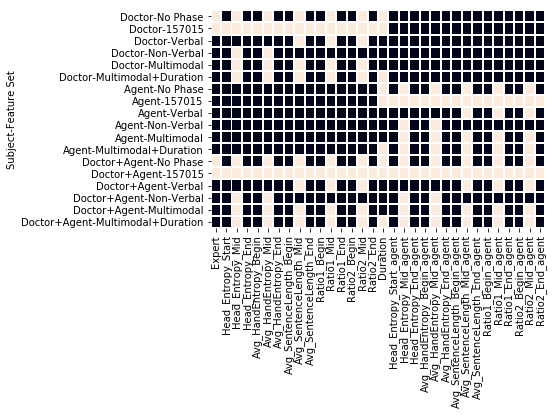

In [97]:


sns.heatmap(features_df.fillna(0).astype('int'), linecolor='white', linewidth=1, annot=False, cbar=False)
plt.savefig(os.path.join(config.OUT_PATH, 'features_sets.png'), bbox_inches = "tight")
plt.show()

# to avoid updating everything below for now

subject_features = get_features_set('Doctor', '157015')
agent_features = get_features_set('Agent', '157015')
all_features = get_features_set('Doctor+Agent', '157015')
subject_features_nophase = get_features_set('Doctor', 'No Phase')
agent_features_nophase = get_features_set('Agent', 'No Phase')
all_features_nophase = get_features_set('Doctor+Agent', 'No Phase')
subject_features_verbal = get_features_set('Doctor', 'Verbal')
agent_features_verbal = get_features_set('Agent', 'Verbal')
all_features_verbal = get_features_set('Doctor+Agent', 'Verbal')
subject_features_nonverbal = get_features_set('Doctor', 'Non-Verbal')
agent_features_nonverbal = get_features_set('Agent', 'Non-Verbal')
all_features_nonverbal = get_features_set('Doctor+Agent', 'Non-Verbal')
subject_features_multimodal = get_features_set('Doctor', 'Multimodal')
agent_features_multimodal = get_features_set('Agent', 'Multimodal')
all_features_multimodal = get_features_set('Doctor+Agent', 'Multimodal')
subject_features_multimodal_duration = get_features_set('Doctor', 'Multimodal+Duration')
agent_features_multimodal_duration = get_features_set('Agent', 'Multimodal+Duration')
all_features_multimodal_duration = get_features_set('Doctor+Agent', 'Multimodal+Duration')


## Utilities

In [125]:
out_path = os.path.join(config.OUT_PATH, 'gridsearchcv')
if not os.path.exists(out_path): os.makedirs(out_path)

class DataHandler():
    
    def __init__(self, root, iter=0):
        self.root = root
        self.root_path = os.path.join(config.OUT_PATH, '%s-%d' % (root,iter))
        self.iter = iter
        
    def get_grid_name(self, presence=True, doctor=True, agent=False, phases=None, classifier='RF'):
        pres = 'presence' if presence else 'copresence'
        subject = 'doctor' if doctor else ''
        subject = subject + ('agent' if agent else '')
        if phases is None or (phases is not None and type(phases) == tuple):
            if phases in [None, (0,1,0)]:
                ph = 'nophase'
            else:
                ph = '%02d%02d%02d' % ( phases[0]*100, phases[1]*100, phases[2]*100 )
        else:
            ph=phases
        return "%s_%s_%s_%s" % (pres, subject, ph, classifier)
            

    def save_grid(self, grid, folder, presence=True, doctor=True, agent=False, phases=None, classifier='RF'):
        name = "grid_%s" % (get_grid_name(presence, doctor, agent, phases, classifier))
        return self.save_obj(grid, folder, name)

    def load_grid(self, folder, presence=True, doctor=True, phases=None, classifier='RF'):
        name = "grid_%s" % (get_grid_name(presence, doctor, agent, phases, classifier))
        return self.load_obj(folder, name)

    def save_obj(self, obj, folder, name):
        """
        Saves an object to a file with pickle dump (under root folder, under 'folder', with name 'name'.pkl).
        Makes folders accordingly if they do not exist.
        """
        try:
            file_path = os.path.join(self.root_path, folder, name + '.pkl')
            if not os.path.exists(os.path.dirname(file_path)): os.makedirs(os.path.dirname(file_path))
            f_obj = open(file_path, 'wb')
            pickle.dump(obj, f_obj)
            f_obj.close()
        except Exception as e:
            print('Could not save file %s' % (file_path))
            print(e)
            return False
        return True

    def load_obj(self, folder, name):
        try:
            file_path = os.path.join(self.root_path, folder, name + '.pkl')
            f_obj = open(file_path, 'rb')
            obj = pickle.load(f_obj)
            f_obj.close()
        except Exception:
            print('file does not yet exist %s' % file_path)
            return None
        return obj
    
    def save_fig(self, title):
        try:
            path = os.path.join(self.root_path, 'figures', title+'.png')
            if not os.path.exists(os.path.dirname(path)): os.makedirs(os.path.dirname(path))
            plt.savefig(path, bbox_inches = "tight")
        except Exception as e:
            print('Could not save figure %s' % path)


def prepare_train_data(samples, features, target_model, upsample=False, verbose=0):
    if verbose > 0:
        print('prepare_train_data: target_model=%s, features=%s, upsamples=%s' % (target_model, features, upsample))
    names = features
    
    samples_split = []
    if (target_model == "presence"):
        samples_split.append(samples[samples.PresenceClass == 1])
        samples_split.append(samples[samples.PresenceClass == 2])
        samples_split.append(samples[samples.PresenceClass == 3])

    elif (target_model == "copresence"):
        samples_split.append(samples[samples.CopresenceClass == 1])
        samples_split.append(samples[samples.CopresenceClass == 2])
        samples_split.append(samples[samples.CopresenceClass == 3])
    else:
        sys.exit("Invalid input for target_model %s. Please pick between presence and copresence" % target_model)

    maxClassSize = max(samples_split[0].shape[0], samples_split[1].shape[0], samples_split[2].shape[0])

    if upsample:
        upsampled = []
        # todo upsample with SMOTE algorithm ? https://imbalanced-learn.readthedocs.io/en/stable/generated/imblearn.over_sampling.SMOTE.html
        for idx, samples in enumerate(samples_split):
            if (samples.shape[0] == maxClassSize):
                upsampled.append(samples)
            else:
                logger.debug("resample: adding " + str(maxClassSize - samples.shape[0]) + " samples to class " + str(
                    idx + 1) + " to reach " + str(maxClassSize))
                upsampled.append(resample(samples, replace=True, n_samples=maxClassSize, random_state=None))

        balanced_set = pd.concat(upsampled)
        X = np.nan_to_num(balanced_set.as_matrix(names))

        if (target_model == "presence"):
            y = np.array(balanced_set["PresenceClass"].tolist())

        else:
            y = np.array(balanced_set["CopresenceClass"].tolist())

    else:

        X = np.nan_to_num(samples[list(names)])
        if target_model == "presence":
            y = samples.PresenceClass
        else:
            y = samples.CopresenceClass
            
    return X, y

def gridsearch(clf, X, y, modelTarget, param_grid, features, upsample=False, verbose=0):
    if verbose > 0:
        print("gridsearch(clf=%s, modelTarget=%s, param_grid=%s, features=%s, upsample=%s)" 
              % (type(clf), modelTarget, param_grid, features, upsample))

    #X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
    #logger.debug("X_train ", X_train.shape, "X_test", X_test.shape, "y_train", y_train.shape, "y_test", y_test.shape)

  # todo move to beginning with other imports

    #n_estimators = np.concatenate((np.arange(1,10), np.arange(10,100,10)))
    print(np.unique(y, return_counts=True))
    grid = GridSearchCV(estimator=clf, param_grid=param_grid,
                        scoring=['f1_macro', 'precision_macro', 'recall_macro'],
                        refit='f1_macro',
                        cv=10,
                        return_train_score=True,
                        verbose=verbose)
    grid = grid.fit(X, y)

    results = grid.cv_results_
    # print("best params ", grid.best_params_)
    # print("best score ", grid.best_score_)

    return grid

# prepare results
def update_results_from_gridsearch(rdf, cv_results_, p1, p2, p3, p4, p5):
    df = pd.DataFrame(cv_results_)
    best_precision = df.mean_test_precision_macro.max()
    df_best = df.loc[df['mean_test_precision_macro'] == best_precision]
    if p5 == 'score':
        cols = [col for col in df_best.columns if ('mean_test_' in col)]
    elif p5 == 'err':
        cols = [col for col in df_best.columns if ('mean_std_' in col)]
    print('update_results_from_gridsearch: cols %s' % cols)
    update_results(rdf, df_best[cols], p1, p2, p3, p4, p5)
    return rdf

def update_results(rdf, df, p1, p2, p3, p4, p5):
    for i, col in enumerate(df.columns):
        rdf.loc[(p1, p2, p3, p4, p5), col] = df.iloc[0].loc[col]
    return rdf


def update_results_single(rdf, df, p1, p2, p3, p4, p5):
    for i, col in enumerate(df.columns):
        rdf.loc[(p1, p2, p3, p4, p5), col] = df.loc[col]
    return rdf

In [15]:
# from rfpimp

def dropcol_importances_sklearn(model, X_train, y_train, X_valid=None, y_valid=None, metric=None, sample_weights=None):
    """
    Compute drop-column feature importances for scikit-learn.

    Given a classifier or regression in model
    and training X and y data, return a data frame with columns
    Feature and Importance sorted in reverse order by importance.

    A clone of model is trained once to get the baseline score and then
    again, once per feature to compute the drop in either the model's .score() output
    or a custom metric callable in the form of metric(model, X_valid, y_valid).
    In case of a custom metric the X_valid and y_valid parameters should be set.
    return: A data frame with Feature, Importance columns

    SAMPLE CODE
    rf = RandomForestRegressor(n_estimators=100, n_jobs=-1)
    X_train, y_train = ..., ...
    rf.fit(X_train, y_train)
    imp = dropcol_importances(rf, X_train, y_train)
    """

    if X_valid is None: X_valid = X_train
    if y_valid is None: y_valid = y_train
    model_ = clone(model)
    #model_.random_state = RANDOM_STATE
    model_.fit(X_train, y_train)

    if callable(metric):
        baseline = metric(model_, X_valid, y_valid)
    else:
        baseline = model_.score(X_valid, y_valid)
    print("baseline " + str(baseline))
    imp = []
    for col in X_train.columns:
        print("column " + col)
        model__ = clone(model)
        #model__.random_state = RANDOM_STATE
        X_tr = X_train.drop(col, axis=1)
        X_va = X_valid.drop(col, axis=1)
        model__.fit(X_tr, y_train)
        if callable(metric):
            s = metric(model__, X_va, y_valid)
        else:
            s = model__.score(X_va, y_valid)
        print("new score " + str(s))
        drop_in_score = baseline - s
        imp.append(drop_in_score)

    imp = np.array(imp)

    #I = pd.DataFrame(data={'Feature':X_train.columns, 'Importance':imp})
    #I = I.set_index('Feature')
    #I = I.sort_values('Importance', ascending=False)
    
    return imp #I

def dropcol_importances(rf, X_train, y_train, random_state):
    rf_ = clone(rf)
    rf_.random_state = random_state
    rf_.fit(X_train, y_train)
    baseline = rf_.oob_score_
    #print("baseline " + str(baseline))
    imp = []
    for col in X_train.columns:
        X = X_train.drop(col, axis=1)
        rf_ = clone(rf)
        rf_.random_state = random_state
        rf_.fit(X, y_train)
        o = rf_.oob_score_
        imp.append(baseline - o)
    imp = np.array(imp)
    #I = pd.DataFrame(
    #        data={'Feature':X_train.columns,
    #              'Importance':imp})
    #I = I.set_index('Feature')
    #I = I.sort_values('Importance', ascending=True)
    return imp #I

### Random Forests - n_estimators evaluation
First for Random Forests Classifier, we study when out of bag score stabilizes for a range of n_estimators values.
We will use found n_estimator value with good balance between score and reliability, and performances.

Note: we hypothetize that we can find this value on a specific feature set (subject doctor, no phase) and use it for other sets of features, given overall domain and task remain similar.

In [7]:
def oob_score(estimator, X, y):
    """
    Custom scoring function for hyperparameter optimization. In this case, we want to print out the oob score.
    estimator was fitted on train data, X and y here are validation data.
    For OOB we don't need validation data - OOB is inherent to tree building.
    Same for feature importances (with default gini impurity measure done by sklearn).
    We add to this the 
    """
    score = estimator.oob_score_
    return score


X, y = prepare_train_data(subject_np_df, 'presence', subject_features_nophase, upsample=True)

n_estimators_range = np.arange(1,1000)#np.unique(np.logspace(0, 3, 300, dtype=int))
scores = []
errs = []
scoring = {
    'oob' : oob_score,
    'f1_macro' : 'f1_macro',
    'precision_macro' : 'precision_macro',
    'recall_macro' : 'recall_macro'         
}

from tqdm import tqdm, tqdm_notebook

pbar = tqdm_notebook(n_estimators_range, desc='n_estimators')
for i in pbar:
    pbar.set_description('n_estimators = %d / %s' % (i, n_estimators_range[-1]))
    clf = RandomForestClassifier(n_estimators=int(i), oob_score=True)
    result = cross_validate(clf, X, y, scoring=scoring, return_train_score=False, cv=10, verbose=0)
    scores.append(pd.DataFrame(result).mean().values)
    errs.append(pd.DataFrame(result).std().values)

SystemExit: Invalid input for target_model ['Expert', 'Head_Entropy_Mid', 'Avg_HandEntropy_Mid', 'Avg_SentenceLength_Mid', 'Ratio1_Mid', 'Ratio2_Mid', 'Duration']. Please pick between presence and copresence

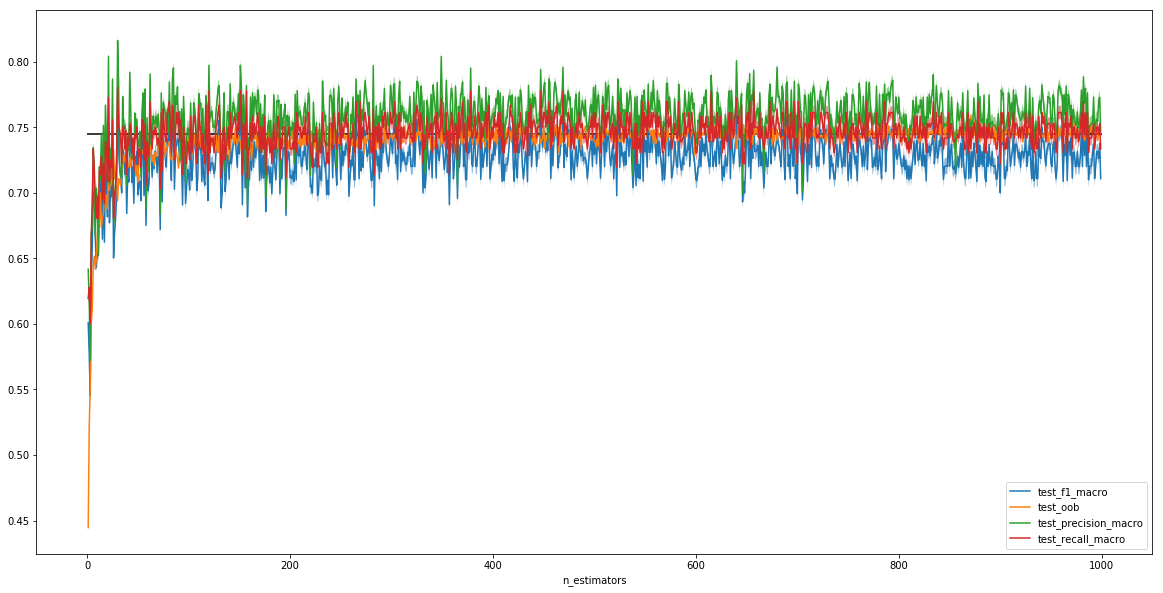

In [109]:
df = pd.DataFrame(scores, columns=pd.DataFrame(result).columns)
dferr = pd.DataFrame(errs, columns=pd.DataFrame(result).columns)
df = df.drop(['fit_time', 'score_time'], axis=1)
dferr = dferr.drop(['fit_time', 'score_time'], axis=1)
plt.figure(figsize=(20,10))
plt.hlines(y=df['test_oob'][400:].mean(), xmin=0.0, xmax=1000, color='black')
for key in df.columns:
    plt.plot(n_estimators_range, df[key], label=key)
    plt.fill_between(n_estimators_range, 
                     df[key]+(dferr[key]/np.sqrt(len(dferr))), 
                     df[key]-(dferr[key]/np.sqrt(len(dferr))),
                     alpha=0.5)
    plt.legend()
    plt.xlabel('n_estimators')

n_estimators = 300 seems to be an appropriate value, we will use it for further tests on random forests.

# Classification

In [16]:
def score_forest(estimator, X_, y_):
    """
    Custom scoring function for hyperparameter optimization. In this case, we want to print out the oob score.
    estimator was fitted on train data, X and y here are validation data.
    For OOB we don't need validation data - OOB is inherent to tree building.
    Same for feature importances (with default gini impurity measure done by sklearn).
    """
    all_feature_importances.append(estimator.feature_importances_) # global variable - ugly trick
    score = estimator.oob_score_
    #print "oob_score_:", score
    return score

def svm_fi(estimator, X_, y_):
    # for SVM dropcol feature importances computation, we use validation data (X_, y_) and train data (X, y) are global.
    #X_train_df = pd.DataFrame(X, columns=feats)
    #y_train_df = pd.DataFrame(y)
    #X_valid_df = pd.DataFrame(X_, columns=feats)
    #y_valid_df = pd.DataFrame(y_)
    #dcs = dropcol_importances_sklearn(clf, X_train_df, y_train_df, X_valid_df, y_valid_df)
    #all_dropcol_feature_importances.append(dcs)
    #print(dcs)
    return 0

def run_cross_val_score(clf, X, y, verbose=1):
    #print("gridsearch(clf=%s, modelTarget=%s, param_grid=%s, features=%s, upsample=%s)" 
    #      % (type(clf), modelTarget, param_grid, features, upsample))

    scoring = {
        'f1_macro' : 'f1_macro',
        'f1_macro_class_1': make_scorer(f1_score, labels=[1], average='macro'),
        'f1_macro_class_2': make_scorer(f1_score, labels=[2], average='macro'),
        'f1_macro_class_3': make_scorer(f1_score, labels=[3], average='macro'),
        'precision_macro' : 'precision_macro',
        'precision_macro_class_1': make_scorer(precision_score, labels=[1], average='macro'),
        'precision_macro_class_2': make_scorer(precision_score, labels=[2], average='macro'),
        'precision_macro_class_3': make_scorer(precision_score, labels=[3], average='macro'),
        'recall_macro' : 'recall_macro',
        'recall_macro_class_1': make_scorer(recall_score, labels=[1], average='macro'),
        'recall_macro_class_2': make_scorer(recall_score, labels=[2], average='macro'),
        'recall_macro_class_3': make_scorer(recall_score, labels=[3], average='macro')           
    }
    
    if type(clf) == RandomForestClassifier:
        scoring ['oob'] = score_forest
    else:
        scoring['fi'] = svm_fi
    
    return cross_validate(clf, X, y, scoring=scoring, cv=10, return_train_score=False, verbose=verbose)


def run_gridsearch(clf, param_grid, data, features, target_model, repeat=10, repeat_dc=300, upsample=True, fi=False, verbose=0):

    X, y = prepare_train_data(samples=data, features=features, target_model=target_model, upsample=True) 
    
    # first evaluate best params through grid search for this particular test
    grid = gridsearch(clf, 
                      X, y, 
                      'presence', 
                      param_grid=param_grid, 
                      features=features, 
                      upsample=True, 
                      verbose=verbose)
    best_params = grid.best_params_
    single_best_score = grid.best_score_

    print('  Gridsearch evaluated best score %s' % (single_best_score))
    print('    Running %d iterations on best classifier %s ...' % (repeat, best_params))

    all_scores = []
    global all_feature_importances
    global all_dropcol_feature_importances
    for i in np.arange(repeat):
        #forest = RandomForestClassifier(oob_score=True)
        # set best params to classifier

        clf.set_params(**best_params)

        scores = run_cross_val_score(clf, 
                          X, y,  
                          verbose=verbose)
        print("iter # %d" % i)
        #    print(scores)
        scores_df = pd.DataFrame(scores)
        #print(scores_df)
        #print(scores_df.columns)
        all_scores.append(scores_df)

    support = np.unique(y, return_counts=True)
        
    # compute feature importance for random forest : we don't need validation data as it relies on oob score
    if type(clf) == RandomForestClassifier:
        all_feature_importances = pd.DataFrame(all_feature_importances, columns=features)        
        if fi:
            X_ = pd.DataFrame(X, columns=features)
            y_ = pd.DataFrame(y)        
            for i in np.arange(repeat_dc):
                # alternative computation for feature importance
                all_dropcol_feature_importances.append(dropcol_importances(clf, X_, y_, RANDOM_STATE+i))
    else:
        all_feature_importances = None
        all_dropcol_feature_importances = None
        '''print(X, y)
        skf = StratifiedKFold(n_splits=repeat, random_state=RANDOM_STATE, shuffle=True)
        for i in np.arange(repeat_dc):
            for train_index, test_index in skf.split(X, y):
                X_train, X_test = X[train_index], X[test_index]
                y_train, y_test = y[train_index], y[test_index]
                X_train = pd.DataFrame(X_train, columns=features)
                X_test = pd.DataFrame(X_test, columns=features)
                y_train = pd.DataFrame(y_train)
                y_test = pd.DataFrame(y_test)
                # alternative computation for feature importance
                dcs = dropcol_importances_sklearn(clf, X_train, y_train, X_test, y_test, RANDOM_STATE+i)
                print("X_train %s X_test %s y_train %s y_test %s" % (len(X_train), len(X_test), len(y_train), len(y_test)))
                print(dcs)
                all_dropcol_feature_importances.append(dcs)'''

    all_scores = pd.concat(all_scores)
    if all_dropcol_feature_importances is not None:
        all_dropcol_feature_importances = pd.DataFrame(all_dropcol_feature_importances, columns=features)

    return grid, all_scores, all_dropcol_feature_importances, all_feature_importances, support


In [17]:
def plot_importance(title, importances, importances_err, feature_names, sort=True):
    # Sort feature importances in descending order
    if sort:
        indices = np.argsort(importances)[::-1]
    else:
        indices = np.arange(len(feature_names))

    # Rearrange feature names so they match the sorted feature importances
    names = [feature_names[i] for i in indices]
    if importances_err is not None:
        errs = [importances_err[i] for i in indices]

    # Create plot
    plt.figure()

    # Create plot title
    plt.title("Feature Importance - " + title)

    # Add bars
    if importances_err is not None:
        plt.bar(range(len(feature_names)), importances[indices], yerr=errs, xerr=0.1)
    else:
        plt.bar(range(len(feature_names)), importances[indices])

    # Add feature names as x-axis labels
    plt.xticks(range(len(feature_names)), names, rotation=90)

    dh.save_fig(title)
    #plt.savefig(os.path.join(dh.root_path, 'figures', title+'.png'))
    plt.show()


# Subject and Agent features, phases and no phase

In [98]:
# prepare results dataframes

dh = DataHandler('1-subject-agent_phases-nophase', 2)

scores_df_index = [['Presence', 'Co-Presence'], 
             ['Doctor', 'Agent', 'Doctor+Agent'], 
             ['No Phase', '157015'], 
             ['Random Forests', 'SVM'],
             ['score', 'err']
            ]
scores_df_columns = ['precision', 'f1', 'recall', 'params']
scores_df_multiindex = pd.MultiIndex.from_product(scores_df_index, 
                                                  names=['Metric', 'Subject', 'Phases', 'Classifier', 'Metric'])

scores_df = dh.load_obj('results', 'scores')
print(len(scores_df_multiindex.to_flat_index()))
if scores_df is None:
    scores_df = pd.DataFrame(index=scores_df_multiindex)
    #scores_df = pd.DataFrame(np.zeros((len(scores_df_multiindex.to_flat_index()),4)), 
    #                         index=scores_df_multiindex, 
    #                         columns=scores_df_columns)
    #scores_df['params'] = scores_df['params'].apply(str)
    #scores_df['params'] = ''
    dh.save_obj(scores_df, 'results', 'scores')
    
context_df = dh.load_obj('.', 'context')
if context_df is None:
    context_df = pd.DataFrame(index=scores_df_multiindex)
    context_df['Best Params'] = ''
    context_df['Best Params'] = context_df['Best Params'].apply(str)
    dh.save_obj(context_df, '.', 'context')
    
scores_df

file does not yet exist C:\IAAA\TER\_output\1-subject-agent_phases-nophase-2\results\scores.pkl
48
file does not yet exist C:\IAAA\TER\_output\1-subject-agent_phases-nophase-2\.\context.pkl


Empty DataFrame
Columns: []
Index: [(Presence, Doctor, No Phase, Random Forests, score), (Presence, Doctor, No Phase, Random Forests, err), (Presence, Doctor, No Phase, SVM, score), (Presence, Doctor, No Phase, SVM, err), (Presence, Doctor, 157015, Random Forests, score), (Presence, Doctor, 157015, Random Forests, err), (Presence, Doctor, 157015, SVM, score), (Presence, Doctor, 157015, SVM, err), (Presence, Agent, No Phase, Random Forests, score), (Presence, Agent, No Phase, Random Forests, err), (Presence, Agent, No Phase, SVM, score), (Presence, Agent, No Phase, SVM, err), (Presence, Agent, 157015, Random Forests, score), (Presence, Agent, 157015, Random Forests, err), (Presence, Agent, 157015, SVM, score), (Presence, Agent, 157015, SVM, err), (Presence, Doctor+Agent, No Phase, Random Forests, score), (Presence, Doctor+Agent, No Phase, Random Forests, err), (Presence, Doctor+Agent, No Phase, SVM, score), (Presence, Doctor+Agent, No Phase, SVM, err), (Presence, Doctor+Agent, 157015, Random Forests, score), (Presence, Doctor+Agent, 157015, Random Forests, err), (Presence, Doctor+Agent, 157015, SVM, score), (Presence, Doctor+Agent, 157015, SVM, err), (Co-Presence, Doctor, No Phase, Random Forests, score), (Co-Presence, Doctor, No Phase, Random Forests, err), (Co-Presence, Doctor, No Phase, SVM, score), (Co-Presence, Doctor, No Phase, SVM, err), (Co-Presence, Doctor, 157015, Random Forests, score), (Co-Presence, Doctor, 157015, Random Forests, err), (Co-Presence, Doctor, 157015, SVM, score), (Co-Presence, Doctor, 157015, SVM, err), (Co-Presence, Agent, No Phase, Random Forests, score), (Co-Presence, Agent, No Phase, Random Forests, err), (Co-Presence, Agent, No Phase, SVM, score), (Co-Presence, Agent, No Phase, SVM, err), (Co-Presence, Agent, 157015, Random Forests, score), (Co-Presence, Agent, 157015, Random Forests, err), (Co-Presence, Agent, 157015, SVM, score), (Co-Presence, Agent, 157015, SVM, err), (Co-Presence, Doctor+Agent, No Phase, Random Forests, score), (Co-Presence, Doctor+Agent, No Phase, Random Forests, err), (Co-Presence, Doctor+Agent, No Phase, SVM, score), (Co-Presence, Doctor+Agent, No Phase, SVM, err), (Co-Presence, Doctor+Agent, 157015, Random Forests, score), (Co-Presence, Doctor+Agent, 157015, Random Forests, err), (Co-Presence, Doctor+Agent, 157015, SVM, score), (Co-Presence, Doctor+Agent, 157015, SVM, err)]

### Test plan definition

In [99]:
from sklearn.model_selection import ParameterGrid
test_plan_params = {
    'classifier': ['forest', 'svm'],
    'subject': ['doctor+agent', 'doctor', 'agent'],
    'target': ['presence', 'copresence'],
    'phases': [(0,1,0), (0.15,0.70,0.15)]
}
test_plan = list(ParameterGrid(test_plan_params))
print("%d tests to be performed" % len(test_plan))
for test in test_plan:
    print(test)

24 tests to be performed
{'phases': (0, 1, 0), 'target': 'presence', 'classifier': 'forest', 'subject': 'doctor+agent'}
{'phases': (0, 1, 0), 'target': 'copresence', 'classifier': 'forest', 'subject': 'doctor+agent'}
{'phases': (0, 1, 0), 'target': 'presence', 'classifier': 'forest', 'subject': 'doctor'}
{'phases': (0, 1, 0), 'target': 'copresence', 'classifier': 'forest', 'subject': 'doctor'}
{'phases': (0, 1, 0), 'target': 'presence', 'classifier': 'forest', 'subject': 'agent'}
{'phases': (0, 1, 0), 'target': 'copresence', 'classifier': 'forest', 'subject': 'agent'}
{'phases': (0.15, 0.7, 0.15), 'target': 'presence', 'classifier': 'forest', 'subject': 'doctor+agent'}
{'phases': (0.15, 0.7, 0.15), 'target': 'copresence', 'classifier': 'forest', 'subject': 'doctor+agent'}
{'phases': (0.15, 0.7, 0.15), 'target': 'presence', 'classifier': 'forest', 'subject': 'doctor'}
{'phases': (0.15, 0.7, 0.15), 'target': 'copresence', 'classifier': 'forest', 'subject': 'doctor'}
{'phases': (0.15, 0.7

## Gridsearch hyper-parameters ranges

In [20]:
# random forests
param_grid_rf =  {
    'n_estimators' : [300],
    'max_features': [None, 'sqrt', 'log2'],
    "max_depth": [None, 2, 5, 10],
    "min_samples_leaf": [1, 5, 10]
}
# for quickly testing the loops
param_grid_rf_tests = {
    'n_estimators' : [10],
    'max_features': [None],
    "max_depth": [None],
    "min_samples_leaf": [1]
}

# SVM
param_grid_svm = {
    'svc__kernel': ['linear', 'rbf', 'sigmoid'],
    'svc__C': np.logspace(-2, 1, 4),
    'svc__gamma': np.logspace(-3, 1, 5)
}

### Run

Test 0 : {'phases': (0, 1, 0), 'target': 'presence', 'classifier': 'forest', 'subject': 'doctor+agent'}
No phase
(array([1, 2, 3], dtype=int64), array([35, 35, 35]))
  Gridsearch evaluated best score 0.7368934240362811
    Running 10 iterations on best classifier {'max_features': 'sqrt', 'n_estimators': 300, 'max_depth': 5, 'min_samples_leaf': 1} ...
iter # 0
iter # 1
iter # 2
iter # 3
iter # 4
iter # 5
iter # 6
iter # 7
iter # 8
iter # 9
      updating scores for presence_doctoragent_0010000_forest


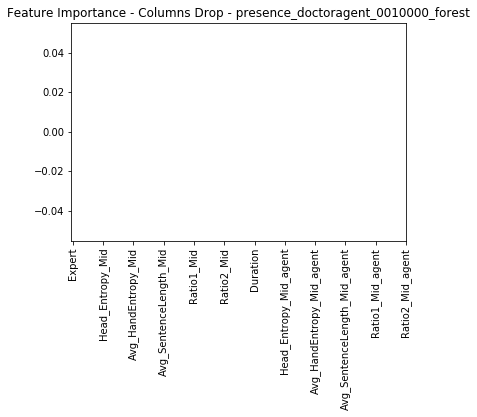

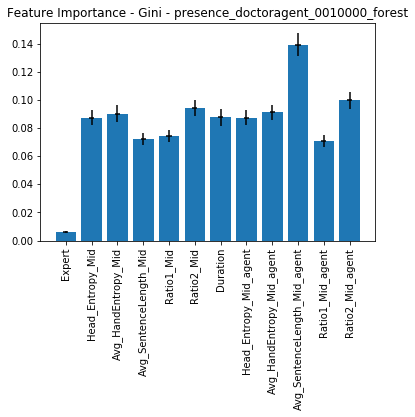

Test 1 : {'phases': (0, 1, 0), 'target': 'copresence', 'classifier': 'forest', 'subject': 'doctor+agent'}
No phase
(array([1, 2, 3], dtype=int64), array([36, 36, 36]))
  Gridsearch evaluated best score 0.8935405643738976
    Running 10 iterations on best classifier {'max_features': 'sqrt', 'n_estimators': 300, 'max_depth': 5, 'min_samples_leaf': 1} ...
iter # 0
iter # 1
iter # 2
iter # 3
iter # 4
iter # 5
iter # 6
iter # 7
iter # 8
iter # 9
      updating scores for presence_doctoragent_0010000_forest


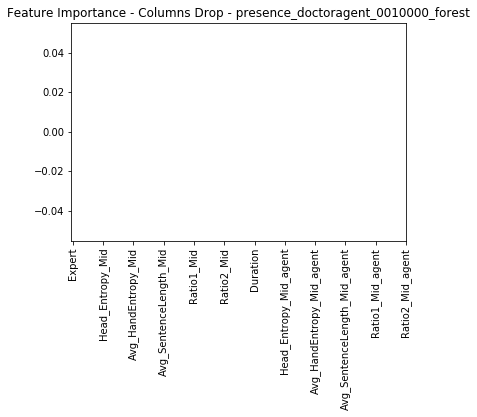

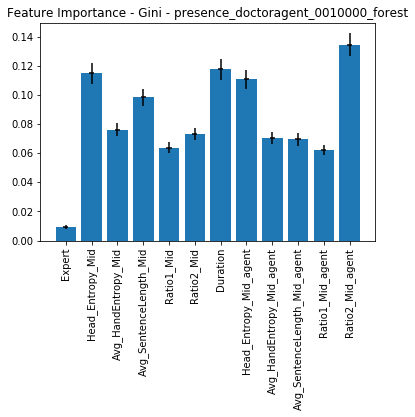

Test 2 : {'phases': (0, 1, 0), 'target': 'presence', 'classifier': 'forest', 'subject': 'doctor'}
No phase
(array([1, 2, 3], dtype=int64), array([35, 35, 35]))
  Gridsearch evaluated best score 0.7580498866213152
    Running 10 iterations on best classifier {'max_features': None, 'n_estimators': 300, 'max_depth': None, 'min_samples_leaf': 1} ...
iter # 0
iter # 1
iter # 2
iter # 3
iter # 4
iter # 5
iter # 6
iter # 7
iter # 8
iter # 9
      updating scores for presence_doctor_0010000_forest


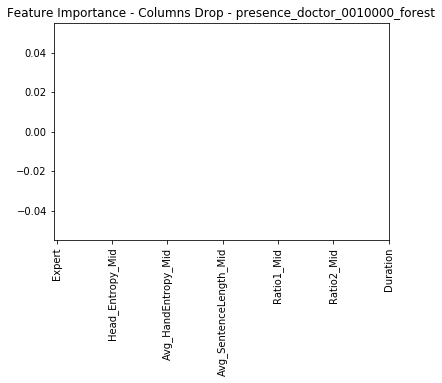

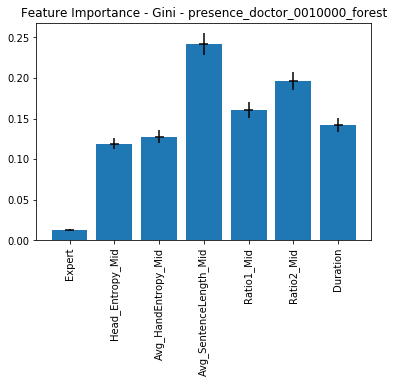

Test 3 : {'phases': (0, 1, 0), 'target': 'copresence', 'classifier': 'forest', 'subject': 'doctor'}
No phase
(array([1, 2, 3], dtype=int64), array([36, 36, 36]))
  Gridsearch evaluated best score 0.7189480786703009
    Running 10 iterations on best classifier {'max_features': 'sqrt', 'n_estimators': 300, 'max_depth': 10, 'min_samples_leaf': 1} ...
iter # 0
iter # 1
iter # 2
iter # 3
iter # 4
iter # 5
iter # 6
iter # 7
iter # 8
iter # 9
      updating scores for presence_doctor_0010000_forest


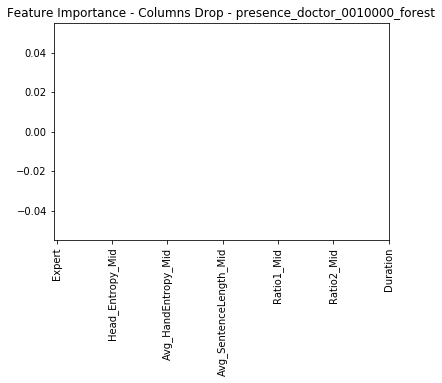

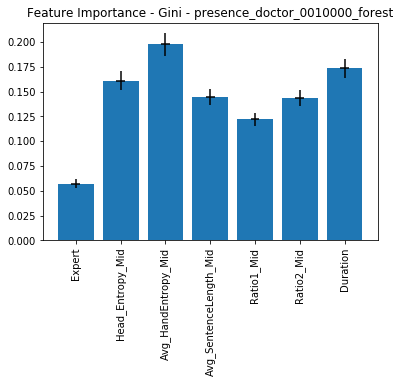

Test 4 : {'phases': (0, 1, 0), 'target': 'presence', 'classifier': 'forest', 'subject': 'agent'}
No phase
(array([1, 2, 3], dtype=int64), array([35, 35, 35]))
  Gridsearch evaluated best score 0.7112773998488284
    Running 10 iterations on best classifier {'max_features': None, 'n_estimators': 300, 'max_depth': 10, 'min_samples_leaf': 1} ...
iter # 0
iter # 1
iter # 2
iter # 3
iter # 4
iter # 5
iter # 6
iter # 7
iter # 8
iter # 9
      updating scores for presence_agent_0010000_forest


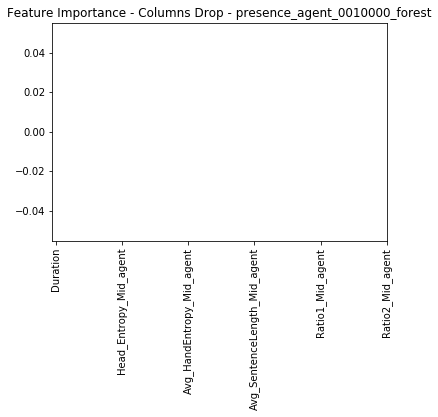

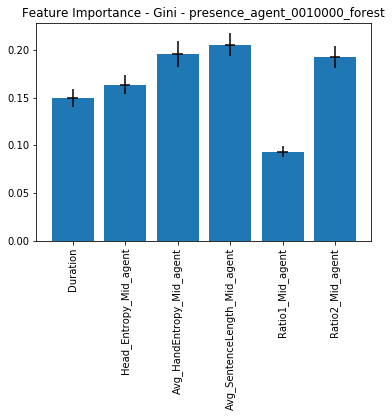

Test 5 : {'phases': (0, 1, 0), 'target': 'copresence', 'classifier': 'forest', 'subject': 'agent'}
No phase
(array([1, 2, 3], dtype=int64), array([36, 36, 36]))
  Gridsearch evaluated best score 0.819216637272193
    Running 10 iterations on best classifier {'max_features': 'sqrt', 'n_estimators': 300, 'max_depth': None, 'min_samples_leaf': 1} ...
iter # 0
iter # 1
iter # 2
iter # 3
iter # 4
iter # 5
iter # 6
iter # 7
iter # 8
iter # 9
      updating scores for presence_agent_0010000_forest


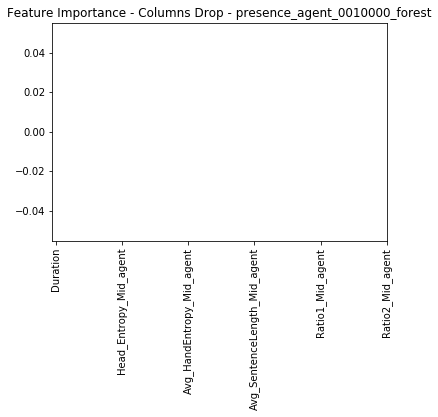

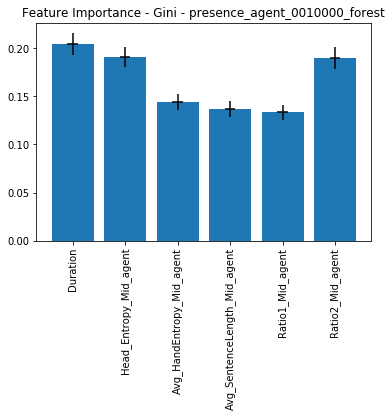

Test 6 : {'phases': (0.15, 0.7, 0.15), 'target': 'presence', 'classifier': 'forest', 'subject': 'doctor+agent'}
phases (0.15, 0.7, 0.15)
(array([1, 2, 3], dtype=int64), array([35, 35, 35]))
  Gridsearch evaluated best score 0.7742403628117913
    Running 10 iterations on best classifier {'max_features': 'sqrt', 'n_estimators': 300, 'max_depth': None, 'min_samples_leaf': 1} ...
iter # 0
iter # 1
iter # 2
iter # 3
iter # 4
iter # 5
iter # 6
iter # 7
iter # 8
iter # 9
      updating scores for presence_doctoragent_157015_forest


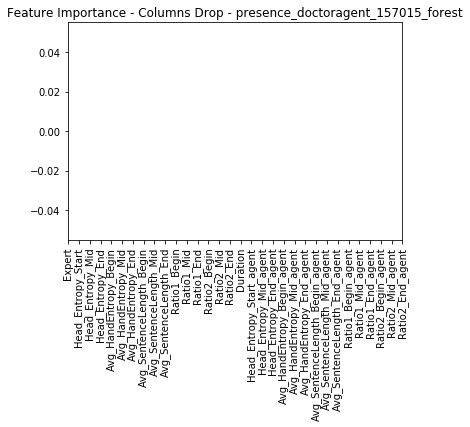

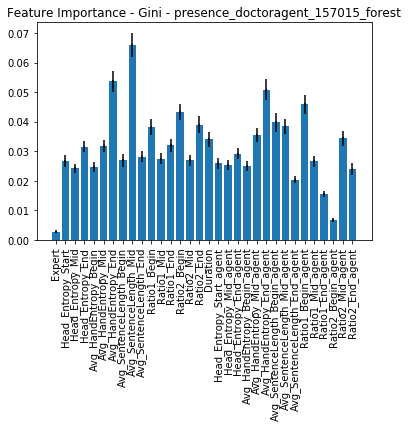

Test 7 : {'phases': (0.15, 0.7, 0.15), 'target': 'copresence', 'classifier': 'forest', 'subject': 'doctor+agent'}
phases (0.15, 0.7, 0.15)
(array([1, 2, 3], dtype=int64), array([36, 36, 36]))
  Gridsearch evaluated best score 0.8477219282774838
    Running 10 iterations on best classifier {'max_features': 'sqrt', 'n_estimators': 300, 'max_depth': None, 'min_samples_leaf': 1} ...
iter # 0
iter # 1
iter # 2
iter # 3
iter # 4
iter # 5
iter # 6
iter # 7
iter # 8
iter # 9
      updating scores for presence_doctoragent_157015_forest


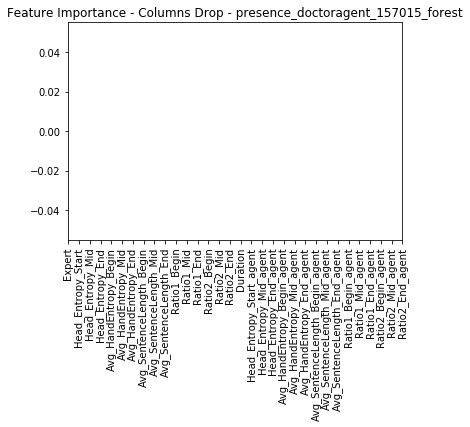

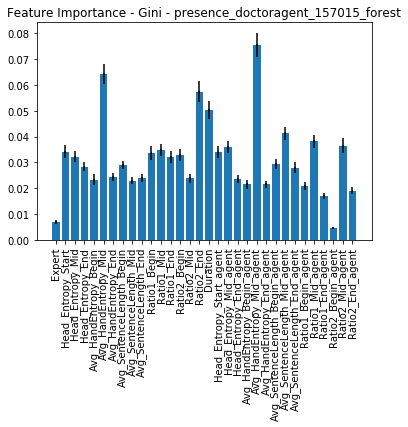

Test 8 : {'phases': (0.15, 0.7, 0.15), 'target': 'presence', 'classifier': 'forest', 'subject': 'doctor'}
phases (0.15, 0.7, 0.15)
(array([1, 2, 3], dtype=int64), array([35, 35, 35]))
  Gridsearch evaluated best score 0.7327774342060056
    Running 10 iterations on best classifier {'max_features': None, 'n_estimators': 300, 'max_depth': None, 'min_samples_leaf': 1} ...
iter # 0
iter # 1
iter # 2
iter # 3
iter # 4
iter # 5
iter # 6
iter # 7
iter # 8
iter # 9
      updating scores for presence_doctor_157015_forest


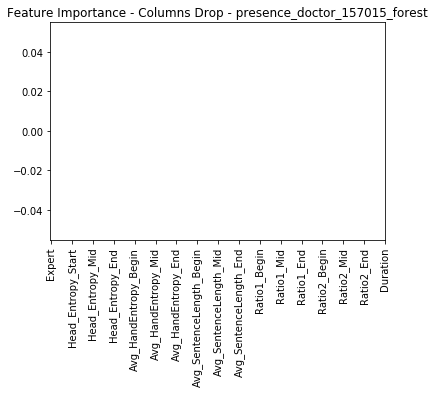

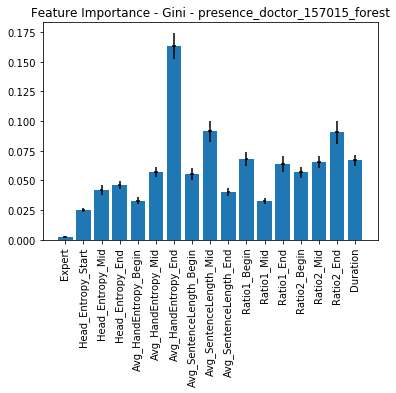

Test 9 : {'phases': (0.15, 0.7, 0.15), 'target': 'copresence', 'classifier': 'forest', 'subject': 'doctor'}
phases (0.15, 0.7, 0.15)
(array([1, 2, 3], dtype=int64), array([36, 36, 36]))
  Gridsearch evaluated best score 0.7541960611405054
    Running 10 iterations on best classifier {'max_features': 'sqrt', 'n_estimators': 300, 'max_depth': None, 'min_samples_leaf': 1} ...
iter # 0
iter # 1
iter # 2
iter # 3
iter # 4
iter # 5
iter # 6
iter # 7
iter # 8
iter # 9
      updating scores for presence_doctor_157015_forest


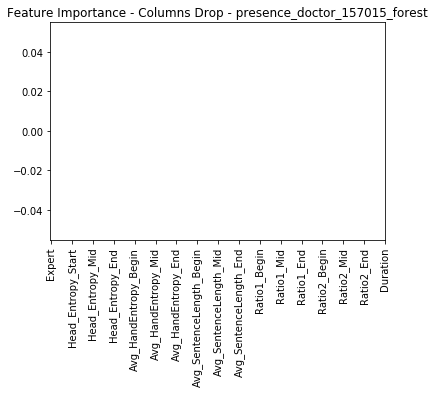

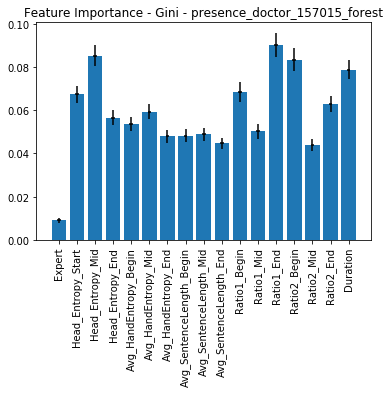

Test 10 : {'phases': (0.15, 0.7, 0.15), 'target': 'presence', 'classifier': 'forest', 'subject': 'agent'}
phases (0.15, 0.7, 0.15)
(array([1, 2, 3], dtype=int64), array([35, 35, 35]))
  Gridsearch evaluated best score 0.7263753178038892
    Running 10 iterations on best classifier {'max_features': None, 'n_estimators': 300, 'max_depth': None, 'min_samples_leaf': 1} ...
iter # 0
iter # 1
iter # 2
iter # 3
iter # 4
iter # 5
iter # 6
iter # 7
iter # 8
iter # 9
      updating scores for presence_agent_157015_forest


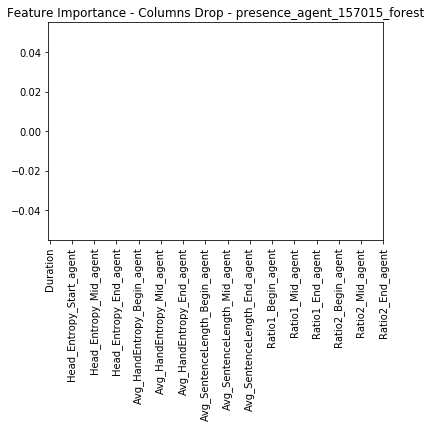

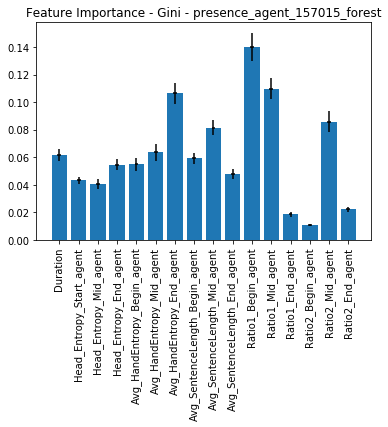

Test 11 : {'phases': (0.15, 0.7, 0.15), 'target': 'copresence', 'classifier': 'forest', 'subject': 'agent'}
phases (0.15, 0.7, 0.15)
(array([1, 2, 3], dtype=int64), array([36, 36, 36]))
  Gridsearch evaluated best score 0.7474279835390947
    Running 10 iterations on best classifier {'max_features': 'sqrt', 'n_estimators': 300, 'max_depth': None, 'min_samples_leaf': 1} ...
iter # 0
iter # 1
iter # 2
iter # 3
iter # 4
iter # 5
iter # 6
iter # 7
iter # 8
iter # 9
      updating scores for presence_agent_157015_forest


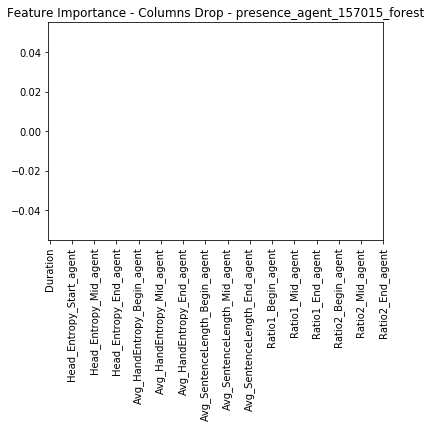

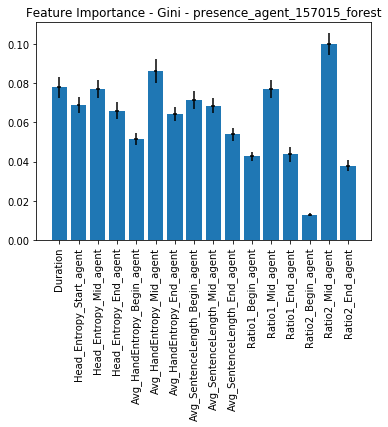

Test 12 : {'phases': (0, 1, 0), 'target': 'presence', 'classifier': 'svm', 'subject': 'doctor+agent'}
No phase
(array([1, 2, 3], dtype=int64), array([35, 35, 35]))
  Gridsearch evaluated best score 0.7775578918436062
    Running 10 iterations on best classifier {'svc__gamma': 10.0, 'svc__kernel': 'rbf', 'svc__C': 1.0} ...
iter # 0
iter # 1
iter # 2
iter # 3
iter # 4
iter # 5
iter # 6
iter # 7
iter # 8
iter # 9
      updating scores for presence_doctoragent_0010000_svm
Test 13 : {'phases': (0, 1, 0), 'target': 'copresence', 'classifier': 'svm', 'subject': 'doctor+agent'}
No phase
(array([1, 2, 3], dtype=int64), array([36, 36, 36]))
  Gridsearch evaluated best score 0.8789789428678318
    Running 10 iterations on best classifier {'svc__gamma': 1.0, 'svc__kernel': 'rbf', 'svc__C': 1.0} ...
iter # 0
iter # 1
iter # 2
iter # 3
iter # 4
iter # 5
iter # 6
iter # 7
iter # 8
iter # 9
      updating scores for presence_doctoragent_0010000_svm
Test 14 : {'phases': (0, 1, 0), 'target': 'presence',

In [100]:
forest = RandomForestClassifier(random_state=RANDOM_STATE, oob_score=True)
svm = make_pipeline(StandardScaler(), SVC(random_state=RANDOM_STATE))


# parameters
repeat = 10
repeat_dc = 300
cv = 10
fi = False # whether to compute dropcol feature importance or not
upsample=True
verbose=0

for idx, test in enumerate(test_plan):
    print("Test %d : %s" % (idx, test))
    
    # make it global because we use them to compute feature importance for forests
    all_feature_importances = []    
    all_dropcol_feature_importances = []

    subject = test['subject']
    target = test['target']
    phases = test['phases']
    classifier = test['classifier']
    clf = forest if classifier == 'forest' else svm
    pgrid = param_grid_rf if classifier == 'forest' else param_grid_svm

    if phases is not None and not phases == (0,1,0):
        print("phases " + str(phases))
        if subject == 'doctor':
            df = subject_p_df
            feats = subject_features
        elif subject == 'agent':
            df = agent_p_df
            feats = agent_features
        elif subject == 'doctor+agent':
            df = all_p_df
            feats=all_features
    else:
        print("No phase")
        if subject == 'doctor':
            df = subject_np_df
            feats = subject_features_nophase
        elif subject == 'agent':
            df = agent_np_df
            feats = agent_features_nophase
        elif subject == 'doctor+agent':
            df = all_np_df
            feats=all_features_nophase   

    start = time.time()
            
    X, y = prepare_train_data(samples=df, features=feats, target_model=target, upsample=upsample) 
    grid, scores, dropcol_fis, fis, support = run_gridsearch(clf, 
                                                    pgrid, 
                                                    df, feats, 
                                                    target, 
                                                    repeat=repeat, repeat_dc=repeat_dc, 
                                                    upsample=upsample, 
                                                    verbose=verbose)

    elapsed = time.time() - start
    
    isDoc = 'doctor' in subject
    isAgent = 'agent' in subject
    #save_grid(grid, presence=target=='presence', doctor=isDoc, agent=isAgent,
    #         phases=phases, classifier='RF' if test['classifier']=='forest' else 'SVM')

    presidx = 'Presence' if target == 'presence' else 'Co-Presence'
    if subject == 'doctor':
        subjidx = 'Doctor'
    elif subject == 'agent':
        subjidx = 'Agent'
    else:
        subjidx = 'Doctor+Agent'
    phidx = 'No Phase' if phases in [None, (0,1,0)] else '%2d%2d%2d' % ( phases[0]*100, phases[1]*100, phases[2]*100 )
    clfidx = 'Random Forests' if classifier == 'forest' else 'SVM'

    # compute err
    all_scores_ = scores.drop(['fit_time', 'score_time'], axis=1).T
    final = pd.DataFrame(index=all_scores_.index)
    final['means'] = all_scores_.mean(axis=1)
    final['std'] = all_scores_.std(axis=1)

    test_set_name = dh.get_grid_name(target, isDoc, isAgent, phases, classifier)
    print("      updating scores for %s" % test_set_name)
    #print("final" , final)
    scores_df = update_results(scores_df, pd.DataFrame(final.T.loc['means']).T, presidx, subjidx, phidx, clfidx, 'score')
    scores_df = update_results(scores_df, pd.DataFrame(final.T.loc['std']).T, presidx, subjidx, phidx, clfidx, 'err')    
    dh.save_obj(scores_df, 'results', 'scores')
    
    dumpPath = os.path.join(dh.root_path, 'results', 'scores.xlsx')
    scores_df.to_excel(dumpPath, index=True)
    
    ctx = [[upsample, cv, repeat, repeat_dc, grid.best_params_, elapsed, support, feats], [0,0,0,0,0,0,0,0]]
    ctx_df = pd.DataFrame(ctx, columns=['UpSample', 'KFolds K', 'KFolds repetitions', 'Repetitions for features importance',
                     'Best Params', 'Time (s)', 'Support', 'Features'])
    for col in ctx_df.columns:
        if col in ['Best Params', 'Support', 'Features']:
            context_df.loc[(presidx, subjidx, phidx, clfidx, 'score'), col] = str(ctx_df[col][0])
        else:
            #print("col %s" % col)
            context_df.loc[(presidx, subjidx, phidx, clfidx, 'score'), col] = ctx_df[col][0]
    dumpPath = os.path.join(dh.root_path, '.',  'context.csv')
    context_df.to_csv(dumpPath, index=True)
    

    # features importances
    if dropcol_fis is not None:
        final_fi = dropcol_fis.T
        final_fi['means'] = final_fi.mean(axis=1)
        final_fi['std'] = final_fi.std(axis=1)
        final_fi['sem'] = final_fi.sem(axis=1)
        final_fi['confidence'] = final_fi.apply(lambda row : 2*(np.mean(row) - st.t.interval(0.95, len(row)-1, loc=np.mean(row), scale=st.sem(row))[0]) , axis = 1)
        plot_importance('Columns Drop - ' + test_set_name, 
                        final_fi['means'],
                        final_fi['confidence'],
                        feats, 
                        sort=False)
        dumpPath = os.path.join(dh.root_path, 'results', 'features_importances_dropcol_%s.xlsx' % test_set_name)
        final_fi.to_excel(dumpPath, index=True)


    if fis is not None:
        final_fi_ = fis.T
        final_fi_['means'] = final_fi_.mean(axis=1)
        final_fi_['std'] = final_fi_.std(axis=1)
        final_fi_['sem'] = final_fi_.sem(axis=1)
        final_fi_['confidence'] = final_fi_.apply(lambda row : 2*(np.mean(row) - st.t.interval(0.95, len(row)-1, loc=np.mean(row), scale=st.sem(row))[0]) , axis = 1)
        plot_importance('Gini - ' + test_set_name, 
                        final_fi_['means'],
                        final_fi_['confidence'],
                        feats, 
                        sort=False)
        dumpPath = os.path.join(dh.root_path, 'results', 'features_importances_%s.xlsx' % test_set_name)
        final_fi.to_excel(dumpPath, index=True)


### Results summary

In [156]:
clf.fit(X,y)
print(clf.score(X, y))

1.0


# Verbal, non-verbal, multi-modal and multi-modal + duration

In [32]:
# prepare results dataframes

dh = DataHandler('2-verbal-nonverbal-multimodal-duration', 1)

scores_df_index = [['Presence', 'Co-Presence'], 
             ['Doctor', 'Agent', 'Doctor+Agent'], 
             ['Verbal', 'Non-Verbal', 'Multimodal', 'Multimodal+Duration'], 
             ['Random Forests', 'SVM'],
             ['score', 'err']
            ]
scores_df_multiindex = pd.MultiIndex.from_product(scores_df_index, 
                                                  names=['Metric', 'Subject', 'Mode', 'Classifier', 'Metric'])

scores_df = dh.load_obj('results', 'scores')
print(len(scores_df_multiindex.to_flat_index()))
if scores_df is None:
    scores_df = pd.DataFrame(index=scores_df_multiindex)
    #scores_df = pd.DataFrame(np.zeros((len(scores_df_multiindex.to_flat_index()),4)), 
    #                         index=scores_df_multiindex, 
    #                         columns=scores_df_columns)
    #scores_df['params'] = scores_df['params'].apply(str)
    #scores_df['params'] = ''
    dh.save_obj(scores_df, 'results', 'scores')
    
    
context_df = dh.load_obj('.', 'context')
if context_df is None:
    context_df = pd.DataFrame(index=scores_df_multiindex)
    context_df['Best Params'] = ''
    context_df['Best Params'] = context_df['Best Params'].apply(str)
    dh.save_obj(context_df, '.', 'context')
    
scores_df

file does not yet exist C:\IAAA\TER\_output\2-verbal-nonverbal-multimodal-duration-1\results\scores.pkl
96
file does not yet exist C:\IAAA\TER\_output\2-verbal-nonverbal-multimodal-duration-1\.\context.pkl


Empty DataFrame
Columns: []
Index: [(Presence, Doctor, Verbal, Random Forests, score), (Presence, Doctor, Verbal, Random Forests, err), (Presence, Doctor, Verbal, SVM, score), (Presence, Doctor, Verbal, SVM, err), (Presence, Doctor, Non-Verbal, Random Forests, score), (Presence, Doctor, Non-Verbal, Random Forests, err), (Presence, Doctor, Non-Verbal, SVM, score), (Presence, Doctor, Non-Verbal, SVM, err), (Presence, Doctor, Multimodal, Random Forests, score), (Presence, Doctor, Multimodal, Random Forests, err), (Presence, Doctor, Multimodal, SVM, score), (Presence, Doctor, Multimodal, SVM, err), (Presence, Doctor, Multimodal+Duration, Random Forests, score), (Presence, Doctor, Multimodal+Duration, Random Forests, err), (Presence, Doctor, Multimodal+Duration, SVM, score), (Presence, Doctor, Multimodal+Duration, SVM, err), (Presence, Agent, Verbal, Random Forests, score), (Presence, Agent, Verbal, Random Forests, err), (Presence, Agent, Verbal, SVM, score), (Presence, Agent, Verbal, SVM, err), (Presence, Agent, Non-Verbal, Random Forests, score), (Presence, Agent, Non-Verbal, Random Forests, err), (Presence, Agent, Non-Verbal, SVM, score), (Presence, Agent, Non-Verbal, SVM, err), (Presence, Agent, Multimodal, Random Forests, score), (Presence, Agent, Multimodal, Random Forests, err), (Presence, Agent, Multimodal, SVM, score), (Presence, Agent, Multimodal, SVM, err), (Presence, Agent, Multimodal+Duration, Random Forests, score), (Presence, Agent, Multimodal+Duration, Random Forests, err), (Presence, Agent, Multimodal+Duration, SVM, score), (Presence, Agent, Multimodal+Duration, SVM, err), (Presence, Doctor+Agent, Verbal, Random Forests, score), (Presence, Doctor+Agent, Verbal, Random Forests, err), (Presence, Doctor+Agent, Verbal, SVM, score), (Presence, Doctor+Agent, Verbal, SVM, err), (Presence, Doctor+Agent, Non-Verbal, Random Forests, score), (Presence, Doctor+Agent, Non-Verbal, Random Forests, err), (Presence, Doctor+Agent, Non-Verbal, SVM, score), (Presence, Doctor+Agent, Non-Verbal, SVM, err), (Presence, Doctor+Agent, Multimodal, Random Forests, score), (Presence, Doctor+Agent, Multimodal, Random Forests, err), (Presence, Doctor+Agent, Multimodal, SVM, score), (Presence, Doctor+Agent, Multimodal, SVM, err), (Presence, Doctor+Agent, Multimodal+Duration, Random Forests, score), (Presence, Doctor+Agent, Multimodal+Duration, Random Forests, err), (Presence, Doctor+Agent, Multimodal+Duration, SVM, score), (Presence, Doctor+Agent, Multimodal+Duration, SVM, err), (Co-Presence, Doctor, Verbal, Random Forests, score), (Co-Presence, Doctor, Verbal, Random Forests, err), (Co-Presence, Doctor, Verbal, SVM, score), (Co-Presence, Doctor, Verbal, SVM, err), (Co-Presence, Doctor, Non-Verbal, Random Forests, score), (Co-Presence, Doctor, Non-Verbal, Random Forests, err), (Co-Presence, Doctor, Non-Verbal, SVM, score), (Co-Presence, Doctor, Non-Verbal, SVM, err), (Co-Presence, Doctor, Multimodal, Random Forests, score), (Co-Presence, Doctor, Multimodal, Random Forests, err), (Co-Presence, Doctor, Multimodal, SVM, score), (Co-Presence, Doctor, Multimodal, SVM, err), (Co-Presence, Doctor, Multimodal+Duration, Random Forests, score), (Co-Presence, Doctor, Multimodal+Duration, Random Forests, err), (Co-Presence, Doctor, Multimodal+Duration, SVM, score), (Co-Presence, Doctor, Multimodal+Duration, SVM, err), (Co-Presence, Agent, Verbal, Random Forests, score), (Co-Presence, Agent, Verbal, Random Forests, err), (Co-Presence, Agent, Verbal, SVM, score), (Co-Presence, Agent, Verbal, SVM, err), (Co-Presence, Agent, Non-Verbal, Random Forests, score), (Co-Presence, Agent, Non-Verbal, Random Forests, err), (Co-Presence, Agent, Non-Verbal, SVM, score), (Co-Presence, Agent, Non-Verbal, SVM, err), (Co-Presence, Agent, Multimodal, Random Forests, score), (Co-Presence, Agent, Multimodal, Random Forests, err), (Co-Presence, Agent, Multimodal, SVM, score), (Co-Presence, Agent, Multimodal, SVM, err), (Co-Presence, Agent, Multimodal+Duration, Random Forests, scor

### Features definitions

In [34]:
# verbal features - no phase

subject_features_verbal = ["Avg_SentenceLength_Mid", "Ratio1_Mid", "Ratio2_Mid"]
agent_features_verbal = ["Avg_SentenceLength_Mid", "Ratio1_Mid", "Ratio2_Mid"]
all_features_verbal = subject_features_verbal + list(feat+'_agent' for feat in agent_features_verbal)

# non-verbal features - no phase

subject_features_nonverbal = ["Head_Entropy_Mid", "Avg_HandEntropy_Mid"]
agent_features_nonverbal = ["Head_Entropy_Mid", "Avg_HandEntropy_Mid"]
all_features_nonverbal = subject_features_nonverbal + list(feat+'_agent' for feat in agent_features_nonverbal)

# multimodal features

subject_features_multimodal = subject_features_verbal + subject_features_nonverbal
agent_features_multimodal = agent_features_verbal + agent_features_nonverbal
all_features_multimodal = subject_features_multimodal + list(feat+'_agent' for feat in agent_features_multimodal)

# multimodal + duration features

subject_features_multimodal_duration = subject_features_multimodal + ['Duration']
agent_features_multimodal_duration = agent_features_multimodal + ['Duration']
all_features_multimodal_duration = subject_features_multimodal_duration + list(feat+'_agent' for feat in agent_features_multimodal_duration if feat is not 'Duration')


### Test plan definition

In [35]:
from sklearn.model_selection import ParameterGrid
test_plan_params = {
    'classifier': ['forest', 'svm'],
    'subject': ['doctor', 'agent', 'doctor+agent'],
    'target': ['presence', 'copresence'],
    'modes': ['verbal', 'nonverbal', 'multimodal', 'multimodal+duration']
}
test_plan = list(ParameterGrid(test_plan_params))
print("%d tests to be performed" % len(test_plan))
for test in test_plan:
    print(test)

48 tests to be performed
{'subject': 'doctor', 'target': 'presence', 'classifier': 'forest', 'modes': 'verbal'}
{'subject': 'doctor', 'target': 'copresence', 'classifier': 'forest', 'modes': 'verbal'}
{'subject': 'agent', 'target': 'presence', 'classifier': 'forest', 'modes': 'verbal'}
{'subject': 'agent', 'target': 'copresence', 'classifier': 'forest', 'modes': 'verbal'}
{'subject': 'doctor+agent', 'target': 'presence', 'classifier': 'forest', 'modes': 'verbal'}
{'subject': 'doctor+agent', 'target': 'copresence', 'classifier': 'forest', 'modes': 'verbal'}
{'subject': 'doctor', 'target': 'presence', 'classifier': 'forest', 'modes': 'nonverbal'}
{'subject': 'doctor', 'target': 'copresence', 'classifier': 'forest', 'modes': 'nonverbal'}
{'subject': 'agent', 'target': 'presence', 'classifier': 'forest', 'modes': 'nonverbal'}
{'subject': 'agent', 'target': 'copresence', 'classifier': 'forest', 'modes': 'nonverbal'}
{'subject': 'doctor+agent', 'target': 'presence', 'classifier': 'forest', '

### Run

Test 0 : {'subject': 'doctor', 'target': 'presence', 'classifier': 'forest', 'modes': 'verbal'}
(array([1, 2, 3], dtype=int64), array([35, 35, 35]))
  Gridsearch evaluated best score 0.6450415721844294
    Running 10 iterations on best classifier {'max_features': 'sqrt', 'n_estimators': 300, 'max_depth': 10, 'min_samples_leaf': 1} ...
iter # 0
iter # 1
iter # 2
iter # 3
iter # 4
iter # 5
iter # 6
iter # 7
iter # 8
iter # 9
   Elapsed %s seconds277.944000006
      updating scores for presence_doctor_verbal_forest


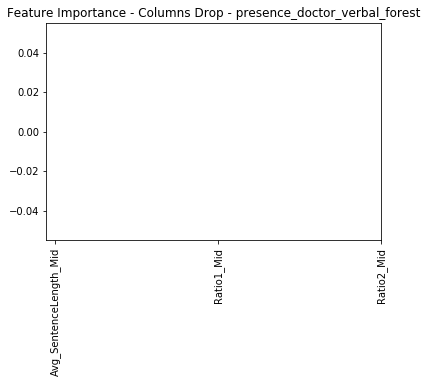

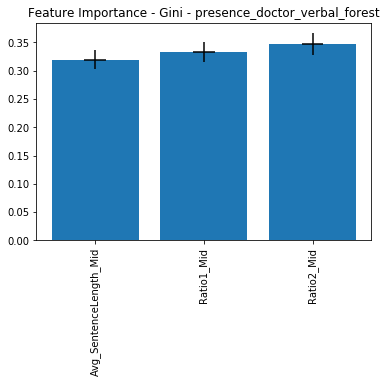

Test 1 : {'subject': 'doctor', 'target': 'copresence', 'classifier': 'forest', 'modes': 'verbal'}
(array([1, 2, 3], dtype=int64), array([36, 36, 36]))
  Gridsearch evaluated best score 0.7958480305702529
    Running 10 iterations on best classifier {'max_features': 'sqrt', 'n_estimators': 300, 'max_depth': None, 'min_samples_leaf': 1} ...
iter # 0
iter # 1
iter # 2
iter # 3
iter # 4
iter # 5
iter # 6
iter # 7
iter # 8
iter # 9
   Elapsed %s seconds278.622999907
      updating scores for presence_doctor_verbal_forest


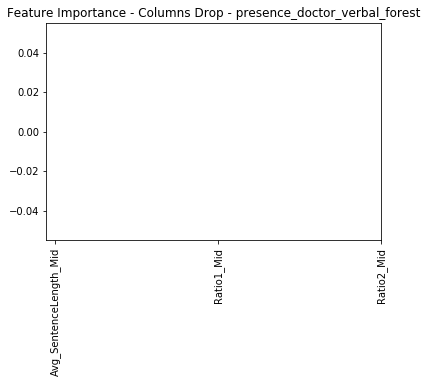

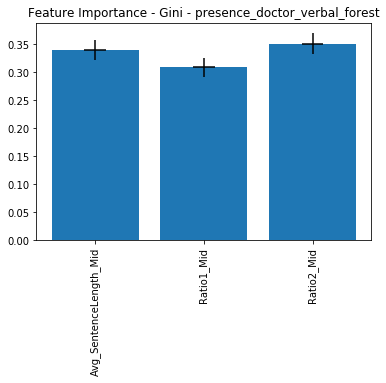

Test 2 : {'subject': 'agent', 'target': 'presence', 'classifier': 'forest', 'modes': 'verbal'}
(array([1, 2, 3], dtype=int64), array([35, 35, 35]))
  Gridsearch evaluated best score 0.16666666666666666
    Running 10 iterations on best classifier {'max_features': None, 'n_estimators': 300, 'max_depth': None, 'min_samples_leaf': 1} ...
iter # 0
iter # 1
iter # 2
iter # 3
iter # 4
iter # 5
iter # 6
iter # 7
iter # 8
iter # 9
   Elapsed %s seconds265.976000071
      updating scores for presence_agent_verbal_forest


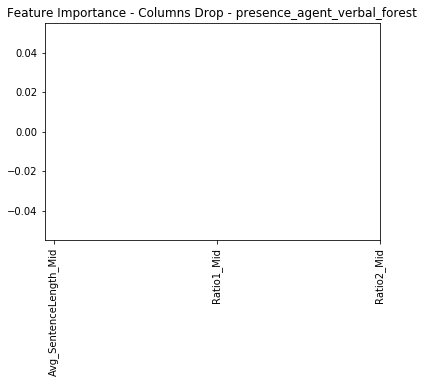

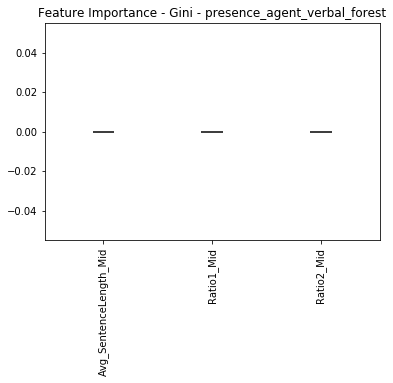

Test 3 : {'subject': 'agent', 'target': 'copresence', 'classifier': 'forest', 'modes': 'verbal'}
(array([1, 2, 3], dtype=int64), array([36, 36, 36]))
  Gridsearch evaluated best score 0.16666666666666666
    Running 10 iterations on best classifier {'max_features': None, 'n_estimators': 300, 'max_depth': None, 'min_samples_leaf': 1} ...
iter # 0
iter # 1
iter # 2
iter # 3
iter # 4
iter # 5
iter # 6
iter # 7
iter # 8
iter # 9
   Elapsed %s seconds270.203999996
      updating scores for presence_agent_verbal_forest


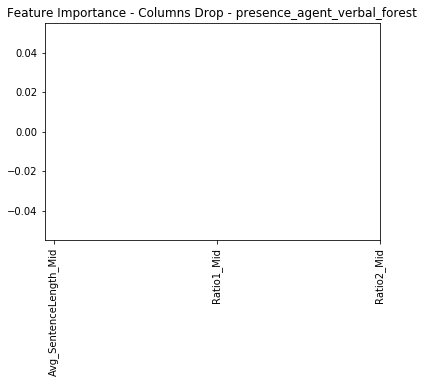

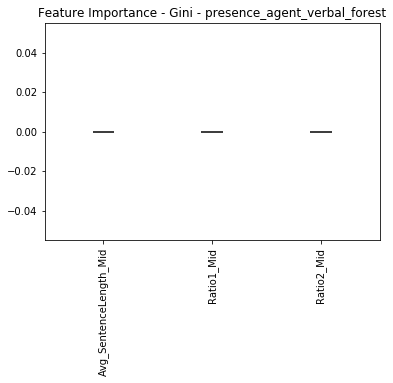

Test 4 : {'subject': 'doctor+agent', 'target': 'presence', 'classifier': 'forest', 'modes': 'verbal'}
(array([1, 2, 3], dtype=int64), array([35, 35, 35]))
  Gridsearch evaluated best score 0.6097388854531711
    Running 10 iterations on best classifier {'max_features': 'sqrt', 'n_estimators': 300, 'max_depth': 5, 'min_samples_leaf': 1} ...
iter # 0
iter # 1
iter # 2
iter # 3
iter # 4
iter # 5
iter # 6
iter # 7
iter # 8
iter # 9
   Elapsed %s seconds271.289000034
      updating scores for presence_doctoragent_verbal_forest


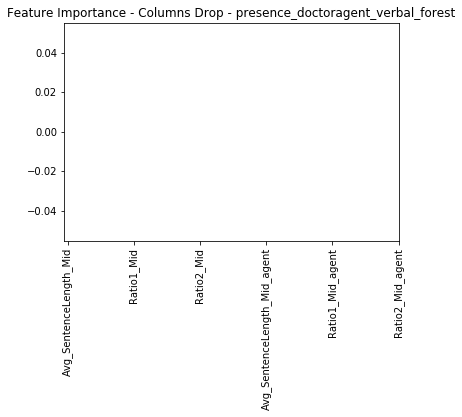

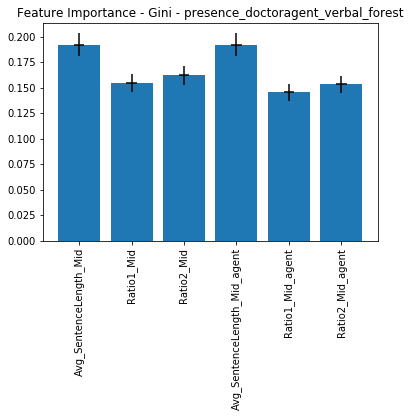

Test 5 : {'subject': 'doctor+agent', 'target': 'copresence', 'classifier': 'forest', 'modes': 'verbal'}
(array([1, 2, 3], dtype=int64), array([36, 36, 36]))
  Gridsearch evaluated best score 0.821634332745444
    Running 10 iterations on best classifier {'max_features': 'sqrt', 'n_estimators': 300, 'max_depth': None, 'min_samples_leaf': 1} ...
iter # 0
iter # 1
iter # 2
iter # 3
iter # 4
iter # 5
iter # 6
iter # 7
iter # 8
iter # 9
   Elapsed %s seconds274.112000227
      updating scores for presence_doctoragent_verbal_forest


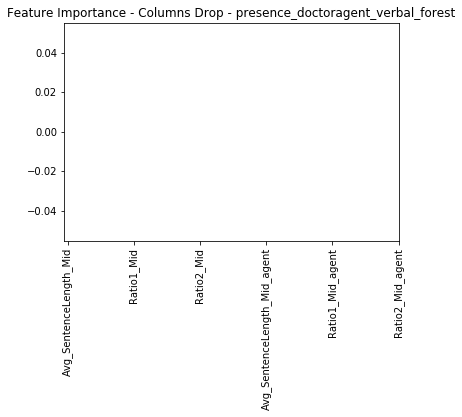

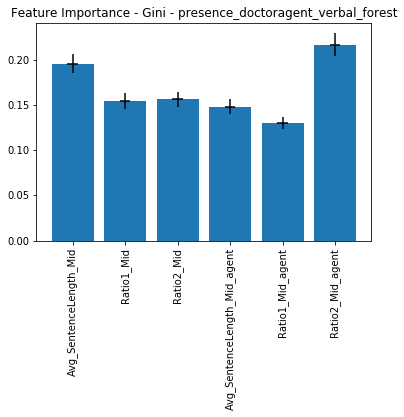

Test 6 : {'subject': 'doctor', 'target': 'presence', 'classifier': 'forest', 'modes': 'nonverbal'}
(array([1, 2, 3], dtype=int64), array([35, 35, 35]))
  Gridsearch evaluated best score 0.6879358207929636
    Running 10 iterations on best classifier {'max_features': 'sqrt', 'n_estimators': 300, 'max_depth': 5, 'min_samples_leaf': 1} ...
iter # 0
iter # 1
iter # 2
iter # 3
iter # 4
iter # 5
iter # 6
iter # 7
iter # 8
iter # 9
   Elapsed %s seconds271.317000151
      updating scores for presence_doctor_nonverbal_forest


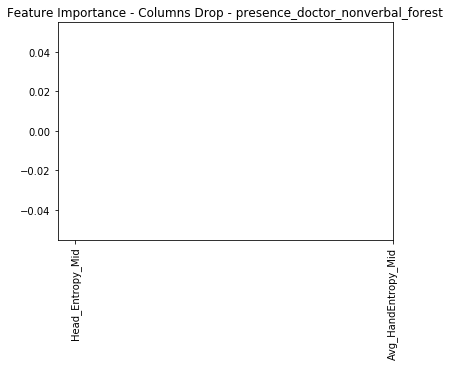

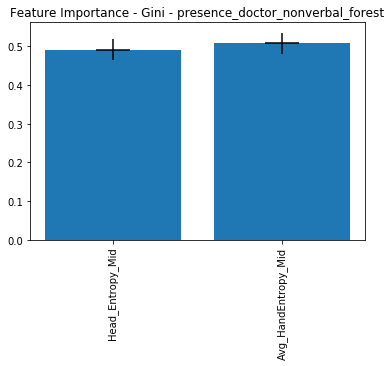

Test 7 : {'subject': 'doctor', 'target': 'copresence', 'classifier': 'forest', 'modes': 'nonverbal'}
(array([1, 2, 3], dtype=int64), array([36, 36, 36]))
  Gridsearch evaluated best score 0.7849941211052324
    Running 10 iterations on best classifier {'max_features': 'sqrt', 'n_estimators': 300, 'max_depth': None, 'min_samples_leaf': 1} ...
iter # 0
iter # 1
iter # 2
iter # 3
iter # 4
iter # 5
iter # 6
iter # 7
iter # 8
iter # 9
   Elapsed %s seconds279.164999962
      updating scores for presence_doctor_nonverbal_forest


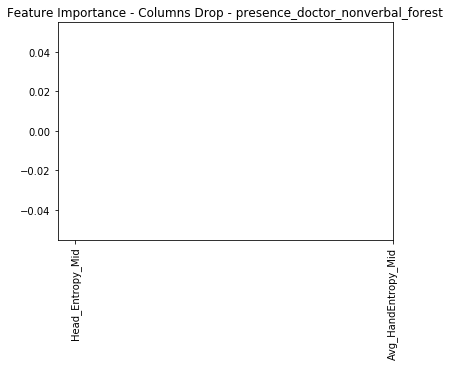

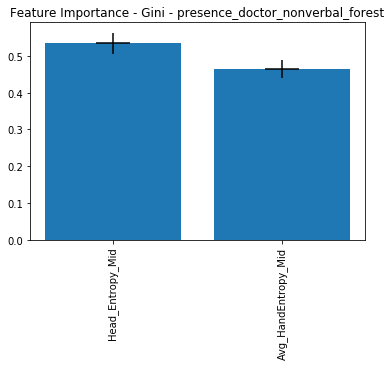

Test 8 : {'subject': 'agent', 'target': 'presence', 'classifier': 'forest', 'modes': 'nonverbal'}
(array([1, 2, 3], dtype=int64), array([35, 35, 35]))
  Gridsearch evaluated best score 0.16666666666666666
    Running 10 iterations on best classifier {'max_features': None, 'n_estimators': 300, 'max_depth': None, 'min_samples_leaf': 1} ...
iter # 0
iter # 1
iter # 2
iter # 3
iter # 4
iter # 5
iter # 6
iter # 7
iter # 8
iter # 9
   Elapsed %s seconds263.73300004
      updating scores for presence_agent_nonverbal_forest


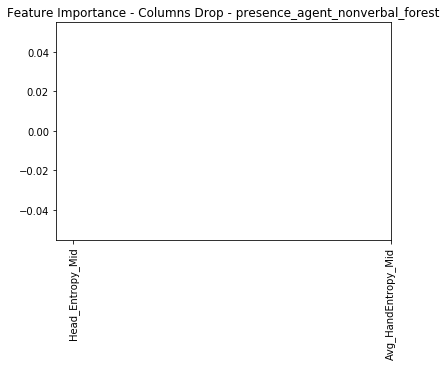

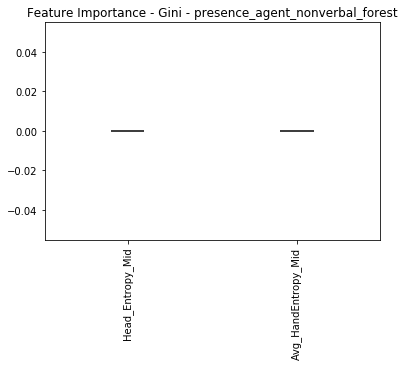

Test 9 : {'subject': 'agent', 'target': 'copresence', 'classifier': 'forest', 'modes': 'nonverbal'}
(array([1, 2, 3], dtype=int64), array([36, 36, 36]))
  Gridsearch evaluated best score 0.16666666666666666
    Running 10 iterations on best classifier {'max_features': None, 'n_estimators': 300, 'max_depth': None, 'min_samples_leaf': 1} ...
iter # 0
iter # 1
iter # 2
iter # 3
iter # 4
iter # 5
iter # 6
iter # 7
iter # 8
iter # 9
   Elapsed %s seconds271.296999931
      updating scores for presence_agent_nonverbal_forest


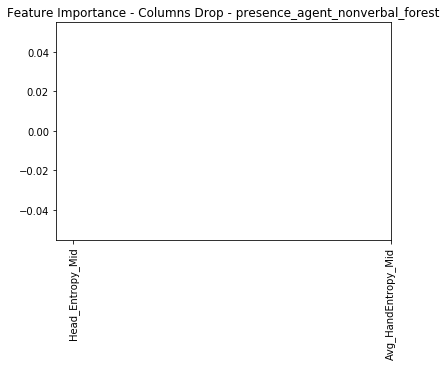

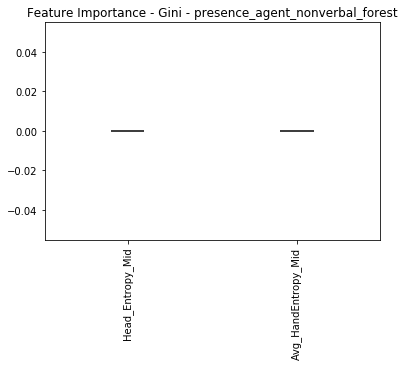

Test 10 : {'subject': 'doctor+agent', 'target': 'presence', 'classifier': 'forest', 'modes': 'nonverbal'}
(array([1, 2, 3], dtype=int64), array([35, 35, 35]))
  Gridsearch evaluated best score 0.6887184772899059
    Running 10 iterations on best classifier {'max_features': None, 'n_estimators': 300, 'max_depth': 10, 'min_samples_leaf': 1} ...
iter # 0
iter # 1
iter # 2
iter # 3
iter # 4
iter # 5
iter # 6
iter # 7
iter # 8
iter # 9
   Elapsed %s seconds282.207999945
      updating scores for presence_doctoragent_nonverbal_forest


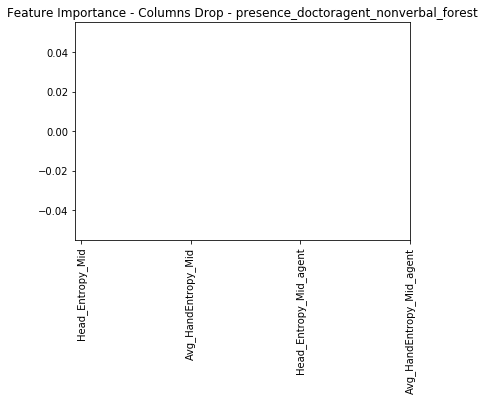

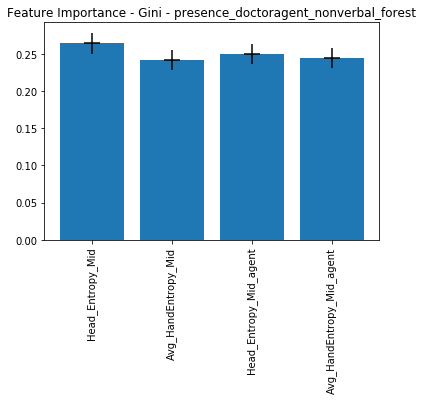

Test 11 : {'subject': 'doctor+agent', 'target': 'copresence', 'classifier': 'forest', 'modes': 'nonverbal'}
(array([1, 2, 3], dtype=int64), array([36, 36, 36]))
  Gridsearch evaluated best score 0.8036816578483246
    Running 10 iterations on best classifier {'max_features': None, 'n_estimators': 300, 'max_depth': None, 'min_samples_leaf': 1} ...
iter # 0
iter # 1
iter # 2
iter # 3
iter # 4
iter # 5
iter # 6
iter # 7
iter # 8
iter # 9
   Elapsed %s seconds279.849999905
      updating scores for presence_doctoragent_nonverbal_forest


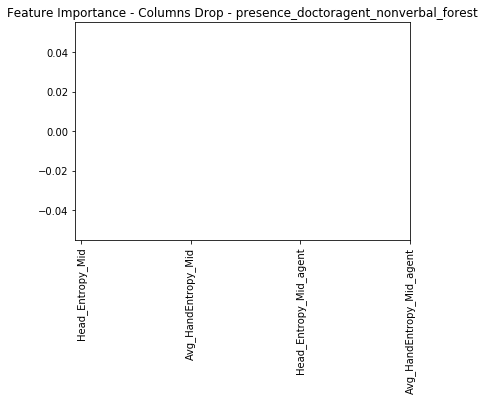

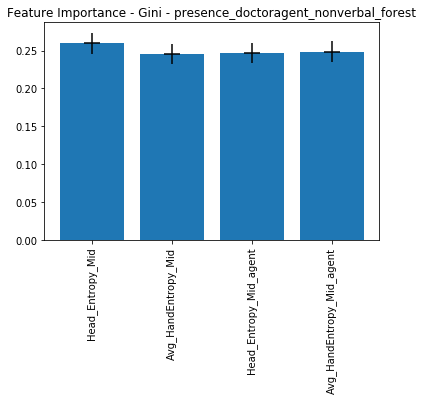

Test 12 : {'subject': 'doctor', 'target': 'presence', 'classifier': 'forest', 'modes': 'multimodal'}
(array([1, 2, 3], dtype=int64), array([35, 35, 35]))
  Gridsearch evaluated best score 0.7351020408163265
    Running 10 iterations on best classifier {'max_features': 'sqrt', 'n_estimators': 300, 'max_depth': None, 'min_samples_leaf': 1} ...
iter # 0
iter # 1
iter # 2
iter # 3
iter # 4
iter # 5
iter # 6
iter # 7
iter # 8
iter # 9
   Elapsed %s seconds283.352999926
      updating scores for presence_doctor_multimodal_forest


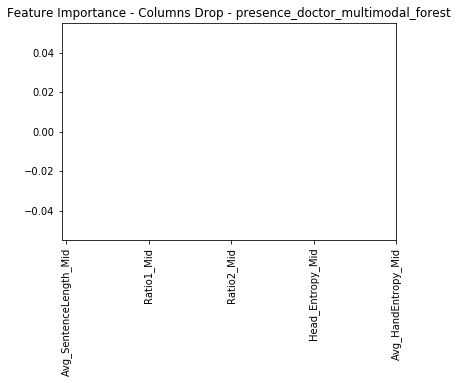

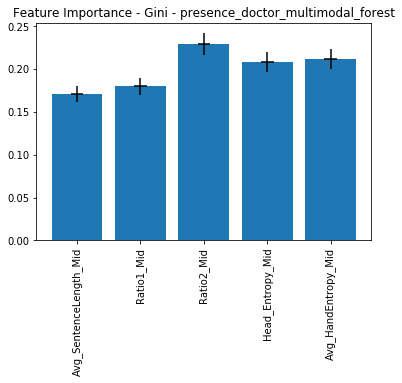

Test 13 : {'subject': 'doctor', 'target': 'copresence', 'classifier': 'forest', 'modes': 'multimodal'}
(array([1, 2, 3], dtype=int64), array([36, 36, 36]))
  Gridsearch evaluated best score 0.8606334509112287
    Running 10 iterations on best classifier {'max_features': 'sqrt', 'n_estimators': 300, 'max_depth': None, 'min_samples_leaf': 1} ...
iter # 0
iter # 1
iter # 2
iter # 3
iter # 4
iter # 5
iter # 6
iter # 7
iter # 8
iter # 9
   Elapsed %s seconds269.198999882
      updating scores for presence_doctor_multimodal_forest


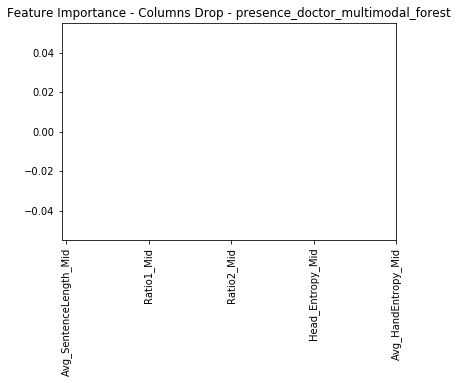

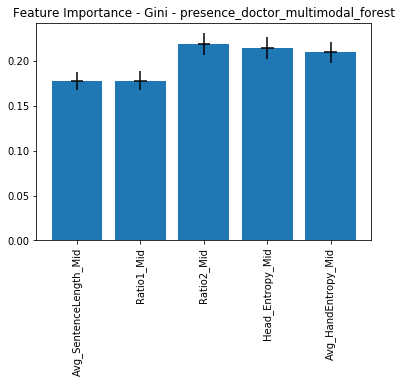

Test 14 : {'subject': 'agent', 'target': 'presence', 'classifier': 'forest', 'modes': 'multimodal'}
(array([1, 2, 3], dtype=int64), array([35, 35, 35]))
  Gridsearch evaluated best score 0.16666666666666666
    Running 10 iterations on best classifier {'max_features': None, 'n_estimators': 300, 'max_depth': None, 'min_samples_leaf': 1} ...
iter # 0
iter # 1
iter # 2
iter # 3
iter # 4
iter # 5
iter # 6
iter # 7
iter # 8
iter # 9
   Elapsed %s seconds265.479000092
      updating scores for presence_agent_multimodal_forest


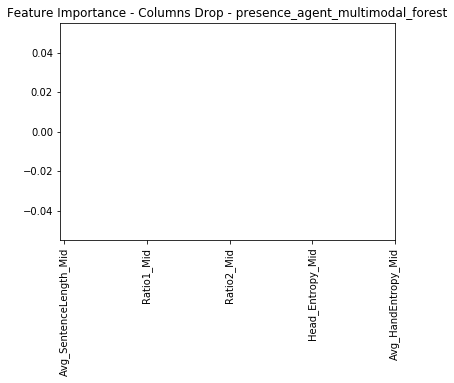

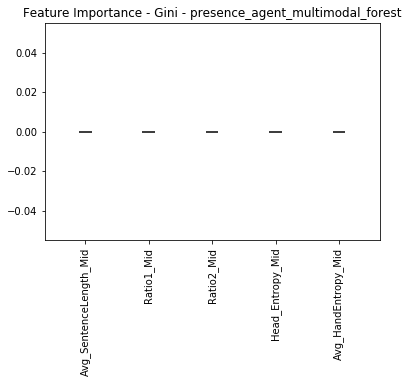

Test 15 : {'subject': 'agent', 'target': 'copresence', 'classifier': 'forest', 'modes': 'multimodal'}
(array([1, 2, 3], dtype=int64), array([36, 36, 36]))
  Gridsearch evaluated best score 0.16666666666666666
    Running 10 iterations on best classifier {'max_features': None, 'n_estimators': 300, 'max_depth': None, 'min_samples_leaf': 1} ...
iter # 0
iter # 1
iter # 2
iter # 3
iter # 4
iter # 5
iter # 6
iter # 7
iter # 8
iter # 9
   Elapsed %s seconds262.929999828
      updating scores for presence_agent_multimodal_forest


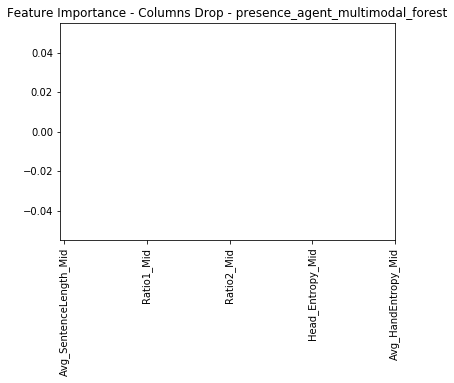

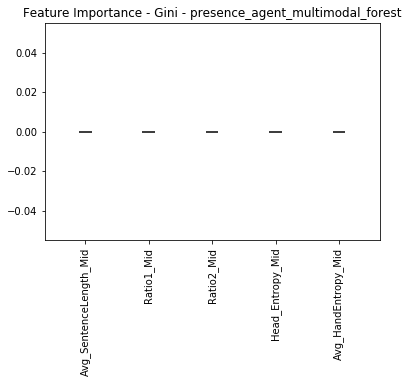

Test 16 : {'subject': 'doctor+agent', 'target': 'presence', 'classifier': 'forest', 'modes': 'multimodal'}
(array([1, 2, 3], dtype=int64), array([35, 35, 35]))
  Gridsearch evaluated best score 0.7108314436885866
    Running 10 iterations on best classifier {'max_features': 'sqrt', 'n_estimators': 300, 'max_depth': 5, 'min_samples_leaf': 1} ...
iter # 0
iter # 1
iter # 2
iter # 3
iter # 4
iter # 5
iter # 6
iter # 7
iter # 8
iter # 9
   Elapsed %s seconds281.394000053
      updating scores for presence_doctoragent_multimodal_forest


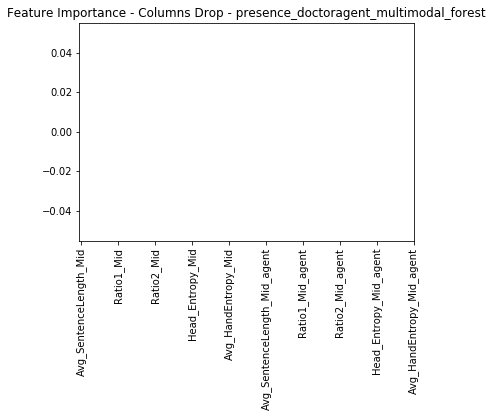

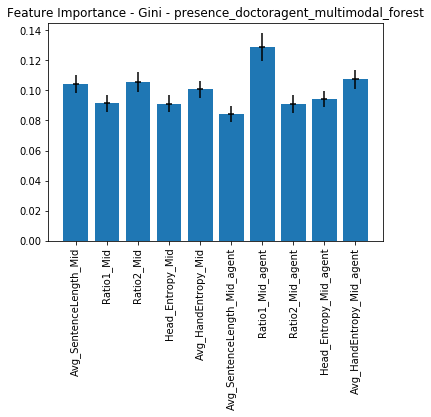

Test 17 : {'subject': 'doctor+agent', 'target': 'copresence', 'classifier': 'forest', 'modes': 'multimodal'}
(array([1, 2, 3], dtype=int64), array([36, 36, 36]))
  Gridsearch evaluated best score 0.7793169793169794
    Running 10 iterations on best classifier {'max_features': 'sqrt', 'n_estimators': 300, 'max_depth': None, 'min_samples_leaf': 1} ...
iter # 0
iter # 1
iter # 2
iter # 3
iter # 4
iter # 5
iter # 6
iter # 7
iter # 8
iter # 9
   Elapsed %s seconds281.078000069
      updating scores for presence_doctoragent_multimodal_forest


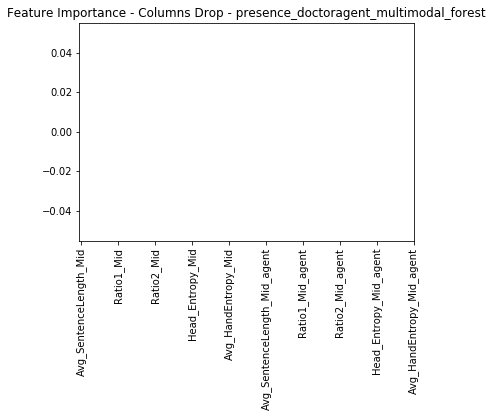

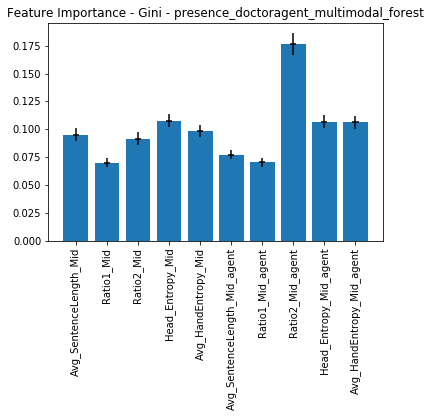

Test 18 : {'subject': 'doctor', 'target': 'presence', 'classifier': 'forest', 'modes': 'multimodal+duration'}
(array([1, 2, 3], dtype=int64), array([35, 35, 35]))
  Gridsearch evaluated best score 0.6935525321239607
    Running 10 iterations on best classifier {'max_features': 'sqrt', 'n_estimators': 300, 'max_depth': 10, 'min_samples_leaf': 1} ...
iter # 0
iter # 1
iter # 2
iter # 3
iter # 4
iter # 5
iter # 6
iter # 7
iter # 8
iter # 9
   Elapsed %s seconds275.039000034
      updating scores for presence_doctor_multimodal+duration_forest


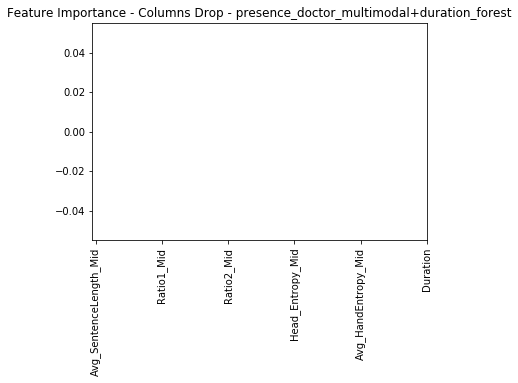

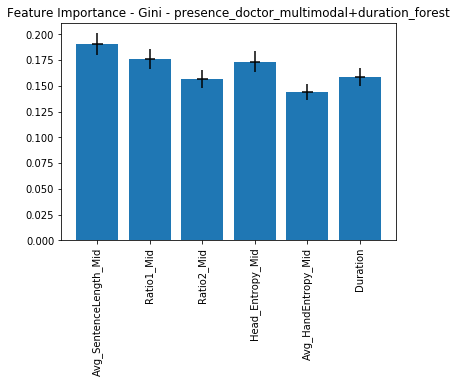

Test 19 : {'subject': 'doctor', 'target': 'copresence', 'classifier': 'forest', 'modes': 'multimodal+duration'}
(array([1, 2, 3], dtype=int64), array([36, 36, 36]))
  Gridsearch evaluated best score 0.8212228101116991
    Running 10 iterations on best classifier {'max_features': 'sqrt', 'n_estimators': 300, 'max_depth': 5, 'min_samples_leaf': 1} ...
iter # 0
iter # 1
iter # 2
iter # 3
iter # 4
iter # 5
iter # 6
iter # 7
iter # 8
iter # 9
   Elapsed %s seconds277.644000053
      updating scores for presence_doctor_multimodal+duration_forest


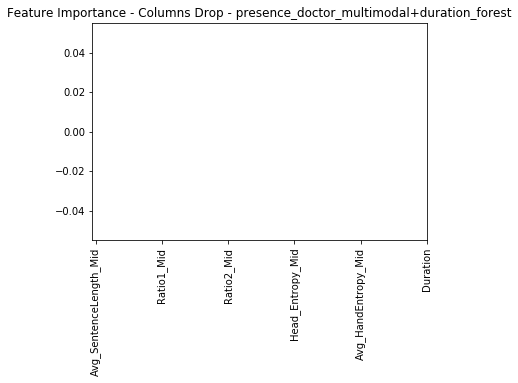

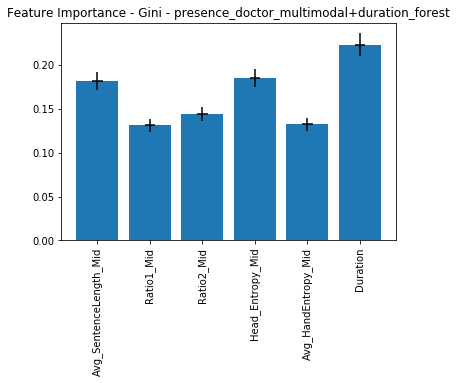

Test 20 : {'subject': 'agent', 'target': 'presence', 'classifier': 'forest', 'modes': 'multimodal+duration'}
(array([1, 2, 3], dtype=int64), array([35, 35, 35]))
  Gridsearch evaluated best score 0.7430234315948603
    Running 10 iterations on best classifier {'max_features': None, 'n_estimators': 300, 'max_depth': None, 'min_samples_leaf': 1} ...
iter # 0
iter # 1
iter # 2
iter # 3
iter # 4
iter # 5
iter # 6
iter # 7
iter # 8
iter # 9
   Elapsed %s seconds266.845000029
      updating scores for presence_agent_multimodal+duration_forest


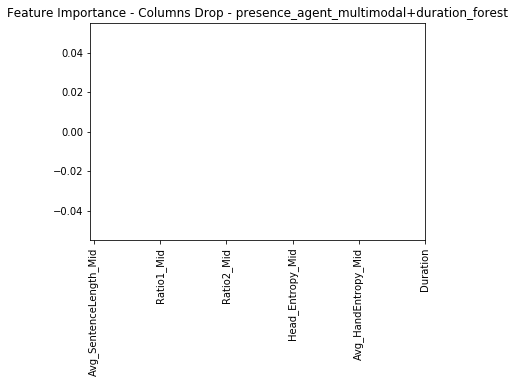

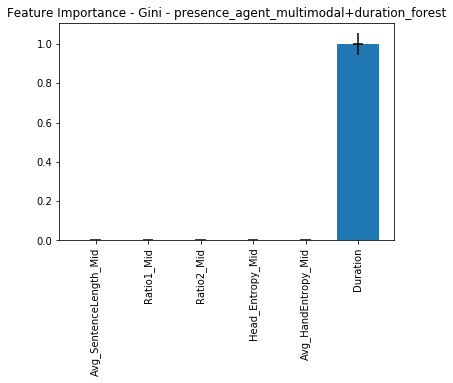

Test 21 : {'subject': 'agent', 'target': 'copresence', 'classifier': 'forest', 'modes': 'multimodal+duration'}
(array([1, 2, 3], dtype=int64), array([36, 36, 36]))
  Gridsearch evaluated best score 0.7340347923681257
    Running 10 iterations on best classifier {'max_features': None, 'n_estimators': 300, 'max_depth': None, 'min_samples_leaf': 1} ...
iter # 0
iter # 1
iter # 2
iter # 3
iter # 4
iter # 5
iter # 6
iter # 7
iter # 8
iter # 9
   Elapsed %s seconds276.333000183
      updating scores for presence_agent_multimodal+duration_forest


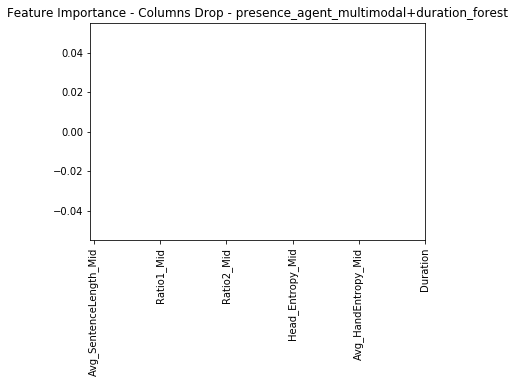

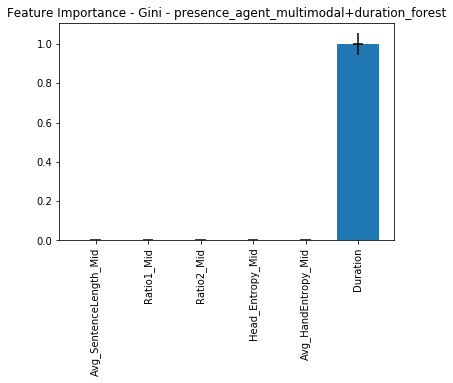

Test 22 : {'subject': 'doctor+agent', 'target': 'presence', 'classifier': 'forest', 'modes': 'multimodal+duration'}
(array([1, 2, 3], dtype=int64), array([35, 35, 35]))
  Gridsearch evaluated best score 0.7287301587301587
    Running 10 iterations on best classifier {'max_features': 'sqrt', 'n_estimators': 300, 'max_depth': 10, 'min_samples_leaf': 1} ...
iter # 0
iter # 1
iter # 2
iter # 3
iter # 4
iter # 5
iter # 6
iter # 7
iter # 8
iter # 9
   Elapsed %s seconds279.532999992
      updating scores for presence_doctoragent_multimodal+duration_forest


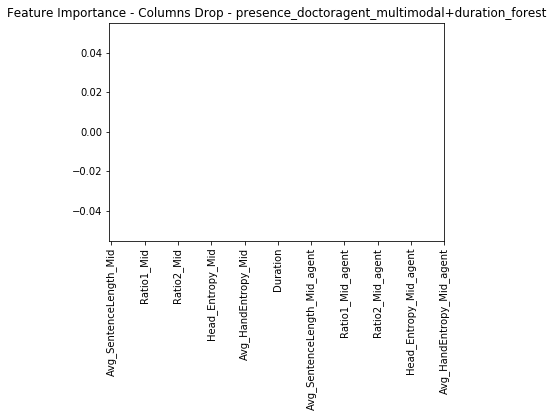

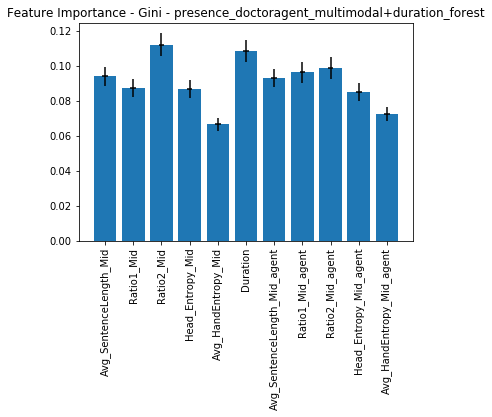

Test 23 : {'subject': 'doctor+agent', 'target': 'copresence', 'classifier': 'forest', 'modes': 'multimodal+duration'}
(array([1, 2, 3], dtype=int64), array([36, 36, 36]))
  Gridsearch evaluated best score 0.8361331569664904
    Running 10 iterations on best classifier {'max_features': 'sqrt', 'n_estimators': 300, 'max_depth': 10, 'min_samples_leaf': 1} ...
iter # 0
iter # 1
iter # 2
iter # 3
iter # 4
iter # 5
iter # 6
iter # 7
iter # 8
iter # 9
   Elapsed %s seconds277.374000072
      updating scores for presence_doctoragent_multimodal+duration_forest


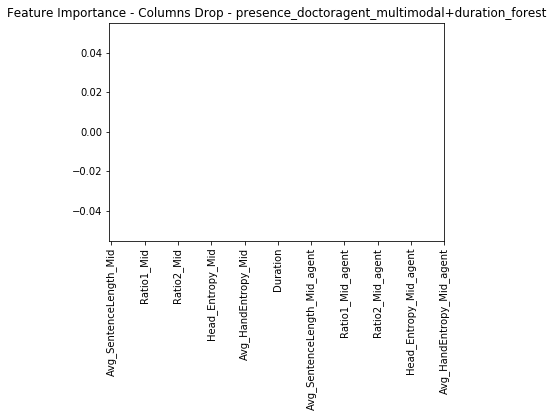

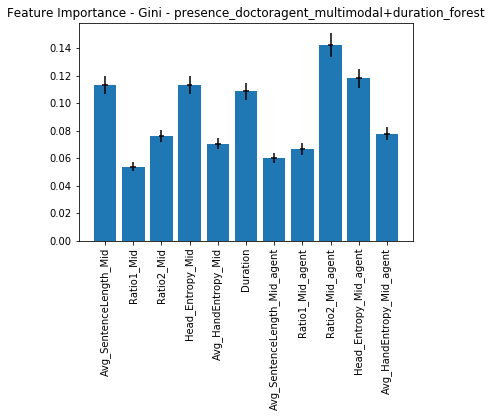

Test 24 : {'subject': 'doctor', 'target': 'presence', 'classifier': 'svm', 'modes': 'verbal'}
(array([1, 2, 3], dtype=int64), array([35, 35, 35]))
  Gridsearch evaluated best score 0.7775359032501891
    Running 10 iterations on best classifier {'svc__gamma': 10.0, 'svc__kernel': 'rbf', 'svc__C': 1.0} ...
iter # 0
iter # 1
iter # 2
iter # 3
iter # 4
iter # 5
iter # 6
iter # 7
iter # 8
iter # 9
   Elapsed %s seconds4.7460000515
      updating scores for presence_doctor_verbal_svm
Test 25 : {'subject': 'doctor', 'target': 'copresence', 'classifier': 'svm', 'modes': 'verbal'}
(array([1, 2, 3], dtype=int64), array([36, 36, 36]))
  Gridsearch evaluated best score 0.8434891240446796
    Running 10 iterations on best classifier {'svc__gamma': 10.0, 'svc__kernel': 'rbf', 'svc__C': 1.0} ...
iter # 0
iter # 1
iter # 2
iter # 3
iter # 4
iter # 5
iter # 6
iter # 7
iter # 8
iter # 9
   Elapsed %s seconds4.64400005341
      updating scores for presence_doctor_verbal_svm
Test 26 : {'subject': 'agent'

iter # 2
iter # 3
iter # 4
iter # 5
iter # 6
iter # 7
iter # 8
iter # 9
   Elapsed %s seconds5.33899998665
      updating scores for presence_doctoragent_multimodal_svm
Test 41 : {'subject': 'doctor+agent', 'target': 'copresence', 'classifier': 'svm', 'modes': 'multimodal'}
(array([1, 2, 3], dtype=int64), array([36, 36, 36]))
  Gridsearch evaluated best score 0.8306985195874085
    Running 10 iterations on best classifier {'svc__gamma': 1.0, 'svc__kernel': 'rbf', 'svc__C': 10.0} ...
iter # 0
iter # 1
iter # 2
iter # 3
iter # 4
iter # 5
iter # 6
iter # 7
iter # 8
iter # 9
   Elapsed %s seconds5.14299988747
      updating scores for presence_doctoragent_multimodal_svm
Test 42 : {'subject': 'doctor', 'target': 'presence', 'classifier': 'svm', 'modes': 'multimodal+duration'}
(array([1, 2, 3], dtype=int64), array([35, 35, 35]))
  Gridsearch evaluated best score 0.8649089534803821
    Running 10 iterations on best classifier {'svc__gamma': 10.0, 'svc__kernel': 'rbf', 'svc__C': 1.0} ...
iter 

In [38]:


forest = RandomForestClassifier(random_state=RANDOM_STATE, oob_score=True)
svm = make_pipeline(StandardScaler(), SVC(random_state=RANDOM_STATE))

# number of kfolds folds for cross validations
cv = 10
# number of kfold cross validations performed to compute mean scores
repeat = 10
# number of random forest training performed to compute mean features importances
repeat_dc = 300
# whether to apply 'original' upsampling method
upsample = True

fi = False

for idx, test in enumerate(test_plan):
    print("Test %d : %s" % (idx, test))
    
    # make it global because we use them to compute feature importance for forests
    all_feature_importances = []    
    all_dropcol_feature_importances = []

    subject = test['subject']
    target = test['target']
    modes = test['modes']
    classifier = test['classifier']
    clf = forest if classifier == 'forest' else svm
    pgrid = param_grid_rf if classifier == 'forest' else param_grid_svm

    if subject == 'doctor':
        df = subject_np_df
        if modes == 'verbal':
            feats = subject_features_verbal
        elif modes == 'nonverbal':
            feats = subject_features_nonverbal
        elif modes == 'multimodal':
            feats = subject_features_multimodal
        elif modes == 'multimodal+duration':
            feats = subject_features_multimodal_duration
    elif subject == 'agent':
        df = agent_np_df
        if modes == 'verbal':
            feats = agent_features_verbal
        elif modes == 'nonverbal':
            feats = agent_features_nonverbal
        elif modes == 'multimodal':
            feats = agent_features_multimodal
        elif modes == 'multimodal+duration':
            feats = agent_features_multimodal_duration        
    else:
        df = all_np_df
        if modes == 'verbal':
            feats = all_features_verbal
        elif modes == 'nonverbal':
            feats = all_features_nonverbal
        elif modes == 'multimodal':
            feats = all_features_multimodal
        elif modes == 'multimodal+duration':
            feats = all_features_multimodal_duration        
    
    start = time.time()
    
    X, y = prepare_train_data(samples=df, features=feats, target_model=target, upsample=upsample) 
    
    grid, scores, dropcol_fis, fis, support = run_gridsearch(clf, 
                                                    pgrid, 
                                                    df, feats, 
                                                    target, 
                                                    repeat=repeat, repeat_dc=repeat_dc, 
                                                    upsample=upsample, 
                                                    fi=fi,
                                                    verbose=verbose)

    elapsed = time.time() - start
    print("   Elapsed %s seconds" +str(elapsed))

    isDoc = 'doctor' in subject
    isAgent = 'agent' in subject
    #save_grid(grid, presence=target=='presence', doctor=isDoc, agent=isAgent,
    #         phases=phases, classifier='RF' if test['classifier']=='forest' else 'SVM')

    presidx = 'Presence' if target == 'presence' else 'Co-Presence'
    if subject == 'doctor':
        subjidx = 'Doctor'
    elif subject == 'agent':
        subjidx = 'Agent'
    else:
        subjidx = 'Doctor+Agent'
    #phidx = 'No Phase' if phases in [None, (0,1,0)] else '%2d%2d%2d' % ( phases[0]*100, phases[1]*100, phases[2]*100 )
    if modes == 'verbal':
        phidx = 'Verbal'
    elif modes == 'nonverbal':
        phidx = 'Non-Verbal'
    elif modes == 'multimodal':
        phidx = 'Multimodal'
    elif modes == 'multimodal+duration':
        phidx = 'Multimodal+Duration'
    clfidx = 'Random Forests' if classifier == 'forest' else 'SVM'

    # compute err
    all_scores_ = scores.drop(['fit_time', 'score_time'], axis=1).T
    final = pd.DataFrame(index=all_scores_.index)
    final['means'] = all_scores_.mean(axis=1)
    final['std'] = all_scores_.std(axis=1)

    test_set_name = dh.get_grid_name(target, isDoc, isAgent, modes, classifier)
    print("      updating scores for %s" % test_set_name)
    #print("final" , final)
    scores_df = update_results(scores_df, pd.DataFrame(final.T.loc['means']).T, presidx, subjidx, phidx, clfidx, 'score')
    scores_df = update_results(scores_df, pd.DataFrame(final.T.loc['std']).T, presidx, subjidx, phidx, clfidx, 'err')    
    dh.save_obj(scores_df, 'results', 'scores')
    
    dumpPath = os.path.join(dh.root_path, 'results', 'scores.xlsx')
    scores_df.to_excel(dumpPath, index=True)
    
    
    ctx = [[upsample, cv, repeat, repeat_dc, grid.best_params_, elapsed, support, feats], [0,0,0,0,0,0,0,0]]
    ctx_df = pd.DataFrame(ctx, columns=['UpSample', 'KFolds K', 'KFolds repetitions', 'Repetitions for features importance',
                     'Best Params', 'Time (s)', 'Support', 'Features'])
   
    for col in ctx_df.columns:
        if col in ['Best Params', 'Support', 'Features']:
            context_df.loc[(presidx, subjidx, phidx, clfidx, 'score'), col] = str(ctx_df[col][0])
        else:
            #print("col %s" % col)
            context_df.loc[(presidx, subjidx, phidx, clfidx, 'score'), col] = ctx_df[col][0]
    dumpPath = os.path.join(dh.root_path, '.',  'context.csv')
    context_df.to_csv(dumpPath, index=True)
    
    

    # features importances
    if dropcol_fis is not None:
        final_fi = dropcol_fis.T
        final_fi['means'] = final_fi.mean(axis=1)
        final_fi['std'] = final_fi.std(axis=1)
        final_fi['sem'] = final_fi.sem(axis=1)
        final_fi['confidence'] = final_fi.apply(lambda row : 2*(np.mean(row) - st.t.interval(0.95, len(row)-1, loc=np.mean(row), scale=st.sem(row))[0]) , axis = 1)
        plot_importance('Columns Drop - ' + test_set_name, 
                        final_fi['means'],
                        final_fi['confidence'],
                        feats, 
                        sort=False)
        dumpPath = os.path.join(dh.root_path, 'results', 'features_importances_dropcol_%s.xlsx' % test_set_name)
        final_fi.to_excel(dumpPath, index=True)


    if fis is not None:
        final_fi_ = fis.T
        final_fi_['means'] = final_fi_.mean(axis=1)
        final_fi_['std'] = final_fi_.std(axis=1)
        final_fi_['sem'] = final_fi_.sem(axis=1)
        final_fi_['confidence'] = final_fi_.apply(lambda row : 2*(np.mean(row) - st.t.interval(0.95, len(row)-1, loc=np.mean(row), scale=st.sem(row))[0]) , axis = 1)
        plot_importance('Gini - ' + test_set_name, 
                        final_fi_['means'],
                        final_fi_['confidence'],
                        feats, 
                        sort=False)
        dumpPath = os.path.join(dh.root_path, 'results', 'features_importances_%s.xlsx' % test_set_name)
        final_fi.to_excel(dumpPath, index=True)


# Visualizations

## Results

### Modes (verbal, non-verbal ...)

First we reload the results.

In [88]:
# Some utilities for plots

from itertools import groupby


def add_line(ax, xpos, ypos):
    line = plt.Line2D([xpos, xpos], [ypos + .1, ypos],
                      transform=ax.transAxes, color='gray')
    line.set_clip_on(False)
    ax.add_line(line)

def label_len(my_index,level):
    labels = my_index.get_level_values(level)
    return [(k, sum(1 for i in g)) for k,g in groupby(labels)]

def label_group_bar_table(ax, df, nlevels=-1):
    ypos = -.1
    scale = 1./df.index.size
    if nlevels == -1:
        nlevels = df.index.nlevels
    for level in range(nlevels)[::-1]:
        pos = 0
        for label, rpos in label_len(df.index,level):
            lxpos = (pos + .5 * rpos)*scale
            ax.text(lxpos, ypos, label, ha='center', transform=ax.transAxes)
            add_line(ax, pos*scale, ypos)
            pos += rpos
        add_line(ax, pos*scale , ypos)
        ypos -= .1

In [89]:
# Reload results
dh = DataHandler('2-verbal-nonverbal-multimodal-duration', 2)
scores_df_index = [['Presence', 'Co-Presence'], 
             ['Doctor', 'Agent', 'Doctor+Agent'], 
             ['Verbal', 'Non-Verbal', 'Multimodal', 'Multimodal+Duration'], 
             ['Random Forests', 'SVM'],
             ['score', 'err']
            ]
scores_df_multiindex = pd.MultiIndex.from_product(scores_df_index, 
                                                  names=['Metric', 'Subject', 'Mode', 'Classifier', 'Metric'])
scores_df = dh.load_obj('results', 'scores')
if scores_df is None:
    print("No results to load !")

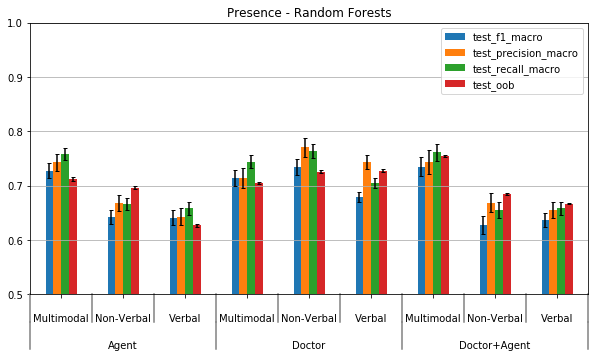

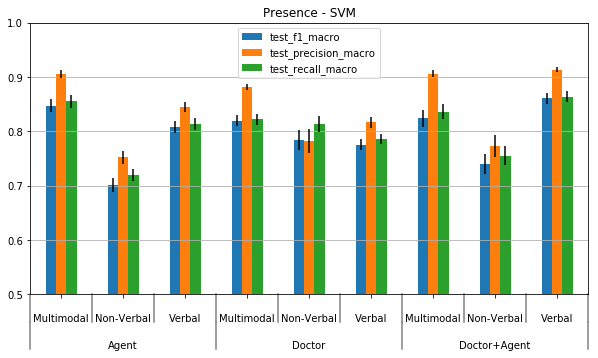

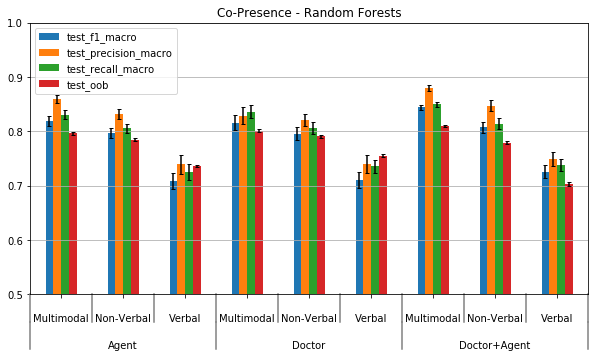

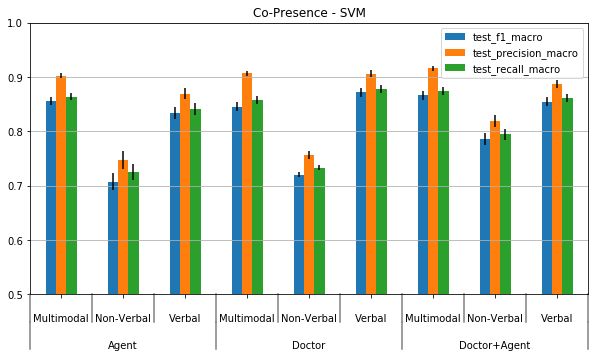

In [90]:
# RF - presence
        
rear = scores_df[['test_f1_macro', 'test_precision_macro', 'test_recall_macro', 'test_oob']].reorder_levels([4,3,0,1,2], axis=0).sort_index()
mydf = rear.loc['score', 'Random Forests', 'Presence', :, ['Verbal', 'Non-Verbal', 'Multimodal']]

mydf.index = mydf.index.remove_unused_levels()
mydf.index = mydf.index.droplevel([0,1,2])
mydf = mydf.sort_index()
#mydf = mydf.rename({'Verbal': 'V', 'Non-Verbal': 'NV', 'Multimodal': 'M', 'Multimodal+Duration': 'M+D'}, 
#                   level=1,
#                   axis='index')
ax = mydf.plot(kind='bar',yerr=rear.loc['err', 'Random Forests', 'Presence'] / 10,
               stacked=False, 
               figsize=(10,5),
               title='Presence - Random Forests',
              capsize=2)
#Below 2 lines remove default labels
ax.set_xticklabels('')
ax.set_xlabel('')
ax.set_ylim([0.5, 1])
ax.grid(axis='y')
label_group_bar_table(ax, mydf, 2)
plt.savefig(os.path.join(dh.root_path, 'scores_bar_modalities_presence_rf.png'), bbox_inches = "tight")
plt.show()

# SVM - presence

mydf = rear.loc['score', 'SVM', 'Presence', :, ['Verbal', 'Non-Verbal', 'Multimodal']]
mydf.index = mydf.index.remove_unused_levels()
mydf.index = mydf.index.droplevel([0,1,2])
mydf = mydf.drop(['test_oob'], axis=1)
mydf.sort_index()
#mydf = mydf.rename({'Verbal': 'V', 'Non-Verbal': 'NV', 'Multimodal': 'M', 'Multimodal+Duration': 'M+D'}, 
#                   level=1, 
#                   axis='index')
ax = mydf.plot(kind='bar',
               yerr=rear.loc['err', 'SVM', 'Presence'] / 10,
               stacked=False, 
               figsize=(10,5),
               title='Presence - SVM')
#Below 2 lines remove default labels
ax.set_xticklabels('')
ax.set_xlabel('')
ax.set_ylim([0.5, 1])
ax.grid(axis='y')
label_group_bar_table(ax, mydf, 2)
plt.savefig(os.path.join(dh.root_path, 'scores_bar_modalities_presence_svm.png'), bbox_inches = "tight")
plt.show()


# RF - CO-Presence

mydf = rear.loc['score', 'Random Forests', 'Co-Presence', :, ['Verbal', 'Non-Verbal', 'Multimodal']]

mydf.index = mydf.index.remove_unused_levels()
mydf.index = mydf.index.droplevel([0,1,2])
mydf = mydf.sort_index()
#mydf = mydf.rename({'Verbal': 'V', 'Non-Verbal': 'NV', 'Multimodal': 'M', 'Multimodal+Duration': 'M+D'}, 
#                   level=1,
#                   axis='index')
ax = mydf.plot(kind='bar',yerr=rear.loc['err', 'Random Forests', 'Co-Presence'] / 10,
               stacked=False, 
               figsize=(10,5),
               title='Co-Presence - Random Forests',
              capsize=2)
#Below 2 lines remove default labels
ax.set_xticklabels('')
ax.set_xlabel('')
ax.set_ylim([0.5, 1])
ax.grid(axis='y')
label_group_bar_table(ax, mydf, 2)
plt.savefig(os.path.join(dh.root_path, 'scores_bar_modalities_copresence_rf.png'), bbox_inches = "tight")
plt.show()

# SVM - CO-presence

mydf = rear.loc['score', 'SVM', 'Co-Presence', :, ['Verbal', 'Non-Verbal', 'Multimodal']]
mydf.index = mydf.index.remove_unused_levels()
mydf.index = mydf.index.droplevel([0,1,2])
mydf = mydf.drop(['test_oob'], axis=1)
mydf.sort_index()
#mydf = mydf.rename({'Verbal': 'V', 'Non-Verbal': 'NV', 'Multimodal': 'M', 'Multimodal+Duration': 'M+D'}, 
#                   level=1, 
#                   axis='index')
ax = mydf.plot(kind='bar',
               yerr=rear.loc['err', 'SVM', 'Co-Presence'] / 10,
               stacked=False, 
               figsize=(10,5),
               title='Co-Presence - SVM')
#Below 2 lines remove default labels
ax.set_xticklabels('')
ax.set_xlabel('')
ax.set_ylim([0.5, 1])
ax.grid(axis='y')
label_group_bar_table(ax, mydf, 2)
plt.savefig(os.path.join(dh.root_path, 'scores_bar_modalities_copresence_svm.png'), bbox_inches = "tight")
plt.show()


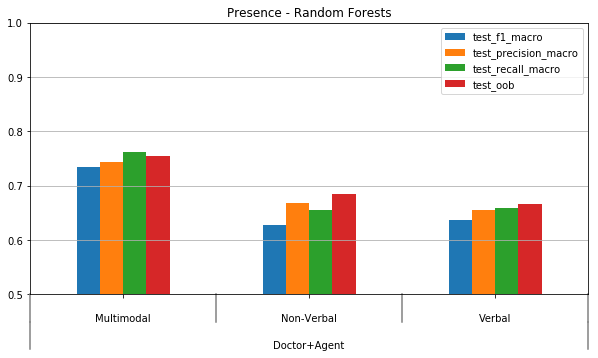

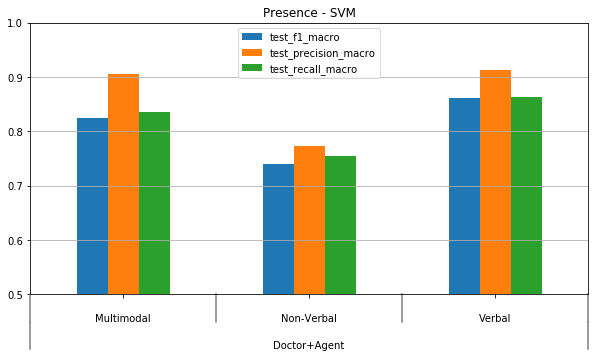

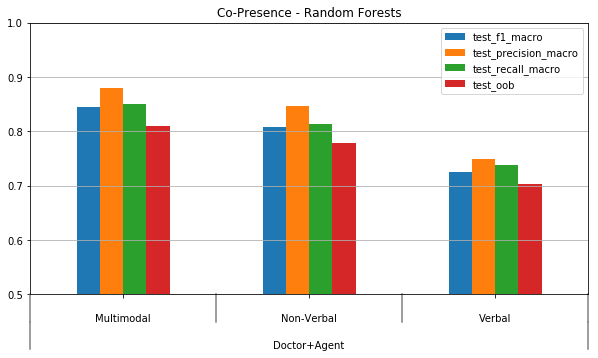

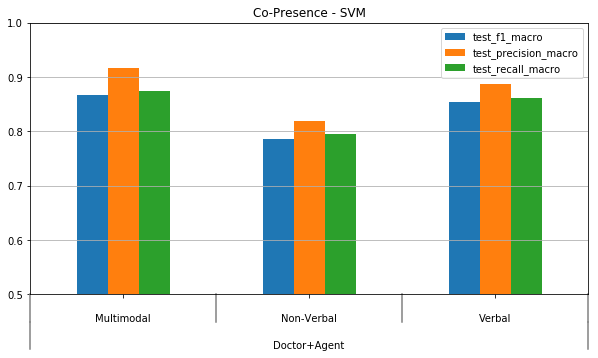

In [91]:
# RF - presence
        
rear = scores_df[['test_f1_macro', 'test_precision_macro', 'test_recall_macro', 'test_oob']].reorder_levels([4,3,0,1,2], axis=0).sort_index()
mydf = rear.loc['score', 'Random Forests', 'Presence', 'Doctor+Agent', ['Verbal', 'Non-Verbal', 'Multimodal']]

mydf.index = mydf.index.remove_unused_levels()
mydf.index = mydf.index.droplevel([0,1,2])
mydf = mydf.sort_index()
#mydf = mydf.rename({'Verbal': 'V', 'Non-Verbal': 'NV', 'Multimodal': 'M', 'Multimodal+Duration': 'M+D'}, 
#                   level=1,
#                   axis='index')
ax = mydf.plot(kind='bar',yerr=rear.loc['err', 'Random Forests', 'Presence', 'Doctor+Agent'] / 10,
               stacked=False, 
               figsize=(10,5),
               title='Presence - Random Forests',
              capsize=2)
#Below 2 lines remove default labels
ax.set_xticklabels('')
ax.set_xlabel('')
ax.set_ylim([0.5, 1])
ax.grid(axis='y')
label_group_bar_table(ax, mydf, 2)
plt.savefig(os.path.join(dh.root_path, 'scores_bar_modalities_presence_rf_docagent.png'), bbox_inches = "tight")
plt.show()

# SVM - presence

mydf = rear.loc['score', 'SVM', 'Presence', 'Doctor+Agent', ['Verbal', 'Non-Verbal', 'Multimodal']]
mydf.index = mydf.index.remove_unused_levels()
mydf.index = mydf.index.droplevel([0,1,2])
mydf = mydf.drop(['test_oob'], axis=1)
mydf.sort_index()
#mydf = mydf.rename({'Verbal': 'V', 'Non-Verbal': 'NV', 'Multimodal': 'M', 'Multimodal+Duration': 'M+D'}, 
#                   level=1, 
#                   axis='index')
ax = mydf.plot(kind='bar',
               yerr=rear.loc['err', 'SVM', 'Presence', 'Doctor+Agent'] / 10,
               stacked=False, 
               figsize=(10,5),
               title='Presence - SVM')
#Below 2 lines remove default labels
ax.set_xticklabels('')
ax.set_xlabel('')
ax.set_ylim([0.5, 1])
ax.grid(axis='y')
label_group_bar_table(ax, mydf, 2)
plt.savefig(os.path.join(dh.root_path, 'scores_bar_modalities_presence_svm_docagent.png'), bbox_inches = "tight")
plt.show()


# RF - CO-Presence

mydf = rear.loc['score', 'Random Forests', 'Co-Presence', 'Doctor+Agent', ['Verbal', 'Non-Verbal', 'Multimodal']]

mydf.index = mydf.index.remove_unused_levels()
mydf.index = mydf.index.droplevel([0,1,2])
mydf = mydf.sort_index()
#mydf = mydf.rename({'Verbal': 'V', 'Non-Verbal': 'NV', 'Multimodal': 'M', 'Multimodal+Duration': 'M+D'}, 
#                   level=1,
#                   axis='index')
ax = mydf.plot(kind='bar',yerr=rear.loc['err', 'Random Forests', 'Co-Presence', 'Doctor+Agent'] / 10,
               stacked=False, 
               figsize=(10,5),
               title='Co-Presence - Random Forests',
              capsize=2)
#Below 2 lines remove default labels
ax.set_xticklabels('')
ax.set_xlabel('')
ax.set_ylim([0.5, 1])
ax.grid(axis='y')
label_group_bar_table(ax, mydf, 2)
plt.savefig(os.path.join(dh.root_path, 'scores_bar_modalities_copresence_rf_docagent.png'), bbox_inches = "tight")
plt.show()

# SVM - CO-presence

mydf = rear.loc['score', 'SVM', 'Co-Presence', 'Doctor+Agent', ['Verbal', 'Non-Verbal', 'Multimodal']]
mydf.index = mydf.index.remove_unused_levels()
mydf.index = mydf.index.droplevel([0,1,2])
mydf = mydf.drop(['test_oob'], axis=1)
mydf.sort_index()
#mydf = mydf.rename({'Verbal': 'V', 'Non-Verbal': 'NV', 'Multimodal': 'M', 'Multimodal+Duration': 'M+D'}, 
#                   level=1, 
#                   axis='index')
ax = mydf.plot(kind='bar',
               yerr=rear.loc['err', 'SVM', 'Co-Presence', 'Doctor+Agent'] / 10,
               stacked=False, 
               figsize=(10,5),
               title='Co-Presence - SVM')
#Below 2 lines remove default labels
ax.set_xticklabels('')
ax.set_xlabel('')
ax.set_ylim([0.5, 1])
ax.grid(axis='y')
label_group_bar_table(ax, mydf, 2)
plt.savefig(os.path.join(dh.root_path, 'scores_bar_modalities_copresence_svm_docagent.png'), bbox_inches = "tight")
plt.show()

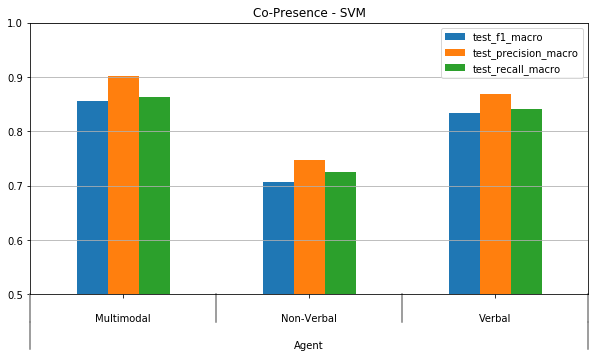

In [92]:
# RF - presence
        
rear = scores_df[['test_f1_macro', 'test_precision_macro', 'test_recall_macro', 'test_oob']].reorder_levels([4,3,0,1,2], axis=0).sort_index()
mydf = rear.loc['score', 'Random Forests', 'Presence', 'Agent', ['Verbal', 'Non-Verbal', 'Multimodal']]


# SVM - CO-presence - Agent

mydf = rear.loc['score', 'SVM', 'Co-Presence', 'Agent', ['Verbal', 'Non-Verbal', 'Multimodal']]
mydf.index = mydf.index.remove_unused_levels()
mydf.index = mydf.index.droplevel([0,1,2])
mydf = mydf.drop(['test_oob'], axis=1)
mydf.sort_index()
#mydf = mydf.rename({'Verbal': 'V', 'Non-Verbal': 'NV', 'Multimodal': 'M', 'Multimodal+Duration': 'M+D'}, 
#                   level=1, 
#                   axis='index')
ax = mydf.plot(kind='bar',
               yerr=rear.loc['err', 'SVM', 'Co-Presence', 'Doctor+Agent'] / 10,
               stacked=False, 
               figsize=(10,5),
               title='Co-Presence - SVM')
#Below 2 lines remove default labels
ax.set_xticklabels('')
ax.set_xlabel('')
ax.set_ylim([0.5, 1])
ax.grid(axis='y')
label_group_bar_table(ax, mydf, 2)
plt.savefig(os.path.join(dh.root_path, 'scores_bar_modalities_copresence_svm_agent.png'), bbox_inches = "tight")
plt.show()

## Phases vs no phase

In [101]:
# Graphs for SVM phases vs no phase, Presence and Co-Presence

dh = DataHandler('1-subject-agent_phases-nophase', 2)
scores_df_index = [['Presence', 'Co-Presence'], 
             ['Doctor', 'Agent', 'Doctor+Agent'], 
             ['No Phase', '157015'], 
             ['Random Forests', 'SVM'],
             ['score', 'err']
            ]
scores_df_columns = ['precision', 'f1', 'recall', 'params']
scores_df_multiindex = pd.MultiIndex.from_product(scores_df_index, 
                                                  names=['Metric', 'Subject', 'Phases', 'Classifier', 'Metric'])
scores_df = dh.load_obj('results', 'scores')
if scores_df is None:
    print("No data to load, nothing to draw")
    
scores_df

test_f1_macro  \
Metric      Subject      Phases   Classifier     Metric                  
Presence    Doctor       No Phase Random Forests score        0.755079   
                                                 err          0.127132   
                                  SVM            score        0.850909   
                                                 err          0.122116   
                         157015   Random Forests score        0.731994   
                                                 err          0.126633   
                                  SVM            score        0.820618   
                                                 err          0.140041   
            Agent        No Phase Random Forests score        0.713995   
                                                 err          0.168300   
                                  SVM            score        0.782612   
                                                 err          0.144296   
                         157015   Random Forests score        0.729269   
                                                 err          0.149047   
                                  SVM            score        0.855522   
                                                 err          0.097705   
            Doctor+Agent No Phase Random Forests score        0.729048   
                                                 err          0.182982   
                                  SVM            score        0.768696   
                                                 err          0.118449   
                         157015   Random Forests score        0.768095   
                                                 err          0.074107   
                                  SVM            score        0.825866   
                                                 err          0.138884   
Co-Presence Doctor       No Phase Random Forests score        0.714851   
                                                 err          0.095619   
                                  SVM            score        0.925926   
                                                 err          0.102068   
                         157015   Random Forests score        0.745026   
                                                 err          0.148344   
                                  SVM            score        0.839788   
                                                 err          0.092845   
            Agent        No Phase Random Forests score        0.817116   
                                                 err          0.111463   
                                  SVM            score        0.852232   
                                                 err          0.097975   
                         157015   Random Forests score        0.746376   
                                                 err          0.176907   
                                  SVM            score        0.842655   
                                                 err          0.121197   
            Doctor+Agent No Phase Random Forests score        0.892222   
                                                 err          0.092037   
                                  SVM            score        0.878581   
                                                 err          0.099512   
                         157015   Random Forests score        0.845132   
                                                 err          0.092801   
                                  SVM            score        0.872797   
                                                 err          0.119056   

                                                         test_f1_macro_class_1  \
Metric      Subject      Phases   Classifier     Metric                          
Presence    Doctor       No Phase Random Forests score                0.860159   
                                                 err                  0.112661   
                            

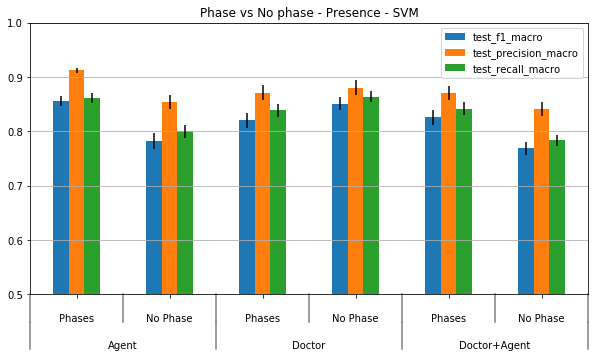

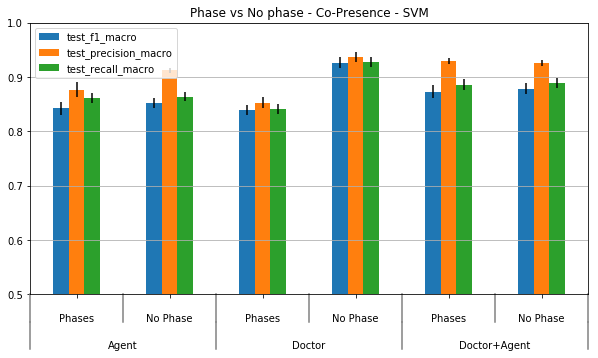

In [102]:
        
rear = scores_df[['test_f1_macro', 'test_precision_macro', 'test_recall_macro', 'test_oob']].reorder_levels([4,3,0,1,2], axis=0).sort_index()


# SVM - presence

mydf = rear.loc['score', 'SVM', 'Presence']
mydf.index = mydf.index.remove_unused_levels()
mydf = mydf.drop(['test_oob'], axis=1)
mydf.sort_index()
mydf = mydf.rename({'157015': 'Phases'}, 
                   level=1, 
                   axis='index')
ax = mydf.plot(kind='bar',
               yerr=rear.loc['err', 'SVM', 'Presence'].rename({'157015': 'Phases'}, 
                   level=1, 
                   axis='index') / 10,
               stacked=False, 
               figsize=(10,5),
               title='Phase vs No phase - Presence - SVM')
#Below 2 lines remove default labels
ax.set_xticklabels('')
ax.set_xlabel('')
ax.set_ylim([0.5, 1])
ax.grid(axis='y')
label_group_bar_table(ax, mydf, 2)
plt.savefig(os.path.join(dh.root_path, 'scores_bar_phases_presence_svm.png'), bbox_inches = "tight")
plt.show()


# SVM - CO-presence

mydf = rear.loc['score', 'SVM', 'Co-Presence']
mydf.index = mydf.index.remove_unused_levels()
mydf = mydf.drop(['test_oob'], axis=1)
mydf.sort_index()
mydf = mydf.rename({'157015': 'Phases'}, 
                   level=1, 
                   axis='index')
ax = mydf.plot(kind='bar',
               yerr=rear.loc['err', 'SVM', 'Co-Presence'].rename({'157015': 'Phases'}, 
                   level=1, 
                   axis='index') / 10,
               stacked=False, 
               figsize=(10,5),
               title='Phase vs No phase - Co-Presence - SVM')
#Below 2 lines remove default labels
ax.set_xticklabels('')
ax.set_xlabel('')
ax.set_ylim([0.5, 1])
ax.grid(axis='y')
label_group_bar_table(ax, mydf, 2)
plt.savefig(os.path.join(dh.root_path, 'scores_bar_phases_copresence_svm.png'), bbox_inches = "tight")
plt.show()

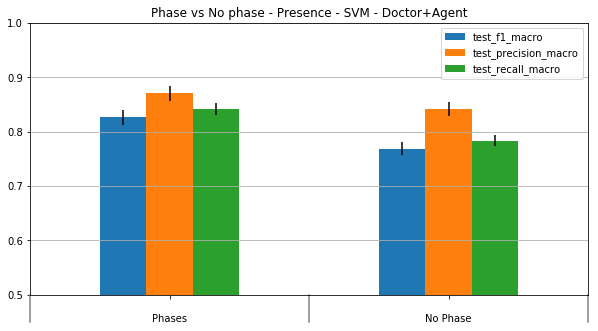

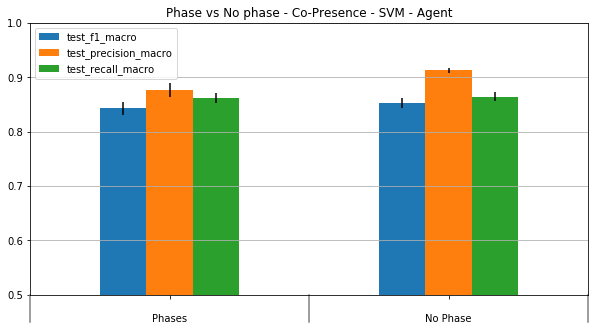

In [103]:
rear = scores_df[['test_f1_macro', 'test_precision_macro', 'test_recall_macro', 'test_oob']].reorder_levels([4,3,0,1,2], axis=0).sort_index()


# SVM - presence - doctor + agent

mydf = rear.loc['score', 'SVM', 'Presence', 'Doctor+Agent']
#mydf.index = mydf.index.remove_unused_levels()
mydf = mydf.drop(['test_oob'], axis=1)
mydf.sort_index()
mydf = mydf.rename({'157015': 'Phases'}, 
                   level=0, 
                   axis='index')
ax = mydf.plot(kind='bar',
               yerr=rear.loc['err', 'SVM', 'Presence', 'Doctor+Agent'].rename({'157015': 'Phases'}, 
                   level=0, 
                   axis='index') / 10,
               stacked=False, 
               figsize=(10,5),
               title='Phase vs No phase - Presence - SVM - Doctor+Agent')
#Below 2 lines remove default labels
ax.set_xticklabels('')
ax.set_xlabel('')
ax.set_ylim([0.5, 1])
ax.grid(axis='y')
label_group_bar_table(ax, mydf, 1)
plt.savefig(os.path.join(dh.root_path, 'scores_bar_phases_presence_svm_docagent.png'), bbox_inches = "tight")
plt.show()


# SVM - CO-presence

mydf = rear.loc['score', 'SVM', 'Co-Presence', 'Agent']
#mydf.index = mydf.index.remove_unused_levels()
mydf = mydf.drop(['test_oob'], axis=1)
mydf.sort_index()
mydf = mydf.rename({'157015': 'Phases'}, 
                   level=0, 
                   axis='index')
ax = mydf.plot(kind='bar',
               yerr=rear.loc['err', 'SVM', 'Co-Presence', 'Agent'].rename({'157015': 'Phases'}, 
                   level=0, 
                   axis='index') / 10,
               stacked=False, 
               figsize=(10,5),
               title='Phase vs No phase - Co-Presence - SVM - Agent')
#Below 2 lines remove default labels
ax.set_xticklabels('')
ax.set_xlabel('')
ax.set_ylim([0.5, 1])
ax.grid(axis='y')
label_group_bar_table(ax, mydf, 1)
plt.savefig(os.path.join(dh.root_path, 'scores_bar_phases_copresence_svm_agent.png'), bbox_inches = "tight")
plt.show()

## Exploring learnt classifiers
### Verbal / non-verbal


In [161]:

# reload best params found

dh = DataHandler('2-verbal-nonverbal-multimodal-duration', 2)
scores_df_index = [['Presence', 'Co-Presence'], 
             ['Doctor', 'Agent', 'Doctor+Agent'], 
             ['Verbal', 'Non-Verbal', 'Multimodal', 'Multimodal+Duration'], 
             ['Random Forests', 'SVM'],
             ['score', 'err']
            ]
scores_df_multiindex = pd.MultiIndex.from_product(scores_df_index, 
                                                  names=['Metric', 'Subject', 'Mode', 'Classifier', 'Metric'])
scores_df = dh.load_obj('results', 'scores')
if scores_df is None:
    print("No results to load !")
 
context_df = pd.read_csv(os.path.join(dh.root_path, 'context.csv'))
if context_df is None:
    print("missing contextual info context.pkl")
    
context_df.index = scores_df_multiindex
context_df


Metric  \
Metric      Subject      Mode                Classifier     Metric                
Presence    Doctor       Verbal              Random Forests score      Presence   
                                                            err        Presence   
                                             SVM            score      Presence   
                                                            err        Presence   
                         Non-Verbal          Random Forests score      Presence   
                                                            err        Presence   
                                             SVM            score      Presence   
                                                            err        Presence   
                         Multimodal          Random Forests score      Presence   
                                                            err        Presence   
                                             SVM            score      Presence   
                                                            err        Presence   
                         Multimodal+Duration Random Forests score      Presence   
                                                            err        Presence   
                                             SVM            score      Presence   
                                                            err        Presence   
            Agent        Verbal              Random Forests score      Presence   
                                                            err        Presence   
                                             SVM            score      Presence   
                                                            err        Presence   
                         Non-Verbal          Random Forests score      Presence   
                                                            err        Presence   
                                             SVM            score      Presence   
                                                            err        Presence   
                         Multimodal          Random Forests score      Presence   
                                                            err        Presence   
                                             SVM            score      Presence   
                                                            err        Presence   
                         Multimodal+Duration Random Forests score      Presence   
                                                            err        Presence   
...                                                                         ...   
Co-Presence Agent        Verbal              SVM            score   Co-Presence   
                                                            err     Co-Presence   
                         Non-Verbal          Random Forests score   Co-Presence   
                                                            err     Co-Presence   
                                             SVM            score   Co-Presence   
                                                            err     Co-Presence   
                         Multimodal          Random Forests score   Co-Presence   
                                                            err     Co-Presence   
                                             SVM            score   Co-Presence   
                                                            err     Co-Presence   
                         Multimodal+Duration Random Forests score   Co-Presence   
                                                            err     Co-Presence   
                                             SVM            score   Co-Presence   
                                                            err     Co-Presence   
            Doctor+Agent Verbal              Random Forests score   Co-Presence   
                                                            err     Co-Presence   
      

In [309]:
print(str([scorer for scorer in sklearn.metrics.SCORERS.keys() if scorer.endswith('loss')]))

['neg_log_loss', 'brier_score_loss']


Test 0 : {'subject': 'doctor+agent', 'target': 'presence', 'classifier': 'forest', 'modes': 'verbal'}
  Computing learning curve for best params : {'max_features': None, 'n_estimators': 300, 'max_depth': None, 'min_samples_leaf': 1}
[35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58
 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77]
(array([1, 2, 3], dtype=int64), array([35, 35, 35]))
Test 1 : {'subject': 'doctor+agent', 'target': 'copresence', 'classifier': 'forest', 'modes': 'verbal'}
  Computing learning curve for best params : {'max_features': 'sqrt', 'n_estimators': 300, 'max_depth': None, 'min_samples_leaf': 1}
[35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58
 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77]
(array([1, 2, 3], dtype=int64), array([36, 36, 36]))
Test 2 : {'subject': 'doctor', 'target': 'presence', 'classifier': 'forest', 'modes': 'verbal'}
  Computing learning curve for best params : {'max_features': 's

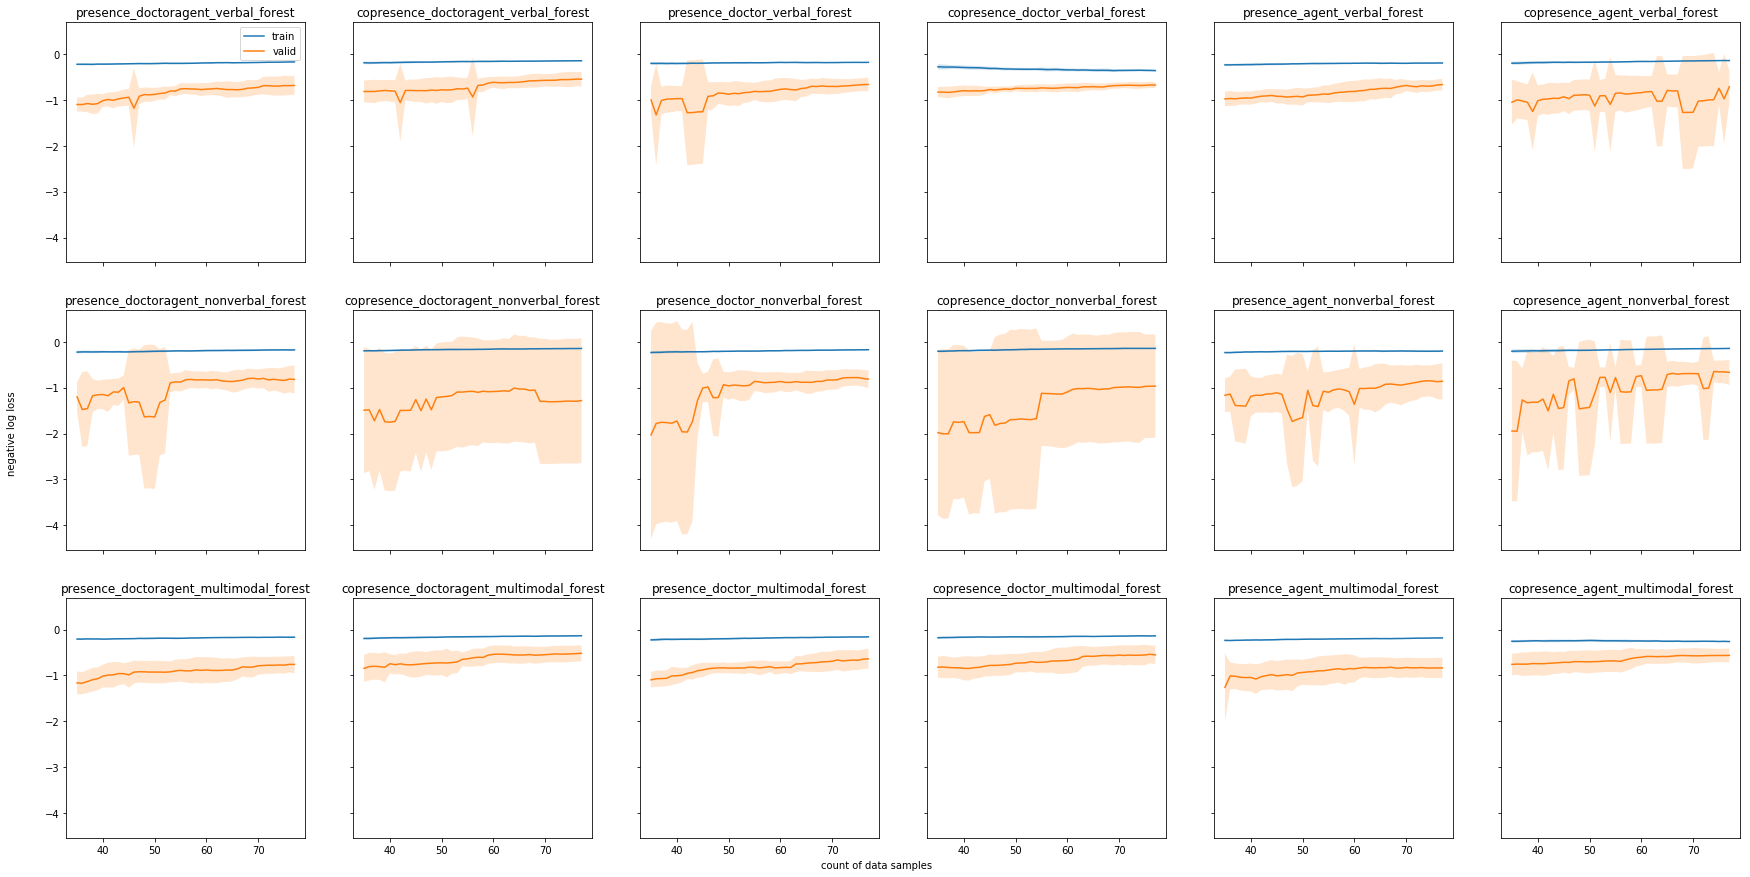

In [162]:
from sklearn.model_selection import learning_curve

test_plan_params = {
    'classifier': ['forest'],
    'subject': ['doctor+agent', 'doctor', 'agent'],
    'target': ['presence', 'copresence'],
    'modes': ['verbal', 'nonverbal', 'multimodal']
}
test_plan = list(ParameterGrid(test_plan_params))

forest = RandomForestClassifier(random_state=RANDOM_STATE, oob_score=True)
svm = make_pipeline(StandardScaler(), SVC(random_state=RANDOM_STATE, probability=True))

# whether to apply 'original' upsampling method
upsample = True

cols= 6
fig, ax = plt.subplots(int(len(test_plan)/cols), cols, sharex=True, sharey=True, figsize=(30,15))

results = {}

for idx, test in enumerate(test_plan):
    print("Test %d : %s" % (idx, test))
    

    subject = test['subject']
    target = test['target']
    modes = test['modes']
    classifier = test['classifier']
    clf = forest if classifier == 'forest' else svm

    if subject == 'doctor':
        df = subject_np_df
        if modes == 'verbal':
            feats = subject_features_verbal
        elif modes == 'nonverbal':
            feats = subject_features_nonverbal
        elif modes == 'multimodal':
            feats = subject_features_multimodal
        elif modes == 'multimodal+duration':
            feats = subject_features_multimodal_duration
    elif subject == 'agent':
        df = agent_np_df
        if modes == 'verbal':
            feats = agent_features_verbal
        elif modes == 'nonverbal':
            feats = agent_features_nonverbal
        elif modes == 'multimodal':
            feats = agent_features_multimodal
        elif modes == 'multimodal+duration':
            feats = agent_features_multimodal_duration        
    else:
        df = all_np_df
        if modes == 'verbal':
            feats = all_features_verbal
        elif modes == 'nonverbal':
            feats = all_features_nonverbal
        elif modes == 'multimodal':
            feats = all_features_multimodal
        elif modes == 'multimodal+duration':
            feats = all_features_multimodal_duration        
    
    X, y = prepare_train_data(samples=df, features=feats, target_model=target, upsample=upsample) 
    
    isDoc = 'doctor' in subject
    isAgent = 'agent' in subject
    presidx = 'Presence' if target == 'presence' else 'Co-Presence'
    if subject == 'doctor':
        subjidx = 'Doctor'
    elif subject == 'agent':
        subjidx = 'Agent'
    else:
        subjidx = 'Doctor+Agent'
    if modes == 'verbal':
        phidx = 'Verbal'
    elif modes == 'nonverbal':
        phidx = 'Non-Verbal'
    elif modes == 'multimodal':
        phidx = 'Multimodal'
    elif modes == 'multimodal+duration':
        phidx = 'Multimodal+Duration'
    clfidx = 'Random Forests' if classifier == 'forest' else 'SVM'

    test_set_name = dh.get_grid_name(target=='presence', isDoc, isAgent, modes, classifier)
    
    # create classifier from best params found previously
    best_params = context_df.loc[presidx, subjidx, phidx, clfidx, 'score']['Best Params']
    clf.set_params(**eval(best_params))
    print("  Computing learning curve for best params : %s" % str(best_params))

    train_sizes = np.arange(35, len(df))
    print(train_sizes)
    print(np.unique(y, return_counts=True))
    train_sizes, train_scores, test_scores = learning_curve(clf, 
                                                            X, y, 
                                                            train_sizes=train_sizes, 
                                                            cv=10, 
                                                            scoring='neg_log_loss',
                                                            shuffle=True)

    results[test_set_name] = {}
    results[test_set_name]['train'] = train_scores
    results[test_set_name]['test'] = test_scores
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    cur_ax = ax[int(idx / cols), (idx) % cols]
    cur_ax.plot(train_sizes, train_scores_mean, label='train')
    cur_ax.fill_between(train_sizes, train_scores_mean + train_scores_std,
                    train_scores_mean - train_scores_std, alpha=0.2)

    cur_ax.plot(train_sizes, test_scores_mean, label='valid')
    cur_ax.fill_between(train_sizes, test_scores_mean + test_scores_std,
                    test_scores_mean - test_scores_std, alpha=0.2)
    cur_ax.set_title(test_set_name)
    #cur_ax.xlabel("Count of samples")
    #cur_ax.ylabel("Negative log loss")
    if idx == 0: cur_ax.legend()
fig.text(0.5, 0.1, 'count of data samples', ha='center', va='center')
fig.text(0.1, 0.5, 'negative log loss', ha='center', va='center', rotation='vertical')
dh.save_fig('learning_curves_verbal-nonverbal_forest.png') 
plt.show()

In [163]:
dh.save_obj(results, 'learning_curves', 'forest')

True

For non-verbal case we only have 2 features, we have then a chance to vizualize the classification results for some classifiers.

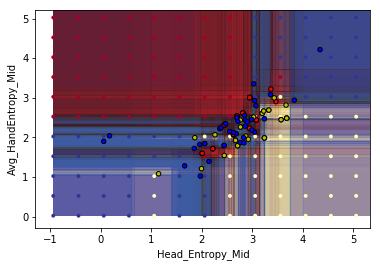

In [166]:
from matplotlib.colors import ListedColormap

df = subject_np_df
feats = subject_features_nonverbal
target = 'presence'

n_classes = 3
cmap = plt.cm.RdYlBu
plot_step = 0.02  # fine step width for decision surface contours
plot_step_coarser = 0.5  # step widths for coarse classifier guesses

best_params = context_df.loc['Presence', 'Doctor', 'Non-Verbal', 'Random Forests', 'score']['Best Params']
forest.set_params(**eval(best_params))
X, y = prepare_train_data(samples=df, features=feats, target_model=target, upsample=upsample) 
forest.fit(X,y)

model = forest
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step),
                     np.arange(y_min, y_max, plot_step))

# alpha blend the
# decision surfaces of the ensemble of classifiers

# Choose alpha blend level with respect to the number
# of estimators
# that are in use (noting that AdaBoost can use fewer estimators
# than its maximum if it achieves a good enough fit early on)
estimator_alpha = 1.0 / len(model.estimators_)
for tree in model.estimators_:
    Z = tree.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    cs = plt.contourf(xx, yy, Z, alpha=estimator_alpha, cmap=cmap)

# Build a coarser grid to plot a set of ensemble classifications
# to show how these are different to what we see in the decision
# surfaces. These points are regularly space and do not have a
# black outline
xx_coarser, yy_coarser = np.meshgrid(
    np.arange(x_min, x_max, plot_step_coarser),
    np.arange(y_min, y_max, plot_step_coarser))
Z_points_coarser = model.predict(np.c_[xx_coarser.ravel(),
                                 yy_coarser.ravel()]
                                 ).reshape(xx_coarser.shape)
cs_points = plt.scatter(xx_coarser, yy_coarser, s=15,
                        c=Z_points_coarser, cmap=cmap,
                        edgecolors="none")

# Plot the training points, these are clustered together and have a
# black outline
plt.scatter(X[:, 0], X[:, 1], c=y,
            cmap=ListedColormap(['r', 'y', 'b']),
            edgecolor='k', s=20)
plt.xlabel(feats[0])
plt.ylabel(feats[1])
plt.show()

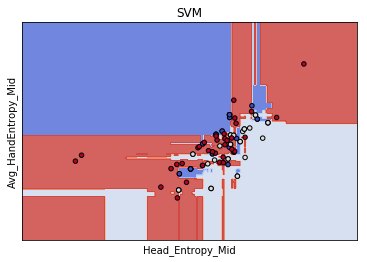

In [170]:
def make_meshgrid(x, y, h=.02):
    """Create a mesh of points to plot in

    Parameters
    ----------
    x: data to base x-axis meshgrid on
    y: data to base y-axis meshgrid on
    h: stepsize for meshgrid, optional

    Returns
    -------
    xx, yy : ndarray
    """
    x_min, x_max = x.min() - 1, x.max() + 1
    y_min, y_max = y.min() - 1, y.max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    return xx, yy


def plot_contours(clf, xx, yy, **params):
    """Plot the decision boundaries for a classifier.

    Parameters
    ----------
    ax: matplotlib axes object
    clf: a classifier
    xx: meshgrid ndarray
    yy: meshgrid ndarray
    params: dictionary of params to pass to contourf, optional
    """
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    plt.contourf(xx, yy, Z, **params)
    

df = subject_np_df
feats = subject_features_nonverbal
target = 'presence'

n_classes = 3
cmap = plt.cm.RdYlBu
plot_step = 0.02  # fine step width for decision surface contours
plot_step_coarser = 0.5  # step widths for coarse classifier guesses

best_params = context_df.loc['Presence', 'Doctor', 'Non-Verbal', 'SVM', 'score']['Best Params']
svm.set_params(**eval(best_params))
X, y = prepare_train_data(samples=df, features=feats, target_model=target, upsample=upsample) 
svm.fit(X,y)

# Set-up 2x2 grid for plotting.
plt.subplots_adjust(wspace=0.4, hspace=0.4)

X0, X1 = X[:, 0], X[:, 1]
xx, yy = make_meshgrid(X0, X1)

plot_contours(clf, xx, yy,
              cmap=plt.cm.coolwarm, alpha=0.8)
plt.scatter(X0, X1, c=y, cmap=plt.cm.coolwarm, s=20, edgecolors='k')
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.xlabel(feats[0])
plt.ylabel(feats[1])
plt.xticks(())
plt.yticks(())
plt.title('SVM')

plt.show()

### phase / no phase

In [171]:
# Graphs for SVM phases vs no phase, Presence and Co-Presence

dh = DataHandler('1-subject-agent_phases-nophase', 2)
scores_df_index = [['Presence', 'Co-Presence'], 
             ['Doctor', 'Agent', 'Doctor+Agent'], 
             ['No Phase', '157015'], 
             ['Random Forests', 'SVM'],
             ['score', 'err']
            ]
scores_df_columns = ['precision', 'f1', 'recall', 'params']
scores_df_multiindex = pd.MultiIndex.from_product(scores_df_index, 
                                                  names=['Metric', 'Subject', 'Phases', 'Classifier', 'Metric'])
scores_df = dh.load_obj('results', 'scores')
if scores_df is None:
    print("No data to load, nothing to draw")

context_df = pd.read_csv(os.path.join(dh.root_path, 'context.csv'))
if context_df is None:
    print("missing contextual info context.pkl")
    
context_df.index = scores_df_multiindex
context_df

Metric  \
Metric      Subject      Phases   Classifier     Metric                
Presence    Doctor       No Phase Random Forests score      Presence   
                                                 err        Presence   
                                  SVM            score      Presence   
                                                 err        Presence   
                         157015   Random Forests score      Presence   
                                                 err        Presence   
                                  SVM            score      Presence   
                                                 err        Presence   
            Agent        No Phase Random Forests score      Presence   
                                                 err        Presence   
                                  SVM            score      Presence   
                                                 err        Presence   
                         157015   Random Forests score      Presence   
                                                 err        Presence   
                                  SVM            score      Presence   
                                                 err        Presence   
            Doctor+Agent No Phase Random Forests score      Presence   
                                                 err        Presence   
                                  SVM            score      Presence   
                                                 err        Presence   
                         157015   Random Forests score      Presence   
                                                 err        Presence   
                                  SVM            score      Presence   
                                                 err        Presence   
Co-Presence Doctor       No Phase Random Forests score   Co-Presence   
                                                 err     Co-Presence   
                                  SVM            score   Co-Presence   
                                                 err     Co-Presence   
                         157015   Random Forests score   Co-Presence   
                                                 err     Co-Presence   
                                  SVM            score   Co-Presence   
                                                 err     Co-Presence   
            Agent        No Phase Random Forests score   Co-Presence   
                                                 err     Co-Presence   
                                  SVM            score   Co-Presence   
                                                 err     Co-Presence   
                         157015   Random Forests score   Co-Presence   
                                                 err     Co-Presence   
                                  SVM            score   Co-Presence   
                                                 err     Co-Presence   
            Doctor+Agent No Phase Random Forests score   Co-Presence   
                                                 err     Co-Presence   
                                  SVM            score   Co-Presence   
                                                 err     Co-Presence   
                         157015   Random Forests score   Co-Presence   
                                                 err     Co-Presence   
                                  SVM            score   Co-Presence   
                                                 err     Co-Presence   

                                                              Subject  \
Metric      Subject      Phases   Classifier     Metric                 
Presence    Doctor       No Phase Random Forests score         Doctor   
                                                 err           Doctor   
                                  SVM            score         Doctor   
                                                 err           Doctor   
                       

Test 0 : {'phases': (0, 1, 0), 'target': 'presence', 'classifier': 'forest', 'subject': 'doctor+agent'}
No phase
  Computing learning curve for best params : {'max_features': 'sqrt', 'n_estimators': 300, 'max_depth': 5, 'min_samples_leaf': 1}
[35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58
 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77]
(array([1, 2, 3], dtype=int64), array([35, 35, 35]))
Test 1 : {'phases': (0, 1, 0), 'target': 'copresence', 'classifier': 'forest', 'subject': 'doctor+agent'}
No phase
  Computing learning curve for best params : {'max_features': 'sqrt', 'n_estimators': 300, 'max_depth': 5, 'min_samples_leaf': 1}
[35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58
 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77]
(array([1, 2, 3], dtype=int64), array([36, 36, 36]))
Test 2 : {'phases': (0, 1, 0), 'target': 'presence', 'classifier': 'forest', 'subject': 'doctor'}
No phase
  Computing learning curve for best

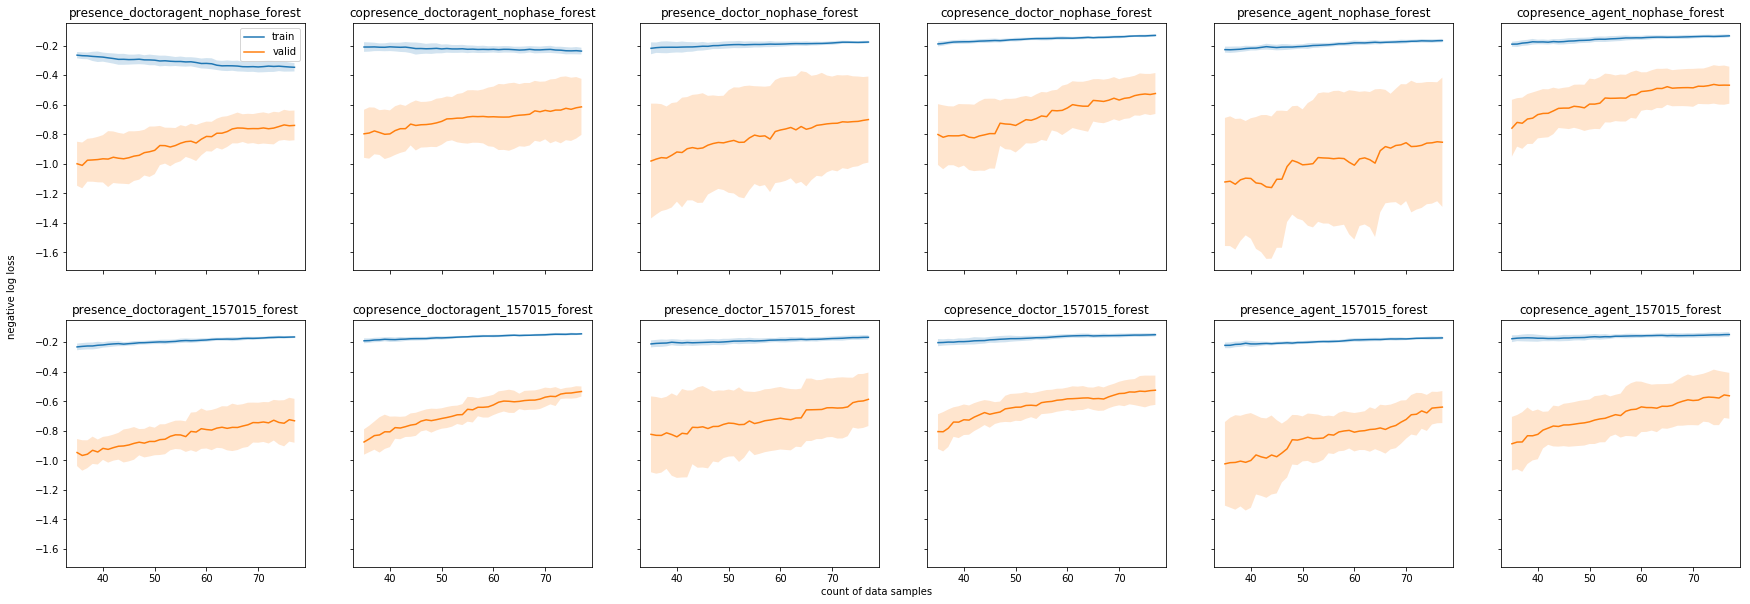

In [172]:
test_plan_params = {
    'classifier': ['forest'],
    'subject': ['doctor+agent', 'doctor', 'agent'],
    'target': ['presence', 'copresence'],
    'phases': [(0,1,0), (0.15,0.70,0.15)]
}
test_plan = list(ParameterGrid(test_plan_params))

forest = RandomForestClassifier(random_state=RANDOM_STATE, oob_score=True)
svm = make_pipeline(StandardScaler(), SVC(random_state=RANDOM_STATE, probability=True))

# whether to apply 'original' upsampling method
upsample = True

cols= 6
fig, ax = plt.subplots(int(len(test_plan)/cols), cols, sharex=True, sharey=True, figsize=(30,10))

results = {}

for idx, test in enumerate(test_plan):
    print("Test %d : %s" % (idx, test))
    

    subject = test['subject']
    target = test['target']
    phases = test['phases']
    classifier = test['classifier']
    clf = forest if classifier == 'forest' else svm
    pgrid = param_grid_rf if classifier == 'forest' else param_grid_svm

    if phases is not None and not phases == (0,1,0):
        print("phases " + str(phases))
        if subject == 'doctor':
            df = subject_p_df
            feats = subject_features
        elif subject == 'agent':
            df = agent_p_df
            feats = agent_features
        elif subject == 'doctor+agent':
            df = all_p_df
            feats=all_features
    else:
        print("No phase")
        if subject == 'doctor':
            df = subject_np_df
            feats = subject_features_nophase
        elif subject == 'agent':
            df = agent_np_df
            feats = agent_features_nophase
        elif subject == 'doctor+agent':
            df = all_np_df
            feats=all_features_nophase        
    
    X, y = prepare_train_data(samples=df, features=feats, target_model=target, upsample=upsample) 
    
    isDoc = 'doctor' in subject
    isAgent = 'agent' in subject
    presidx = 'Presence' if target == 'presence' else 'Co-Presence'
    if subject == 'doctor':
        subjidx = 'Doctor'
    elif subject == 'agent':
        subjidx = 'Agent'
    else:
        subjidx = 'Doctor+Agent'
    phidx = 'No Phase' if phases in [None, (0,1,0)] else '%02d%02d%02d' % ( phases[0]*100, phases[1]*100, phases[2]*100 )
    clfidx = 'Random Forests' if classifier == 'forest' else 'SVM'

    test_set_name = dh.get_grid_name(target=='presence', isDoc, isAgent, phases, classifier)
    
    # create classifier from best params found previously
    best_params = context_df.loc[presidx, subjidx, phidx, clfidx, 'score']['Best Params']
    clf.set_params(**eval(best_params))
    print("  Computing learning curve for best params : %s" % str(best_params))

    train_sizes = np.arange(35, len(df))
    print(train_sizes)
    print(np.unique(y, return_counts=True))
    train_sizes, train_scores, test_scores = learning_curve(clf, 
                                                            X, y, 
                                                            train_sizes=train_sizes, 
                                                            cv=10, 
                                                            scoring='neg_log_loss',
                                                            shuffle=True)

    results[test_set_name] = {}
    results[test_set_name]['train'] = train_scores
    results[test_set_name]['test'] = test_scores
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    cur_ax = ax[int(idx / cols), (idx) % cols]
    cur_ax.plot(train_sizes, train_scores_mean, label='train')
    cur_ax.fill_between(train_sizes, train_scores_mean + train_scores_std,
                    train_scores_mean - train_scores_std, alpha=0.2)

    cur_ax.plot(train_sizes, test_scores_mean, label='valid')
    cur_ax.fill_between(train_sizes, test_scores_mean + test_scores_std,
                    test_scores_mean - test_scores_std, alpha=0.2)
    cur_ax.set_title(test_set_name)
    #cur_ax.xlabel("Count of samples")
    #cur_ax.ylabel("Negative log loss")
    if idx == 0: cur_ax.legend()
fig.text(0.5, 0.09, 'count of data samples', ha='center', va='center')
fig.text(0.1, 0.5, 'negative log loss', ha='center', va='center', rotation='vertical')
dh.save_fig('learning_curves_phase-nophase_forest.png') 
plt.show()

In [174]:
dh.save_obj(results, 'learning_curves', 'forest')

True

In [96]:
plt.show()

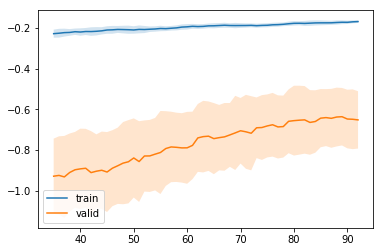

In [313]:
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)
plt.plot(train_sizes, train_scores_mean, label='train')
plt.fill_between(train_sizes, train_scores_mean + train_scores_std,
                train_scores_mean - train_scores_std, alpha=0.2)

plt.plot(train_sizes, test_scores_mean, label='valid')
plt.fill_between(train_sizes, test_scores_mean + test_scores_std,
                test_scores_mean - test_scores_std, alpha=0.2)
plt.legend()
plt.show()

In [304]:
from sklearn.model_selection import validation_curve

train_scores, valid_scores = validation_curve(clf, X, y, "n_estimators",
                                               np.arange(1, 300, 10),
                                               cv=10)

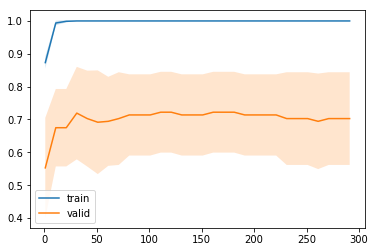

In [306]:
test_scores = valid_scores
x_range = np.arange(1,300,10)
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)
plt.plot(x_range, train_scores_mean, label='train')
plt.fill_between(x_range, train_scores_mean + train_scores_std,
                train_scores_mean - train_scores_std, alpha=0.2)

plt.plot(x_range, test_scores_mean, label='valid')
plt.fill_between(x_range, test_scores_mean + test_scores_std,
                test_scores_mean - test_scores_std, alpha=0.2)
plt.legend()
plt.show()

In [ ]:
from mlxtend.plotting import plot_decision_regions

plot_decision_regions(X=X, y=y, clf=clf, legend=2)
plt.xlabel("x", size=5)
plt.ylabel("y", size=5)
plt.title('SVM Decision Region Boundary', size=6)
plt.show()

## Specific tests on 'Expert' feature

In [42]:
# specific test on expert importance

subject_features = ("Expert", "Head_Entropy_Start", "Head_Entropy_Mid", "Head_Entropy_End", "Avg_HandEntropy_Begin",
             "Avg_HandEntropy_Mid", "Avg_HandEntropy_End", "Avg_SentenceLength_Begin", "Avg_SentenceLength_Mid",
             "Avg_SentenceLength_End",  "Ratio1_Begin", "Ratio1_Mid", "Ratio1_End", "Ratio2_Begin", "Ratio2_Mid", 
                    "Ratio2_End", "Duration")

subject_noexpert_features = ("Head_Entropy_Start", "Head_Entropy_Mid", "Head_Entropy_End", "Avg_HandEntropy_Begin",
             "Avg_HandEntropy_Mid", "Avg_HandEntropy_End", "Avg_SentenceLength_Begin", "Avg_SentenceLength_Mid",
             "Avg_SentenceLength_End",  "Ratio1_Begin", "Ratio1_Mid", "Ratio1_End", "Ratio2_Begin", "Ratio2_Mid", 
                    "Ratio2_End", "Duration")

# not using "Expert" feature for agent features
agent_features = ("Head_Entropy_Start", "Head_Entropy_Mid", "Head_Entropy_End", "Avg_HandEntropy_Begin",
             "Avg_HandEntropy_Mid", "Avg_HandEntropy_End", "Avg_SentenceLength_Begin", "Avg_SentenceLength_Mid",
             "Avg_SentenceLength_End",  "Ratio1_Begin", "Ratio1_Mid", "Ratio1_End", "Ratio2_Begin", "Ratio2_Mid", 
                    "Ratio2_End", "Duration")

In [43]:
grid1 = gridsearch(forest, subject_p_df, 'presence', param_grid=param_grid, features=subject_features, upsample=True)
df = pd.DataFrame(grid1.cv_results_)
best_precision = df.mean_test_precision_macro.max()
df_best_1 = pd.DataFrame(df.loc[df['mean_test_precision_macro'] == best_precision])
df_best_val1 = df_best_1.iloc[0]
df_best_1 = pd.DataFrame(df_best_val1.values, columns=['Doctor / Expert'], index=df_best_1.columns).T
df_best_1

Fitting 10 folds for each of 84 candidates, totalling 840 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 840 out of 840 | elapsed:  6.1min finished


ValueError: Shape of passed values is (2, 83), indices imply (1, 83)

In [62]:
grid2 = gridsearch(forest, subject_p_df, 'presence', param_grid=param_grid, features=subject_noexpert_features, upsample=True)
df = pd.DataFrame(grid2.cv_results_)
best_precision = df.mean_test_precision_macro.max()
df_best_ = pd.DataFrame(df.loc[df['mean_test_precision_macro'] == best_precision])
df_best_val2 = df_best_2.iloc[0]
df_best_2 = pd.DataFrame(df_best_val2.values, columns=['Doctor / No Expert'], index=df_best_2.columns).T
df_best_2

Fitting 10 folds for each of 84 candidates, totalling 840 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 840 out of 840 | elapsed:  5.1min finished


In [63]:
grid3 = gridsearch(forest, agent_p_df, 'presence', param_grid=param_grid, features=agent_features, upsample=True)
df = pd.DataFrame(grid3.cv_results_)
best_precision = df.mean_test_precision_macro.max()
df_best_3 = pd.DataFrame(df.loc[df['mean_test_precision_macro'] == best_precision])
df_best_val3 = df_best_3.iloc[0]
df_best_3 = pd.DataFrame(df_best_val3.values, columns=['Agent / No Expert'], index=df_best_3.columns).T
df_best_3

Fitting 10 folds for each of 84 candidates, totalling 840 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 840 out of 840 | elapsed:  5.0min finished


ValueError: Shape of passed values is (6, 83), indices imply (1, 83)

In [64]:
df = pd.DataFrame(grid3.cv_results_)
best_precision = df.mean_test_precision_macro.max()
df_best_3 = pd.DataFrame(df.loc[df['mean_test_precision_macro'] == best_precision])
df_best_val3 = df_best_3.iloc[0]
df_best_3 = pd.DataFrame(df_best_val3.values, columns=['Agent / No Expert'], index=df_best_3.columns).T
df_best_3

,mean_fit_time,mean_score_time,mean_test_f1_macro,mean_test_precision_macro,mean_test_recall_macro,mean_train_f1_macro,mean_train_precision_macro,mean_train_recall_macro,param_class_weight,param_max_features,...,split9_train_precision_macro,split9_train_recall_macro,std_fit_time,std_score_time,std_test_f1_macro,std_test_precision_macro,std_test_recall_macro,std_train_f1_macro,std_train_precision_macro,std_train_recall_macro
Agent / No Expert,0.0141,0.00369997,0.773156,0.831852,0.780952,0.997849,0.997917,0.997849,None,auto,...,1,1,0.00418211,0.00414847,0.118873,0.0914799,0.11225,0.00430219,0.00416667,0.00430108


In [65]:
df_best_all = pd.concat([df_best_1, df_best_2, df_best_3])
df_best_all[['mean_test_precision_macro', 'mean_test_f1_macro', 'mean_test_recall_macro', 'params']]

,mean_test_precision_macro,mean_test_f1_macro,mean_test_recall_macro,params
Doctor / Expert,0.814921,0.746969,0.761905,"{u'max_features': None, u'n_estimators': 50, u..."
Doctor / No Expert,0.836531,0.793405,0.8,"{u'max_features': None, u'n_estimators': 100, ..."
Agent / No Expert,0.831852,0.773156,0.780952,"{u'max_features': u'auto', u'n_estimators': 10..."


In [68]:
df = pd.DataFrame(grid1.cv_results_)
cols = [col for col in df.columns if 'std' in col]
df[cols]

,std_fit_time,std_score_time,std_test_f1_macro,std_test_precision_macro,std_test_recall_macro,std_train_f1_macro,std_train_precision_macro,std_train_recall_macro
0,0.002871,0.002256,0.132134,0.165828,0.121312,0.004827,0.004678,0.004826
1,0.003661,0.001814,0.133546,0.166498,0.118634,0.003126,0.003030,0.003125
2,0.034886,0.003231,0.143855,0.179382,0.125628,0.000000,0.000000,0.000000
3,0.007099,0.004826,0.115380,0.097104,0.114120,0.000000,0.000000,0.000000
4,0.005590,0.002193,0.109027,0.079613,0.109971,0.000000,0.000000,0.000000
5,0.008237,0.003716,0.130162,0.124520,0.121187,0.000000,0.000000,0.000000
6,0.035410,0.018779,0.133596,0.128389,0.123044,0.000000,0.000000,0.000000
7,0.003807,0.003873,0.084147,0.073661,0.088363,0.004168,0.004040,0.004167
8,0.008453,0.002764,0.110407,0.116601,0.101872,0.000000,0.000000,0.000000
9,0.009600,0.004331,0.117534,0.126775,0.116220,0.000000,0.000000,0.000000


In [249]:
import numpy as np, scipy.stats as st

def confint(a):
    return st.t.interval(0.95, len(a)-1, loc=np.mean(a), scale=st.sem(a))

a = [1, 1.1, 0.9, 1.15, 0.8, 1.03, 0.99]
print(confint(a))

(0.8866952590268444, 1.1047333124017271)


In [40]:
rdf.index = rdf.index.swaplevel(2,3)
rdf.sort_index(inplace=True)

In [71]:
rdf

precision        f1  \
Classifier     Metric      Phases   Subject                             
Random Forests Co-Presence 157015   Agent          0.857977  0.843006   
                                    Doctor         0.843895  0.775644   
                                    Doctor+Agent   0.891758  0.857478   
                           No Phase Agent          0.916809  0.893617   
                                    Doctor         0.821652  0.798101   
                                    Doctor+Agent   0.868091  0.827934   
               Presence    157015   Agent          0.810794  0.754127   
                                    Doctor         0.778753  0.723586   
                                    Doctor+Agent   0.782381  0.747407   
                           No Phase Agent          0.763946  0.733961   
                                    Doctor         0.816032  0.776039   
                                    Doctor+Agent   0.844444  0.808904   
SVM            Co-Presence 157015   Agent          0.919678  0.882360   
                                    Doctor         0.881481  0.855305   
                                    Doctor+Agent   0.891209  0.858275   
                           No Phase Agent          0.920391  0.870184   
                                    Doctor         0.897212  0.821709   
                                    Doctor+Agent   0.890761  0.862064   
               Presence    157015   Agent          0.883039  0.793964   
                                    Doctor         0.927302  0.892880   
                                    Doctor+Agent   0.913515  0.862339   
                           No Phase Agent          0.818995  0.784713   
                                    Doctor         0.843900  0.801139   
                                    Doctor+Agent   0.898753  0.843911   

                                                    recall  \
Classifier     Metric      Phases   Subject                  
Random Forests Co-Presence 157015   Agent         0.846154   
                                    Doctor        0.794872   
                                    Doctor+Agent  0.863248   
                           No Phase Agent         0.897436   
                                    Doctor        0.803419   
                                    Doctor+Agent  0.837607   
               Presence    157015   Agent         0.771429   
                                    Doctor        0.742857   
                                    Doctor+Agent  0.752381   
                           No Phase Agent         0.742857   
                                    Doctor        0.780952   
                                    Doctor+Agent  0.819048   
SVM            Co-Presence 157015   Agent         0.888889   
                                    Doctor        0.871795   
                                    Doctor+Agent  0.871795   
                           No Phase Agent         0.880342   
                                    Doctor        0.837607   
                                    Doctor+Agent  0.880342   
               Presence    157015   Agent         0.800000   
                                    Doctor        0.895238   
                                    Doctor+Agent  0.866667   
                           No Phase Agent         0.809524   
                                    Doctor        0.809524   
                                    Doctor+Agent  0.847619   

                                                                                             params  
Classifier     Metric      Phases   Subject                                                          
Random Forests Co-Presence 157015   Agent         {'max_features': None, 'n_estimators': 40, 'cl...  
                                    Doctor        {'max_features': None, 'n_estimators': 10, 'cl...  
                                    Doctor+Agent  {'max_features': 'auto', 'n_estimators': 100, ...  
                           N

# Features importance experiments

We would like to check variance and quality of this estimator.
For this we first experiment cross validations with searching also n_estimators, or fixing it with a high value, and check if and how best parameters vary.
Then we will check for a specific set of params, how results and feature importance vary upon repeated runs.
Depending on results, we will compute feature importance for all test plan.

In [211]:
from sklearn.metrics import make_scorer, f1_score, precision_score, recall_score
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone
import scipy.stats as st


def scoreForest(estimator, X, y):
    """
    Custom scoring function for hyperparameter optimization. In this case, we want to print out the oob score.
    estimator was fitted on train data, X and y here are validation data.
    For OOB we don't need validation data - OOB is inherent to tree building.
    Same for feature importances (with default gini impurity measure done by sklearn).
    We add to this the 
    """
    all_feature_importances.append(estimator.feature_importances_)
    score = estimator.oob_score_
    #print "oob_score_:", score
    return score

def run_cross_val_score(clf, X, y, verbose=1):
    #print("gridsearch(clf=%s, modelTarget=%s, param_grid=%s, features=%s, upsample=%s)" 
    #      % (type(clf), modelTarget, param_grid, features, upsample))

    scoring = {
        'oob' : scoreForest,
        'f1_macro' : 'f1_macro',
        'f1_macro_class_1': make_scorer(f1_score, labels=[1], average='macro'),
        'f1_macro_class_2': make_scorer(f1_score, labels=[2], average='macro'),
        'f1_macro_class_3': make_scorer(f1_score, labels=[3], average='macro'),
        'precision_macro' : 'precision_macro',
        'precision_macro_class_1': make_scorer(precision_score, labels=[1], average='macro'),
        'precision_macro_class_2': make_scorer(precision_score, labels=[2], average='macro'),
        'precision_macro_class_3': make_scorer(precision_score, labels=[3], average='macro'),
        'recall_macro' : 'recall_macro',
        'recall_macro_class_1': make_scorer(recall_score, labels=[1], average='macro'),
        'recall_macro_class_2': make_scorer(recall_score, labels=[2], average='macro'),
        'recall_macro_class_3': make_scorer(recall_score, labels=[3], average='macro')           
    }
    
    return cross_validate(clf, X, y, scoring=scoring, cv=10, return_train_score=False, verbose=verbose)



# random forests
param_grid =  {
    'n_estimators' : [300],
    'max_features': [None, 'auto', 'sqrt', 'log2'],
    "max_depth": [None, 2, 5, 10],
    "min_samples_leaf": [1, 5, 10]
}

# n : number of repeated runs performed to compute averages and confidence intervals
n = 10

def run_gridsearch_with_feature_importances(dataframe, target_model, features_names, upsample=True):

    scores = []

    X, y = prepare_train_data(subject_np_df, 'presence', subject_features_nophase, upsample=True)

    # first evaluate best params through grid search for this particular test
    grid = gridsearch(forest, 
                      X, y, 
                      'presence', 
                      param_grid=param_grid, 
                      features=subject_features, 
                      upsample=True, 
                      verbose=0)
    best_params = grid.best_params_
    single_best_score = grid.best_score_

    print('  Gridsearch evaluated best score %s' % (single_best_score))
    print('    Running %d iterations on best classifier %s ...' % (n, best_params))

    all_scores = []
    all_feature_importances = []
    all_dropcol_feature_importances = []
    for i in np.arange(n):
        forest = RandomForestClassifier(oob_score=True)
        forest.set_params(**best_params)

        scores = run_cross_val_score(forest, 
                          X, y,  
                          verbose=0)
    #    print(scores)
        scores_df = pd.DataFrame(scores)
        #print(scores_df)
        #print(scores_df.columns)
        all_scores.append(scores_df)

    X_ = pd.DataFrame(X, columns=subject_features_nophase)
    y_ = pd.DataFrame(y)
    for i in np.arange(300):
        # alternative computation for feature importance
        all_dropcol_feature_importances.append(dropcol_importances(forest, X_, y_, RANDOM_STATE+i))

    all_scores = pd.concat(all_scores)
    all_feature_importances = pd.DataFrame(all_feature_importances, columns=subject_features_nophase)
    all_dropcol_features_importances = pd.DataFrame(all_dropcol_feature_importances, columns=subject_features_nophase)

(array([1, 2, 3], dtype=int64), array([37, 37, 37]))
  Gridsearch evaluated best score 0.7525343525343525
    Running 10 iterations on best classifier {'max_features': None, 'n_estimators': 30, 'max_depth': None, 'min_samples_leaf': 1} ...


In [ ]:
from sklearn.metrics import make_scorer, f1_score, precision_score, recall_score
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone
import scipy.stats as st


def score_forest(estimator, X, y):
    """
    Custom scoring function for hyperparameter optimization. In this case, we want to print out the oob score.
    estimator was fitted on train data, X and y here are validation data.
    For OOB we don't need validation data - OOB is inherent to tree building.
    Same for feature importances (with default gini impurity measure done by sklearn).
    """
    all_feature_importances.append(estimator.feature_importances_)
    score = estimator.oob_score_
    #print "oob_score_:", score
    return score

def run_cross_val_score(clf, X, y, verbose=1):
    #print("gridsearch(clf=%s, modelTarget=%s, param_grid=%s, features=%s, upsample=%s)" 
    #      % (type(clf), modelTarget, param_grid, features, upsample))

    scoring = {
        'oob' : score_forest,
        'f1_macro' : 'f1_macro',
        'f1_macro_class_1': make_scorer(f1_score, labels=[1], average='macro'),
        'f1_macro_class_2': make_scorer(f1_score, labels=[2], average='macro'),
        'f1_macro_class_3': make_scorer(f1_score, labels=[3], average='macro'),
        'precision_macro' : 'precision_macro',
        'precision_macro_class_1': make_scorer(precision_score, labels=[1], average='macro'),
        'precision_macro_class_2': make_scorer(precision_score, labels=[2], average='macro'),
        'precision_macro_class_3': make_scorer(precision_score, labels=[3], average='macro'),
        'recall_macro' : 'recall_macro',
        'recall_macro_class_1': make_scorer(recall_score, labels=[1], average='macro'),
        'recall_macro_class_2': make_scorer(recall_score, labels=[2], average='macro'),
        'recall_macro_class_3': make_scorer(recall_score, labels=[3], average='macro')           
    }
    
    return cross_validate(clf, X, y, scoring=scoring, cv=10, return_train_score=False, verbose=verbose)



# random forests
param_grid =  {
    'n_estimators' : [300],
    'max_features': [None, 'auto', 'sqrt', 'log2'],
    "max_depth": [None, 2, 5, 10],
    "min_samples_leaf": [1, 5, 10]
}

# n : number of repeated runs performed to compute averages and confidence intervals
n = 10

def run_gridsearch_with_feature_importances(clf, param_grid, dataframe, target_model, repeat=10, upsample=True):

    scores = []

    X, y = prepare_train_data(dataframe, target_model, dataframe.columns, upsample=True)

    # first evaluate best params through grid search for this particular test
    grid = gridsearch(clf, 
                      X, y, 
                      'presence', 
                      param_grid=param_grid, 
                      features=subject_features, 
                      upsample=True, 
                      verbose=0)
    best_params = grid.best_params_
    single_best_score = grid.best_score_

    print('  Gridsearch evaluated best score %s' % (single_best_score))
    print('    Running %d iterations on best classifier %s ...' % (repeat, best_params))

    all_scores = []
    all_feature_importances = []
    all_dropcol_feature_importances = []
    for i in np.arange(repeat):
        forest = RandomForestClassifier(oob_score=True)
        forest.set_params(**best_params)

        scores = run_cross_val_score(forest, 
                          X, y,  
                          verbose=0)
    #    print(scores)
        scores_df = pd.DataFrame(scores)
        #print(scores_df)
        #print(scores_df.columns)
        all_scores.append(scores_df)

    X_ = pd.DataFrame(X, columns=subject_features_nophase)
    y_ = pd.DataFrame(y)
    for i in np.arange(300):
        # alternative computation for feature importance
        all_dropcol_feature_importances.append(dropcol_importances(forest, X_, y_, RANDOM_STATE+i))

    all_scores = pd.concat(all_scores)
    all_feature_importances = pd.DataFrame(all_feature_importances, columns=dataframe.columns)
    all_dropcol_features_importances = pd.DataFrame(all_dropcol_feature_importances, columns=dataframe.columns)

forest = RandomForestClassifier()
run_gridsearch_with_feature_importances('rf', 
                                        param_grid, 
                                        subject_np_df[subject_features_nophase], 
                                        'presence', 
                                        upsample=True)

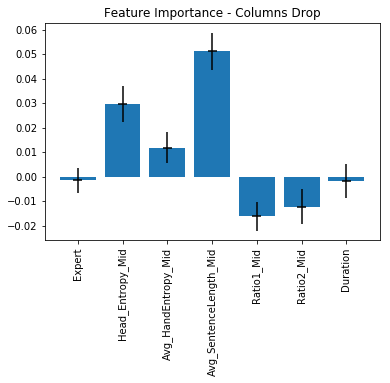

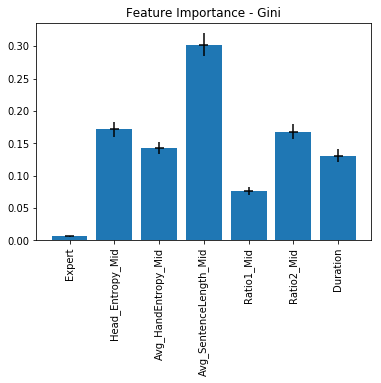

In [212]:

#print(all_scores)
all_scores_ = all_scores.drop(['fit_time', 'score_time'], axis=1).T
final = pd.DataFrame(index=all_scores_.index)

final['means'] = all_scores_.mean(axis=1)
final['std'] = all_scores_.std(axis=1)
final['sem'] = all_scores_.sem(axis=1)
final['confidence'] = all_scores_.apply(lambda row : 2*(np.mean(row) - st.t.interval(0.95, len(row)-1, loc=np.mean(row), scale=st.sem(row))[0]) , axis = 1)



final_fi = all_dropcol_features_importances.T
final_fi['means'] = final_fi.mean(axis=1)
final_fi['std'] = final_fi.std(axis=1)
final_fi['sem'] = final_fi.sem(axis=1)
final_fi['confidence'] = final_fi.apply(lambda row : 2*(np.mean(row) - st.t.interval(0.95, len(row)-1, loc=np.mean(row), scale=st.sem(row))[0]) , axis = 1)


plot_importance('Columns Drop', 
                final_fi['means'],
                final_fi['confidence'],
                subject_features_nophase, 
                sort=False)


final_fi_ = all_feature_importances.T
final_fi_['means'] = final_fi_.mean(axis=1)
final_fi_['std'] = final_fi_.std(axis=1)
final_fi_['sem'] = final_fi_.sem(axis=1)
final_fi_['confidence'] = final_fi_.apply(lambda row : 2*(np.mean(row) - st.t.interval(0.95, len(row)-1, loc=np.mean(row), scale=st.sem(row))[0]) , axis = 1)


plot_importance('Gini', 
                final_fi_['means'],
                final_fi_['confidence'],
                subject_features_nophase, 
                sort=False)


In [107]:
unpacked = [[p[key] for p in best_params] for key in best_params[0].keys()]
df = pd.DataFrame(data=np.vstack((scores, unpacked))).T
df.columns=['score', 'max_features', 'n_estimators', 'max_depth', 'min_samples_leaf']
print(df.sort_values(by=['score'], ascending=False))

      score max_features n_estimators max_depth min_samples_leaf
0  0.878095         None          100      None                1
3  0.837778         auto          100      None                1
6  0.825079         auto          100      None                1
1  0.815556         None          100         5                1
2  0.813356         None          100      None                1
5  0.810635         auto          100      None                1
9  0.785556         auto          100         5                1
4  0.783039         auto          100         5                1
8  0.773968         None          100         5                1
7  0.761451         auto          100         5                1
